In [9]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import json
from datetime import datetime

def setup_gdino_detector():
    """Initialize Grounding DINO detector"""
    print("🚀 Loading Grounding DINO model...")
    
    # Check GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🖥️ Using device: {device}")
    
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"✅ GPU: {gpu_name} ({total_memory:.1f} GB)")
        torch.cuda.empty_cache()
    
    # Load Grounding DINO
    model_id = "IDEA-Research/grounding-dino-tiny"
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id)
    model = model.to(device)
    model.eval()
    
    print(f"✅ Grounding DINO model loaded successfully!")
    return model, processor, device

def detect_persons_gdino(image, model, processor, device, confidence_threshold=0.3):
    """Detect persons using Grounding DINO"""
    # Convert to PIL if needed
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[2] == 3:
            pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            pil_image = Image.fromarray(image)
    else:
        pil_image = image
    
    width, height = pil_image.size
    
    # Prepare inputs
    text_prompt = [["a person"]]
    inputs = processor(images=pil_image, text=text_prompt, return_tensors="pt")
    device_inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                    for k, v in inputs.items()}
    
    # Run detection
    with torch.no_grad():
        outputs = model(**device_inputs)
    
    # Process results
    target_sizes = torch.tensor([[height, width]]).to(device)
    results = processor.post_process_grounded_object_detection(
        outputs,
        input_ids=device_inputs.get('input_ids'),
        box_threshold=confidence_threshold,
        text_threshold=0,
        target_sizes=target_sizes
    )[0]
    
    # Process detections
    detections = []
    if len(results['boxes']) > 0:
        boxes = results['boxes'].cpu().numpy()
        scores = results['scores'].cpu().numpy()
        
        for i, (box, score) in enumerate(zip(boxes, scores)):
            x1, y1, x2, y2 = box.astype(int)
            
            # Ensure coordinates are within image bounds
            x1 = max(0, min(x1, width-1))
            y1 = max(0, min(y1, height-1))
            x2 = max(x1+1, min(x2, width))
            y2 = max(y1+1, min(y2, height))
            
            detections.append({
                'id': i + 1,
                'box': [int(x1), int(y1), int(x2), int(y2)],
                'confidence': float(score)
            })
    
    return detections, pil_image

def expand_crop_bounds(box, image_width, image_height, expansion_factor=2.0):
    """
    Expand crop bounds by expansion_factor from sides and bottom (not top)
    
    Args:
        box: [x1, y1, x2, y2] original bounding box
        image_width, image_height: original image dimensions
        expansion_factor: factor to expand (2.0 = double size)
    
    Returns:
        expanded box coordinates [x1_exp, y1_exp, x2_exp, y2_exp]
    """
    x1, y1, x2, y2 = box
    
    # Calculate current box dimensions
    box_width = x2 - x1
    box_height = y2 - y1
    
    # Calculate expansion amounts
    width_expansion = (box_width * expansion_factor - box_width) / 2  # Split between left and right
    height_expansion = box_height * expansion_factor - box_height  # Only add to bottom
    
    # Expand bounds
    x1_exp = x1 - width_expansion
    y1_exp = y1  # Don't expand top
    x2_exp = x2 + width_expansion
    y2_exp = y2 + height_expansion
    
    # Ensure bounds are within image
    x1_exp = max(0, int(x1_exp))
    y1_exp = max(0, int(y1_exp))
    x2_exp = min(image_width, int(x2_exp))
    y2_exp = min(image_height, int(y2_exp))
    
    return [x1_exp, y1_exp, x2_exp, y2_exp]

def save_raw_and_expanded_crops(image, detections, frame_name, output_base_dir):
    """Save both raw and expanded cropped person images"""
    if len(detections) == 0:
        print(f"❌ No detections to crop for {frame_name}")
        return [], []
    
    # Convert image to numpy array if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_height, image_width = img_array.shape[:2]
    
    # Create frame-specific output directory
    frame_output_dir = os.path.join(output_base_dir, frame_name)
    os.makedirs(frame_output_dir, exist_ok=True)
    
    # Create both raw and expanded crops folders
    raw_folder = os.path.join(frame_output_dir, "raw_crops")
    expanded_folder = os.path.join(frame_output_dir, "expanded_crops")
    os.makedirs(raw_folder, exist_ok=True)
    os.makedirs(expanded_folder, exist_ok=True)
    
    print(f"\n✂️ SAVING RAW & EXPANDED CROPS FOR: {frame_name}")
    print("=" * 60)
    
    raw_crop_info = []
    expanded_crop_info = []
    
    for detection in detections:
        person_id = detection['id']
        original_box = detection['box']
        confidence = detection['confidence']
        
        x1, y1, x2, y2 = original_box
        
        # Expand the bounding box
        expanded_box = expand_crop_bounds(original_box, image_width, image_height, expansion_factor=2.0)
        x1_exp, y1_exp, x2_exp, y2_exp = expanded_box
        
        print(f"\n👤 PERSON {person_id}:")
        print(f"   📍 Original box: {original_box}")
        print(f"   📈 Expanded box: {expanded_box}")
        print(f"   🎯 Confidence: {confidence:.3f}")
        
        # 1. Save RAW crop (original detection box)
        try:
            raw_crop = img_array[y1:y2, x1:x2]
            
            if raw_crop.size > 0:
                # Save raw crop
                raw_crop_filename = f"person_{person_id}_raw.jpg"
                raw_crop_path = os.path.join(raw_folder, raw_crop_filename)
                
                # Convert RGB back to BGR for OpenCV saving
                raw_crop_bgr = cv2.cvtColor(raw_crop, cv2.COLOR_RGB2BGR)
                cv2.imwrite(raw_crop_path, raw_crop_bgr)
                
                # Store raw crop information
                raw_crop_data = {
                    'person_id': person_id,
                    'filename': raw_crop_filename,
                    'path': raw_crop_path,
                    'box': original_box,
                    'size': [raw_crop.shape[1], raw_crop.shape[0]],  # [width, height]
                    'confidence': confidence,
                    'frame_name': frame_name,
                    'crop_type': 'raw'
                }
                raw_crop_info.append(raw_crop_data)
                
                print(f"   ✅ RAW SAVED: {raw_crop_path}")
                print(f"   📐 Raw size: {raw_crop.shape[1]}x{raw_crop.shape[0]}")
                
            else:
                print(f"   ❌ Empty raw crop (invalid coordinates)")
                
        except Exception as e:
            print(f"   ❌ Error cropping raw person {person_id}: {e}")
        
        # 2. Save EXPANDED crop
        try:
            expanded_crop = img_array[y1_exp:y2_exp, x1_exp:x2_exp]
            
            if expanded_crop.size > 0:
                # Save expanded crop
                expanded_crop_filename = f"person_{person_id}_expanded.jpg"
                expanded_crop_path = os.path.join(expanded_folder, expanded_crop_filename)
                
                # Convert RGB back to BGR for OpenCV saving
                expanded_crop_bgr = cv2.cvtColor(expanded_crop, cv2.COLOR_RGB2BGR)
                cv2.imwrite(expanded_crop_path, expanded_crop_bgr)
                
                # Store expanded crop information
                expanded_crop_data = {
                    'person_id': person_id,
                    'filename': expanded_crop_filename,
                    'path': expanded_crop_path,
                    'original_box': original_box,
                    'expanded_box': expanded_box,
                    'size': [expanded_crop.shape[1], expanded_crop.shape[0]],  # [width, height]
                    'confidence': confidence,
                    'frame_name': frame_name,
                    'crop_type': 'expanded'
                }
                expanded_crop_info.append(expanded_crop_data)
                
                print(f"   ✅ EXPANDED SAVED: {expanded_crop_path}")
                print(f"   📐 Expanded size: {expanded_crop.shape[1]}x{expanded_crop.shape[0]}")
                
                # Display both crops side by side for verification
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
                
                # Raw crop
                ax1.imshow(raw_crop)
                ax1.set_title(f"RAW CROP\nPerson {person_id}\nSize: {raw_crop.shape[1]}x{raw_crop.shape[0]}", 
                             fontsize=12, fontweight='bold')
                ax1.axis('off')
                
                # Expanded crop
                ax2.imshow(expanded_crop)
                ax2.set_title(f"EXPANDED CROP\nPerson {person_id}\nSize: {expanded_crop.shape[1]}x{expanded_crop.shape[0]}", 
                             fontsize=12, fontweight='bold')
                ax2.axis('off')
                
                fig.suptitle(f"Frame: {frame_name} | Confidence: {confidence:.3f}", 
                           fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
                
            else:
                print(f"   ❌ Empty expanded crop (invalid coordinates)")
                
        except Exception as e:
            print(f"   ❌ Error cropping expanded person {person_id}: {e}")
    
    print("=" * 60)
    print(f"✅ Cropping complete:")
    print(f"   📦 Raw crops: {len(raw_crop_info)}/{len(detections)} successful")
    print(f"   📈 Expanded crops: {len(expanded_crop_info)}/{len(detections)} successful")
    
    return raw_crop_info, expanded_crop_info

def gdino_detection_and_expanded_cropping():
    """Main function to detect persons and save both raw and expanded crops"""
    
    # Configuration
    FRAMES_FOLDER = '/kaggle/input/samples-roi'
    OUTPUT_FOLDER = '/kaggle/working/expanded_crops_results'
    CONFIDENCE_THRESHOLD = 0.3
    
    print("🚀 GROUNDING DINO DETECTION & RAW + EXPANDED CROPPING PIPELINE")
    print("=" * 70)
    print(f"🎯 Confidence threshold: {CONFIDENCE_THRESHOLD}")
    print(f"📦 Raw crops: Original detection bounding boxes")
    print(f"📈 Expanded crops: 2.0x expansion (sides and bottom only)")
    print(f"📁 Input folder: {FRAMES_FOLDER}")
    print(f"📁 Output folder: {OUTPUT_FOLDER}")
    print("=" * 70)
    
    # Initialize detector
    model, processor, device = setup_gdino_detector()
    
    # Check input folder
    if not os.path.exists(FRAMES_FOLDER):
        print(f"❌ Frames folder not found: {FRAMES_FOLDER}")
        return
    
    # Find image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    image_files = []
    
    for file in os.listdir(FRAMES_FOLDER):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_files.append(file)
    
    if not image_files:
        print(f"❌ No image files found in {FRAMES_FOLDER}")
        return
    
    print(f"\n🖼️ Found {len(image_files)} frames:")
    for i, frame in enumerate(image_files[:10], 1):  # Show first 10
        print(f"   {i}. {frame}")
    if len(image_files) > 10:
        print(f"   ... and {len(image_files) - 10} more")
    
    # Create output directory
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    # Process all frames
    all_results = []
    all_crops = []
    total_frames = len(image_files)
    
    print(f"\n🚀 Starting processing of {total_frames} frames...")
    print("=" * 70)
    
    for i, image_file in enumerate(image_files, 1):
        frame_path = os.path.join(FRAMES_FOLDER, image_file)
        frame_name = os.path.splitext(image_file)[0]
        
        print(f"\n📊 PROGRESS: {i}/{total_frames} ({i/total_frames*100:.1f}%)")
        print(f"🖼️ PROCESSING FRAME: {frame_name}")
        
        try:
            # Load image
            image = cv2.imread(frame_path)
            if image is None:
                print(f"❌ Could not load image: {frame_path}")
                continue
            
            # Detect persons
            detections, pil_image = detect_persons_gdino(image, model, processor, device, CONFIDENCE_THRESHOLD)
            print(f"🎯 Found {len(detections)} detections")
            
            # Save both raw and expanded crops
            raw_crops_info, expanded_crops_info = save_raw_and_expanded_crops(pil_image, detections, frame_name, OUTPUT_FOLDER)
            
            # Store results
            frame_result = {
                'frame_name': frame_name,
                'frame_path': frame_path,
                'total_detections': len(detections),
                'successful_raw_crops': len(raw_crops_info),
                'successful_expanded_crops': len(expanded_crops_info),
                'detections': detections,
                'timestamp': datetime.now().isoformat()
            }
            all_results.append(frame_result)
            all_crops.extend(raw_crops_info + expanded_crops_info)  # Combine both types
            
            print(f"✅ Frame {i} completed:")
            print(f"   🎯 {len(detections)} detections")
            print(f"   📦 {len(raw_crops_info)} raw crops saved")
            print(f"   📈 {len(expanded_crops_info)} expanded crops saved")
            
            # Clean GPU memory
            if device == "cuda":
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"❌ Error processing frame {i}: {e}")
            import traceback
            traceback.print_exc()
    
    # Save comprehensive results
    results_summary = {
        'processing_info': {
            'confidence_threshold': CONFIDENCE_THRESHOLD,
            'expansion_factor': 2.0,
            'expansion_directions': 'sides and bottom only',
            'total_frames': total_frames,
            'processed_frames': len(all_results),
            'processing_date': datetime.now().isoformat(),
            'crop_types': ['raw', 'expanded']
        },
        'statistics': {
            'total_detections': sum(r['total_detections'] for r in all_results),
            'total_successful_raw_crops': sum(r['successful_raw_crops'] for r in all_results),
            'total_successful_expanded_crops': sum(r['successful_expanded_crops'] for r in all_results),
            'average_detections_per_frame': sum(r['total_detections'] for r in all_results) / len(all_results) if all_results else 0,
            'frames_with_detections': len([r for r in all_results if r['total_detections'] > 0])
        },
        'frame_results': all_results,
        'all_crops': all_crops
    }
    
    # Save results file
    results_path = os.path.join(OUTPUT_FOLDER, 'raw_and_expanded_crops_summary.json')
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"\n{'🎉'*50}")
    print(f"🎉 RAW & EXPANDED CROPPING PIPELINE COMPLETE!")
    print(f"{'🎉'*50}")
    
    total_detections = sum(r['total_detections'] for r in all_results)
    total_raw_crops = sum(r['successful_raw_crops'] for r in all_results)
    total_expanded_crops = sum(r['successful_expanded_crops'] for r in all_results)
    
    print(f"\n📊 FINAL STATISTICS:")
    print(f"   🖼️ Total frames processed: {len(all_results)}")
    print(f"   👥 Total persons detected: {total_detections}")
    print(f"   📦 Total raw crops saved: {total_raw_crops}")
    print(f"   📈 Total expanded crops saved: {total_expanded_crops}")
    print(f"   📊 Average detections per frame: {total_detections/len(all_results):.2f}")
    print(f"   🎯 Raw crop success rate: {total_raw_crops/total_detections*100:.1f}%" if total_detections > 0 else "   🎯 Raw crop success rate: N/A")
    print(f"   🎯 Expanded crop success rate: {total_expanded_crops/total_detections*100:.1f}%" if total_detections > 0 else "   🎯 Expanded crop success rate: N/A")
    
    print(f"\n📁 FOLDER STRUCTURE:")
    print(f"   📂 {OUTPUT_FOLDER}/")
    print(f"      📂 frame_name/")
    print(f"         📂 raw_crops/        (original detection boxes)")
    print(f"         📂 expanded_crops/   (2x expanded boxes)")
    
    print(f"\n📁 All results saved in: {OUTPUT_FOLDER}")
    print(f"📄 Summary saved: {results_path}")
    print(f"📈 Ready for classification experiments with both crop types!")
    
    if device == "cuda":
        torch.cuda.empty_cache()
        print("🧹 GPU memory cleanup completed")


gdino_detection_and_expanded_cropping()

🚀 GROUNDING DINO DETECTION & RAW + EXPANDED CROPPING PIPELINE
🎯 Confidence threshold: 0.3
📦 Raw crops: Original detection bounding boxes
📈 Expanded crops: 2.0x expansion (sides and bottom only)
📁 Input folder: /kaggle/input/samples-roi
📁 Output folder: /kaggle/working/expanded_crops_results
🚀 Loading Grounding DINO model...
🖥️ Using device: cuda
✅ GPU: Tesla T4 (14.7 GB)


KeyboardInterrupt: 

🧠 QWEN 2.5 VISION 3B PEDESTRIAN BEHAVIOR CLASSIFICATION
📁 Crops folder: /kaggle/working/expanded_crops_results
📁 Output folder: /kaggle/working/classification_results
🎯 Behavior classes: walking, running, biking, scootering, pushing stroller, standing
🧹 Clearing GPU memory from previous models...
🔋 GPU Memory Status:
   Allocated: 0.01 GB
   Cached: 0.02 GB
   Total: 14.74 GB
   Free: 14.73 GB
✅ GPU memory cleared!
🧠 Loading Qwen 2.5 Vision 3B model...
📦 Installing transformers>=4.45.0...
✅ transformers>=4.45.0 installed successfully
📦 Installing accelerate...
✅ accelerate installed successfully
📦 Installing tiktoken...
✅ tiktoken installed successfully
📦 Installing qwen-vl-utils...
✅ qwen-vl-utils installed successfully
✅ Imports successful
🖥️ Using device: cuda
✅ GPU: Tesla T4 (14.7 GB total, 14.7 GB free)
📥 Loading model and processor...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 GPU Memory Used by model: 3.41 GB
✅ Qwen 2.5 Vision 3B model loaded successfully!
📁 Found 63 raw cropped images to classify

🚀 Starting raw crops classification of 63 pedestrian images...

📊 PROGRESS: 1/63 (1.6%)
🖼️ Frame: frame_000062 | Image: person_3_raw.jpg
🎯 Classification: standing
💬 Response: standing


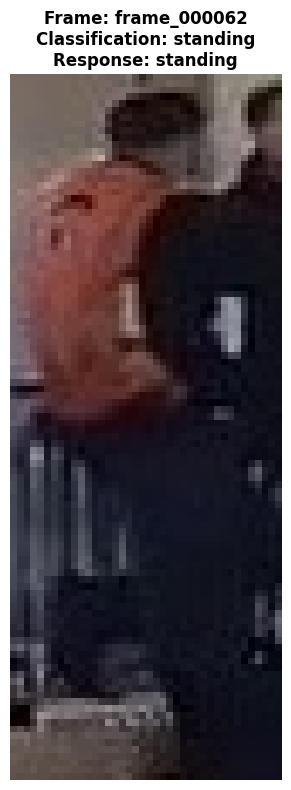

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 2/63 (3.2%)
🖼️ Frame: frame_000062 | Image: person_4_raw.jpg
🎯 Classification: running
💬 Response: running


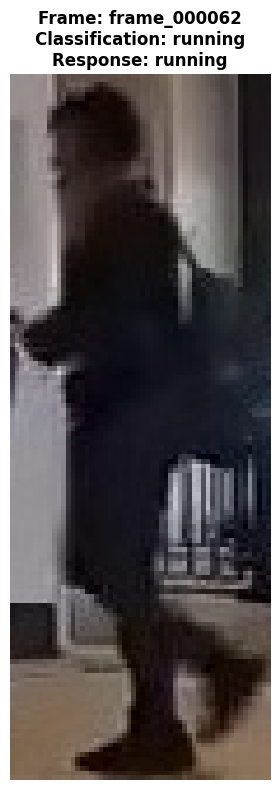

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 3/63 (4.8%)
🖼️ Frame: frame_000062 | Image: person_1_raw.jpg
🎯 Classification: standing
💬 Response: standing


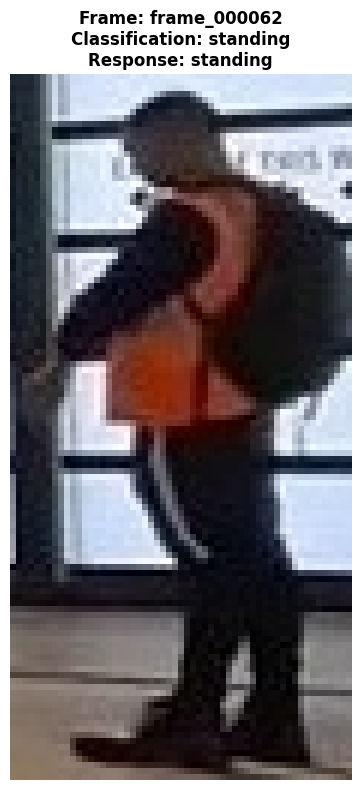

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 4/63 (6.3%)
🖼️ Frame: frame_000062 | Image: person_6_raw.jpg
🎯 Classification: standing
💬 Response: standing


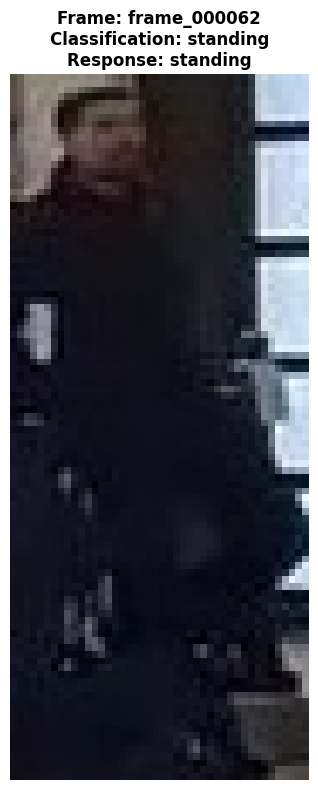

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 5/63 (7.9%)
🖼️ Frame: frame_000062 | Image: person_5_raw.jpg
🎯 Classification: standing
💬 Response: standing


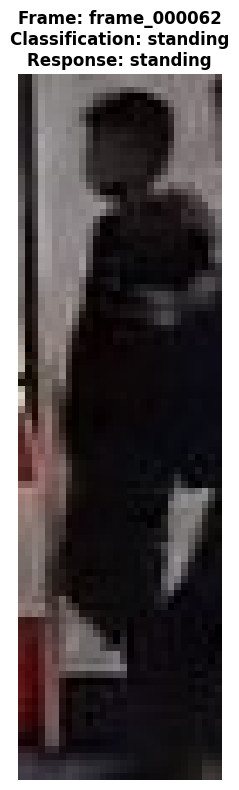

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 6/63 (9.5%)
🖼️ Frame: frame_000062 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


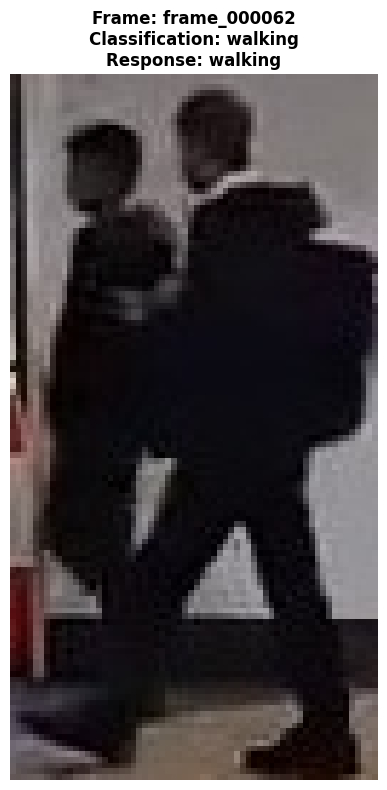

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 7/63 (11.1%)
🖼️ Frame: frame_000025 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


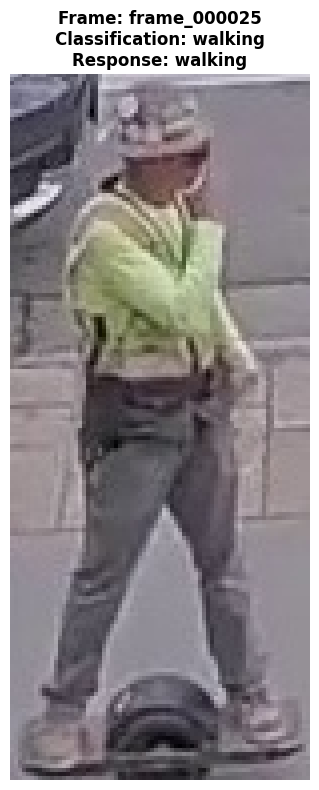

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 8/63 (12.7%)
🖼️ Frame: frame_000069 | Image: person_1_raw.jpg
🎯 Classification: running
💬 Response: running


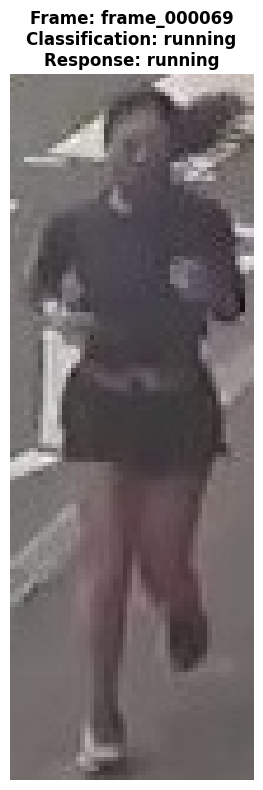

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 9/63 (14.3%)
🖼️ Frame: frame_000069 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


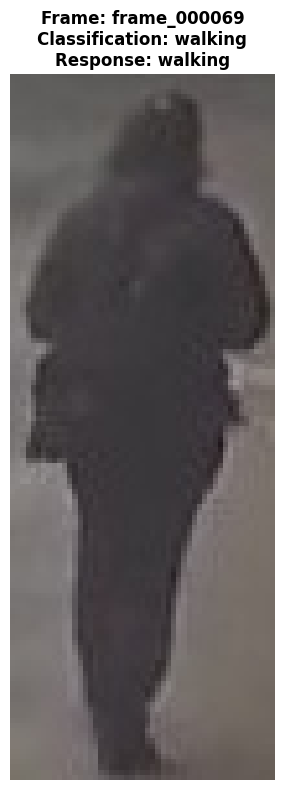

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 10/63 (15.9%)
🖼️ Frame: frame_000028 | Image: person_3_raw.jpg
🎯 Classification: running
💬 Response: running


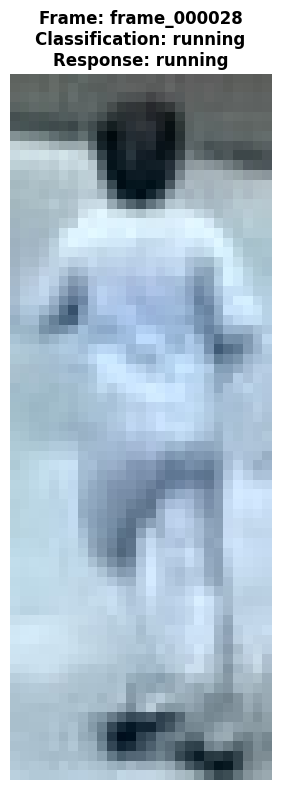

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 11/63 (17.5%)
🖼️ Frame: frame_000028 | Image: person_4_raw.jpg
🎯 Classification: running
💬 Response: running


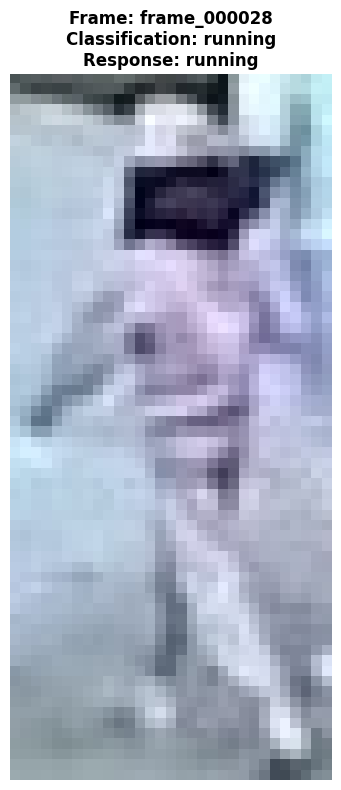

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 12/63 (19.0%)
🖼️ Frame: frame_000028 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


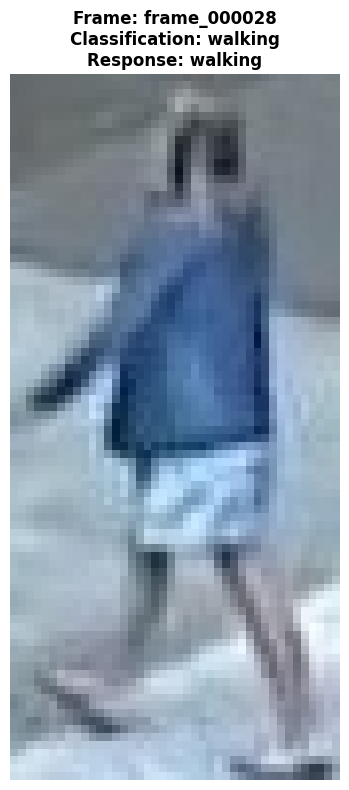

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 13/63 (20.6%)
🖼️ Frame: frame_000028 | Image: person_6_raw.jpg
🎯 Classification: walking
💬 Response: walking


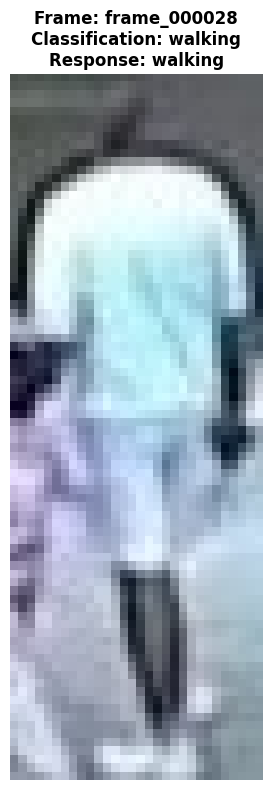

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 14/63 (22.2%)
🖼️ Frame: frame_000028 | Image: person_5_raw.jpg
🎯 Classification: walking
💬 Response: walking


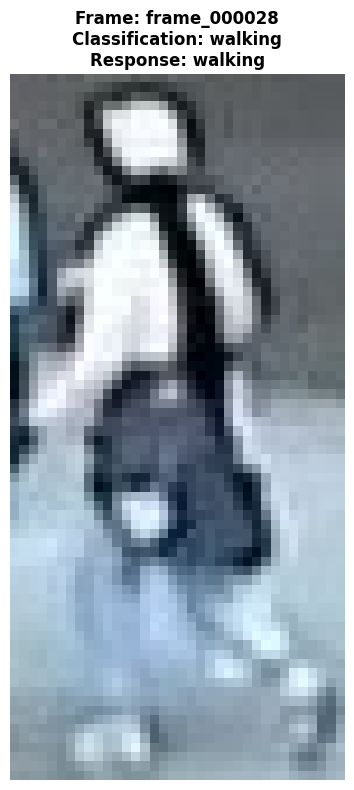

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 15/63 (23.8%)
🖼️ Frame: frame_000028 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


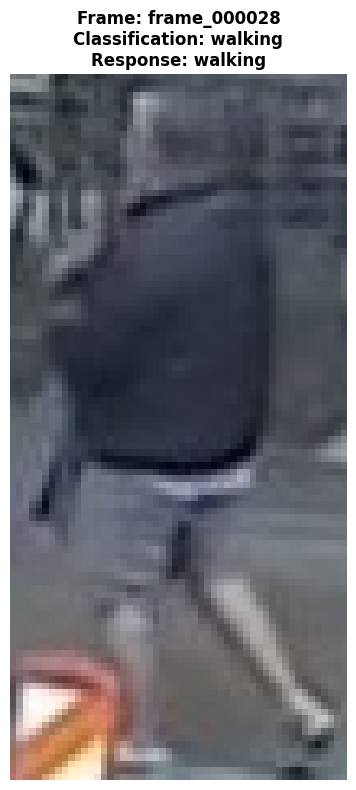

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 16/63 (25.4%)
🖼️ Frame: frame_000000 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


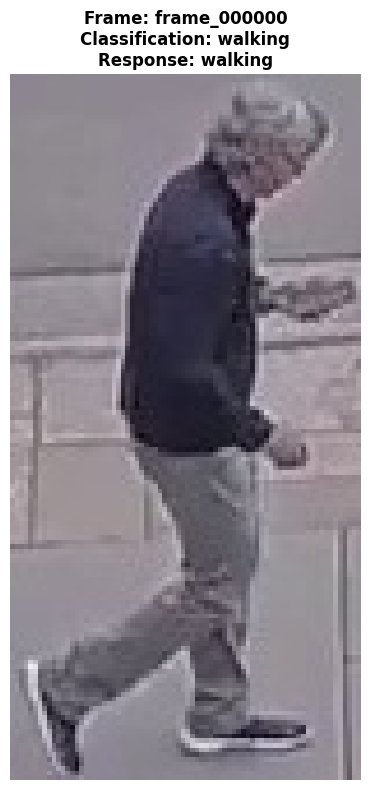

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 17/63 (27.0%)
🖼️ Frame: frame_000027 | Image: person_3_raw.jpg
🎯 Classification: standing
💬 Response: standing


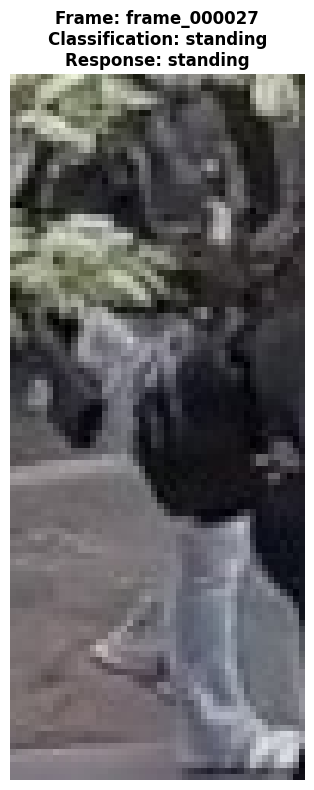

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 18/63 (28.6%)
🖼️ Frame: frame_000027 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


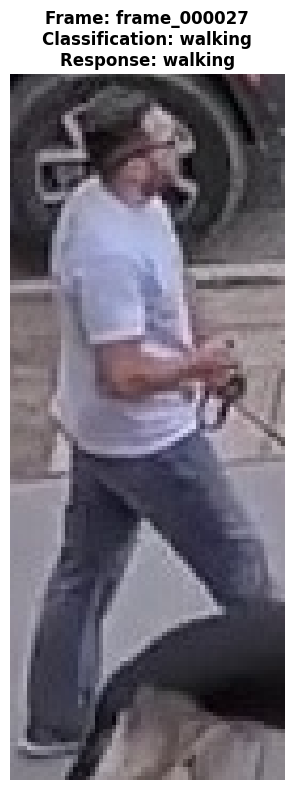

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 19/63 (30.2%)
🖼️ Frame: frame_000027 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


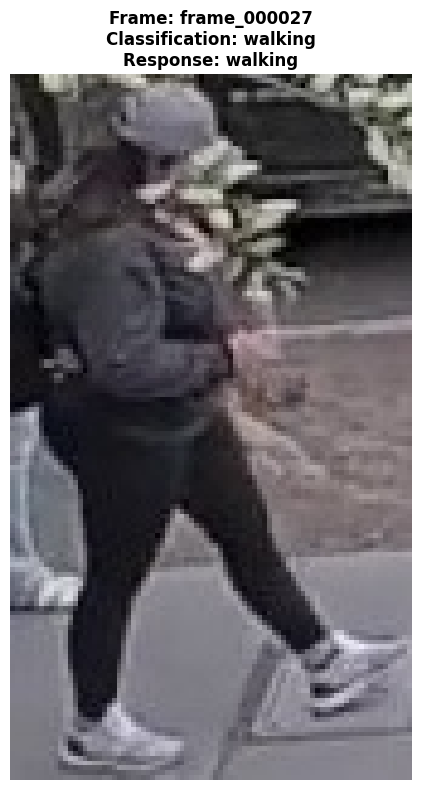

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 20/63 (31.7%)
🖼️ Frame: frame_000096 | Image: person_3_raw.jpg
🎯 Classification: walking
💬 Response: walking


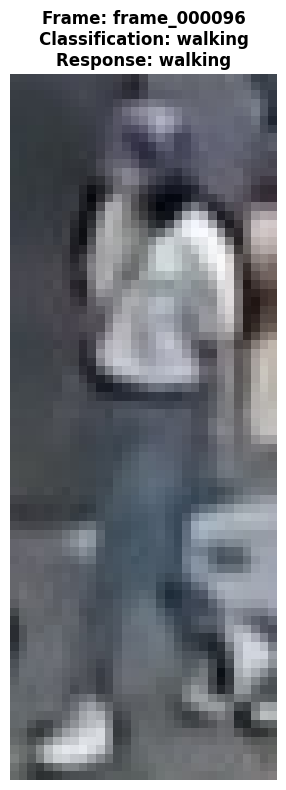

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 21/63 (33.3%)
🖼️ Frame: frame_000096 | Image: person_4_raw.jpg
🎯 Classification: running
💬 Response: running


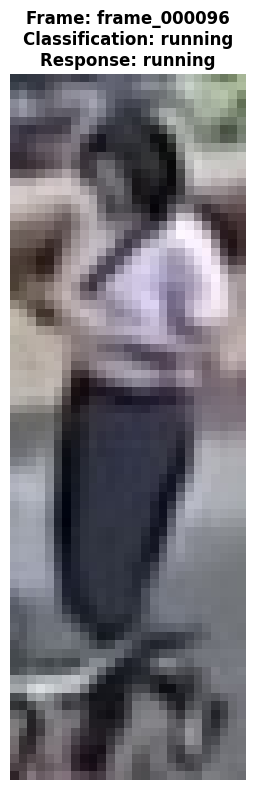

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 22/63 (34.9%)
🖼️ Frame: frame_000096 | Image: person_7_raw.jpg
🎯 Classification: standing
💬 Response: standing


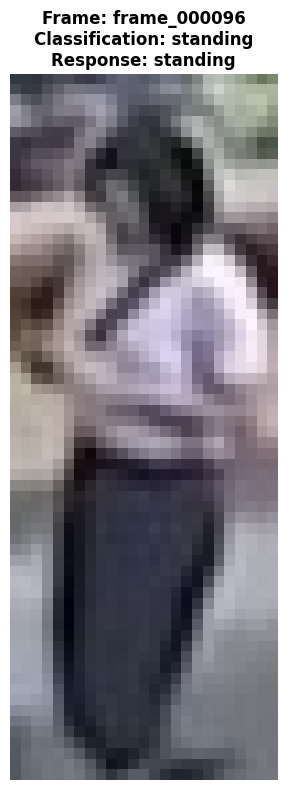

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 23/63 (36.5%)
🖼️ Frame: frame_000096 | Image: person_1_raw.jpg
🎯 Classification: standing
💬 Response: standing


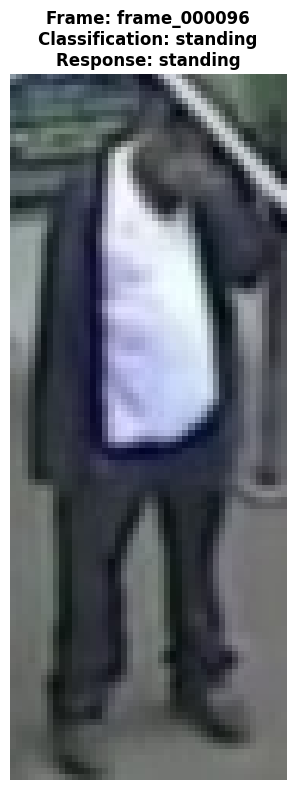

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 24/63 (38.1%)
🖼️ Frame: frame_000096 | Image: person_6_raw.jpg
🎯 Classification: walking
💬 Response: walking


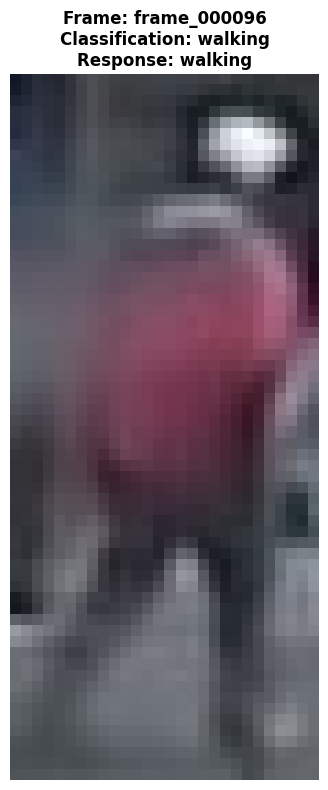

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 25/63 (39.7%)
🖼️ Frame: frame_000096 | Image: person_5_raw.jpg
🎯 Classification: walking
💬 Response: walking


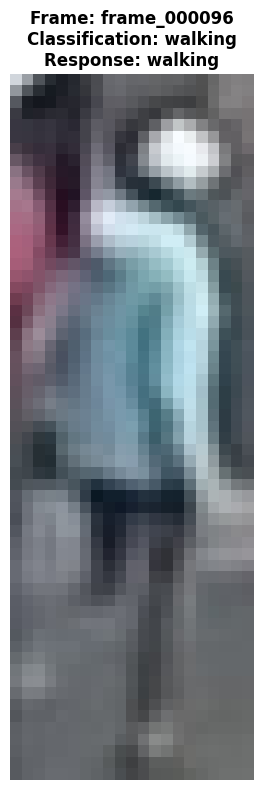

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 26/63 (41.3%)
🖼️ Frame: frame_000096 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


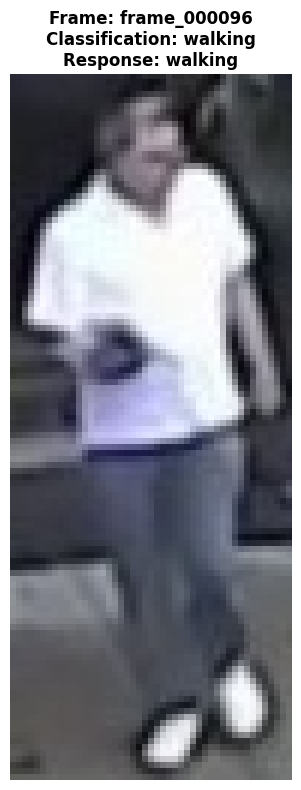

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 27/63 (42.9%)
🖼️ Frame: frame_000014 | Image: person_3_raw.jpg
🎯 Classification: walking
💬 Response: walking


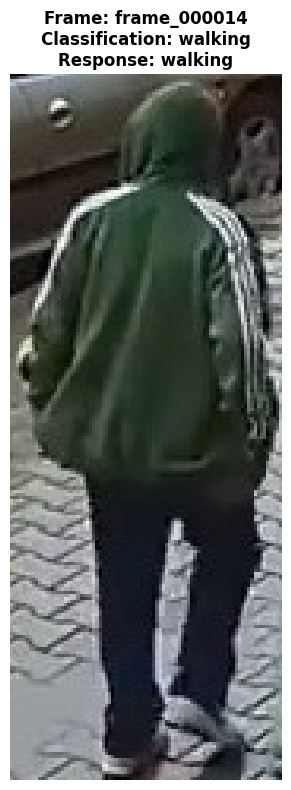

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 28/63 (44.4%)
🖼️ Frame: frame_000014 | Image: person_4_raw.jpg
🎯 Classification: walking
💬 Response: walking


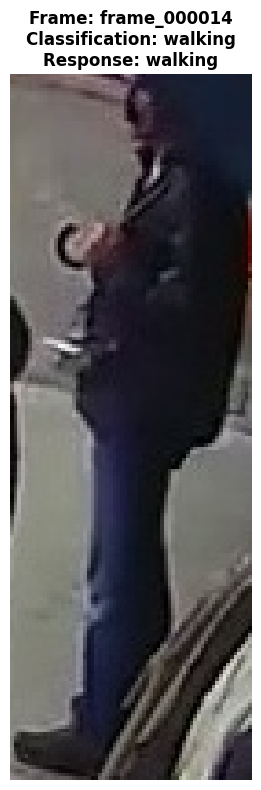

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 29/63 (46.0%)
🖼️ Frame: frame_000014 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


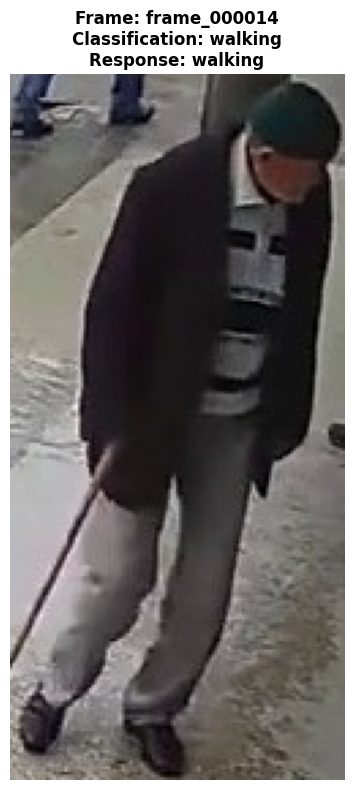

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 30/63 (47.6%)
🖼️ Frame: frame_000014 | Image: person_5_raw.jpg
🎯 Classification: walking
💬 Response: walking


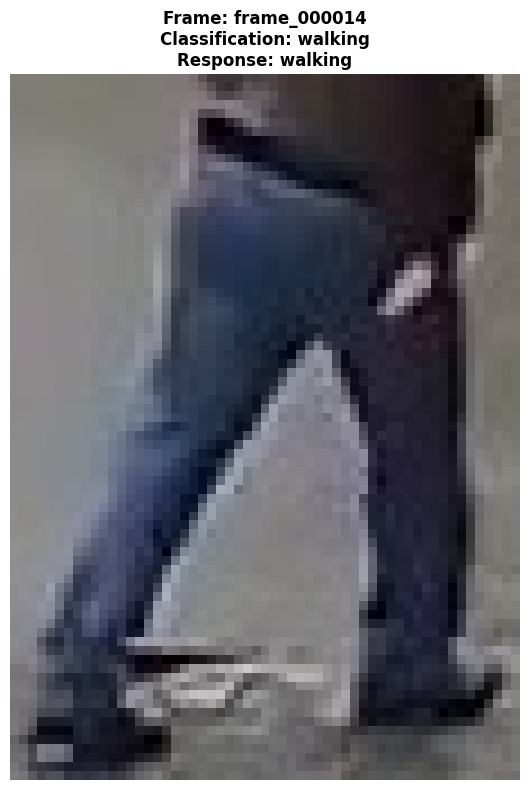

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 31/63 (49.2%)
🖼️ Frame: frame_000014 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


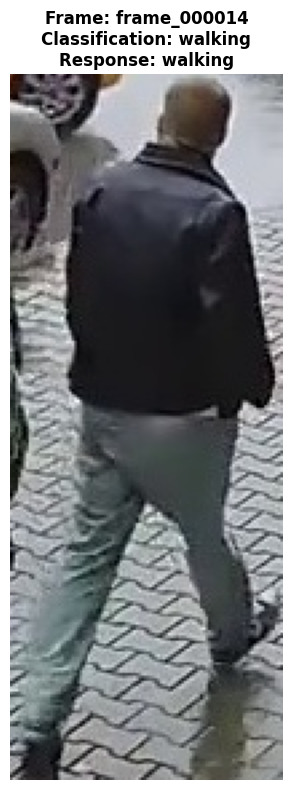

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 32/63 (50.8%)
🖼️ Frame: frame_000081 | Image: person_1_raw.jpg
🎯 Classification: running
💬 Response: running


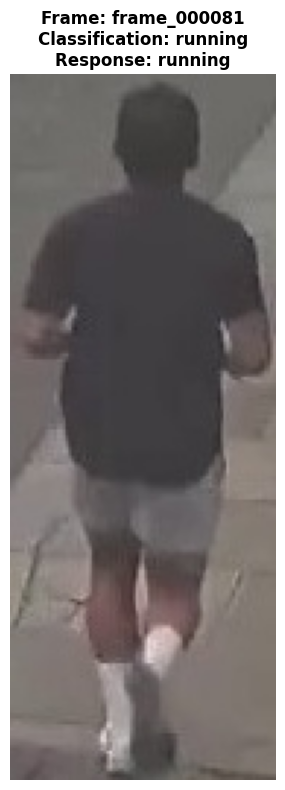

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 33/63 (52.4%)
🖼️ Frame: frame_000081 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


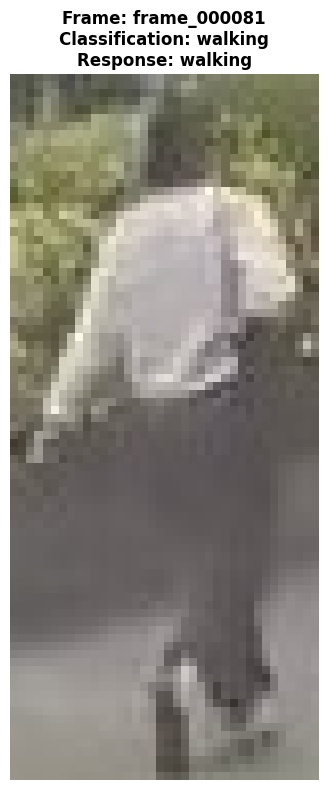

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 34/63 (54.0%)
🖼️ Frame: frame_000030 | Image: person_3_raw.jpg
🎯 Classification: running
💬 Response: running


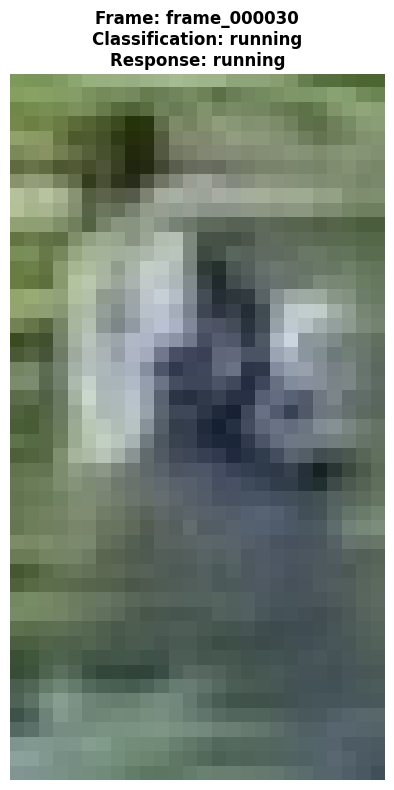

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 35/63 (55.6%)
🖼️ Frame: frame_000030 | Image: person_1_raw.jpg
🎯 Classification: running
💬 Response: running


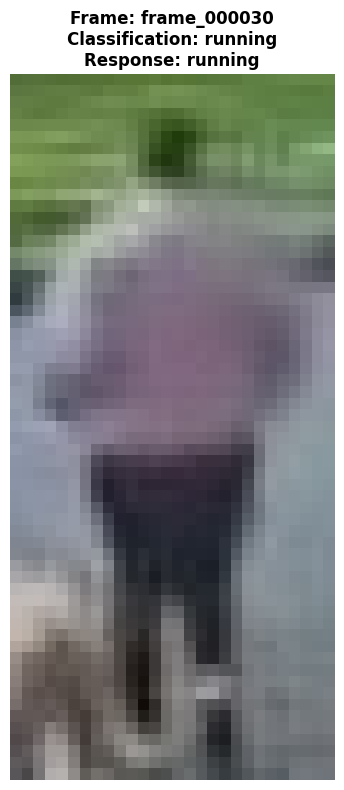

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 36/63 (57.1%)
🖼️ Frame: frame_000030 | Image: person_2_raw.jpg
🎯 Classification: biking
💬 Response: biking


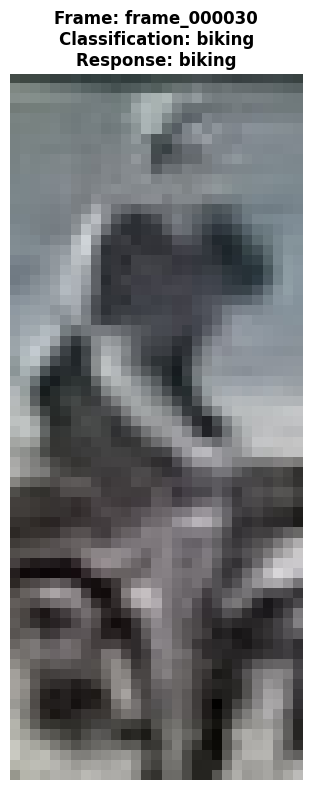

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 37/63 (58.7%)
🖼️ Frame: frame_000109 | Image: person_3_raw.jpg
🎯 Classification: walking
💬 Response: walking


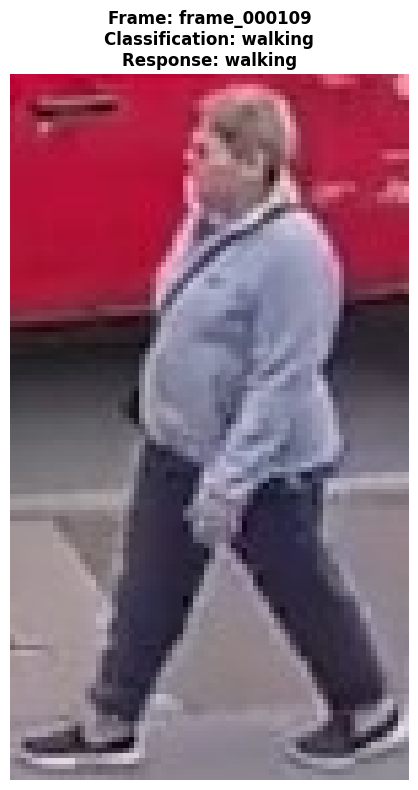

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 38/63 (60.3%)
🖼️ Frame: frame_000109 | Image: person_4_raw.jpg
🎯 Classification: pushing stroller
💬 Response: pushing stroller


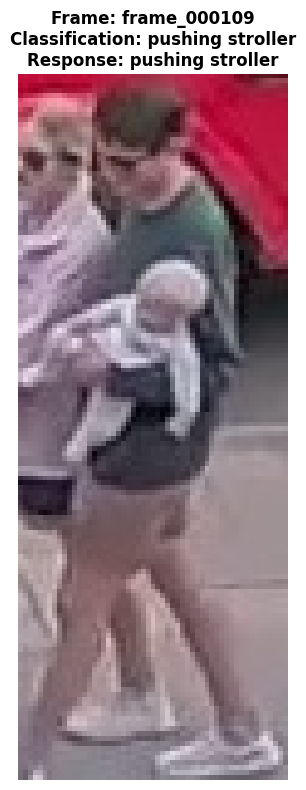

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 39/63 (61.9%)
🖼️ Frame: frame_000109 | Image: person_1_raw.jpg
🎯 Classification: pushing stroller
💬 Response: pushing stroller


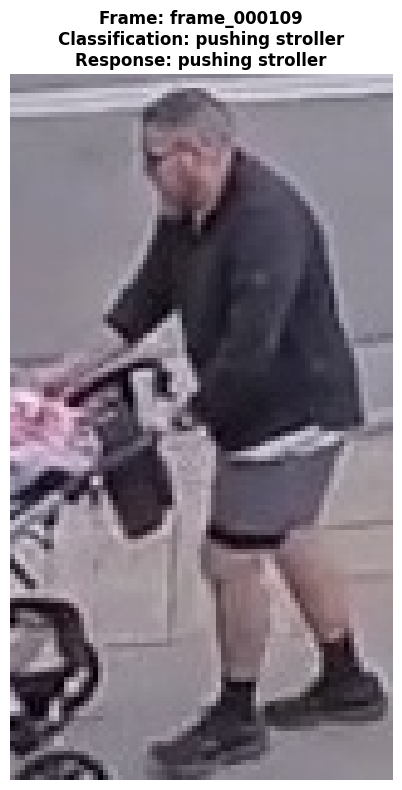

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 40/63 (63.5%)
🖼️ Frame: frame_000109 | Image: person_5_raw.jpg
🎯 Classification: walking
💬 Response: walking


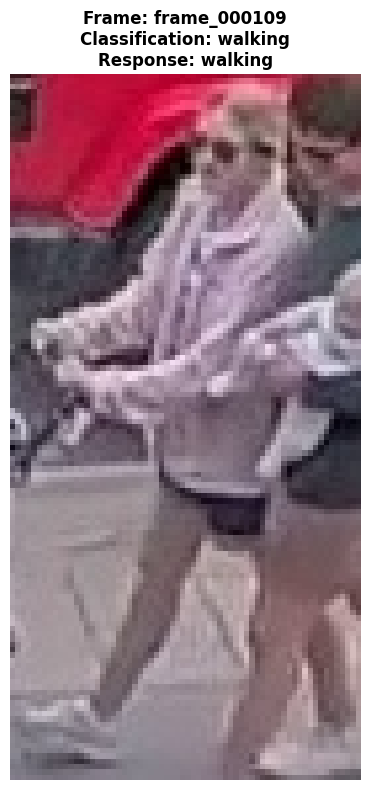

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 41/63 (65.1%)
🖼️ Frame: frame_000109 | Image: person_2_raw.jpg
🎯 Classification: standing
💬 Response: standing


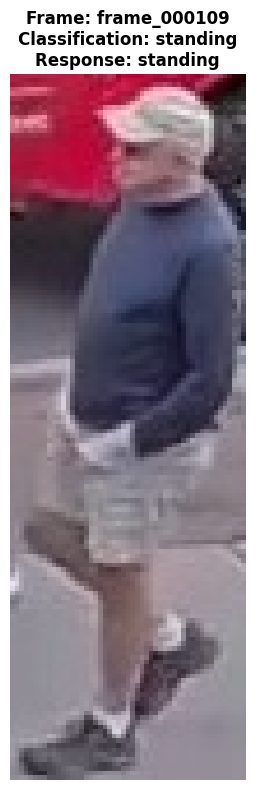

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 42/63 (66.7%)
🖼️ Frame: frame_000004 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


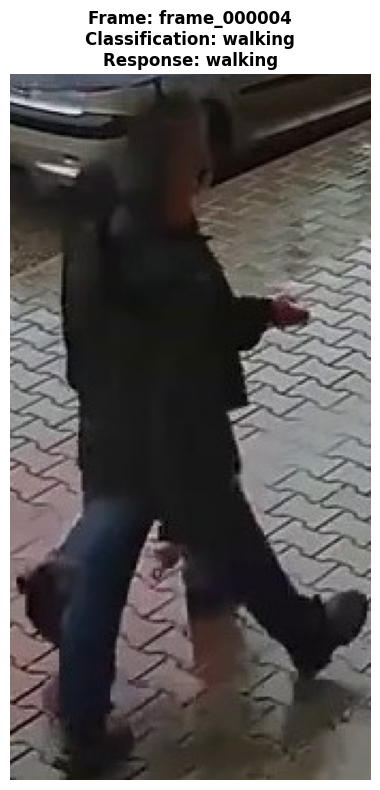

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 43/63 (68.3%)
🖼️ Frame: frame_000040 | Image: person_3_raw.jpg
🎯 Classification: walking
💬 Response: walking


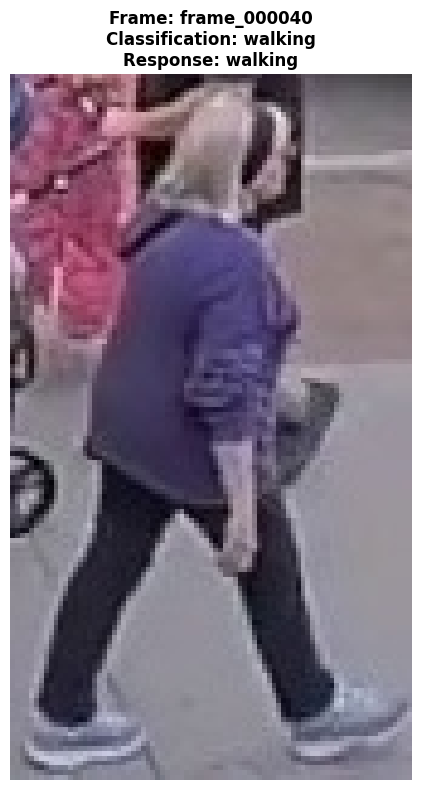

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 44/63 (69.8%)
🖼️ Frame: frame_000040 | Image: person_4_raw.jpg
🎯 Classification: walking
💬 Response: walking


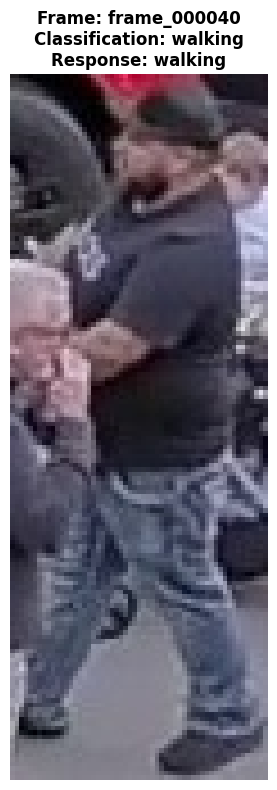

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 45/63 (71.4%)
🖼️ Frame: frame_000040 | Image: person_7_raw.jpg
🎯 Classification: standing
💬 Response: standing


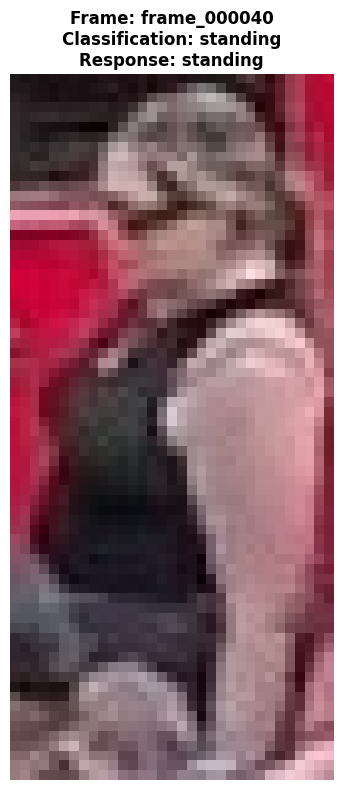

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 46/63 (73.0%)
🖼️ Frame: frame_000040 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


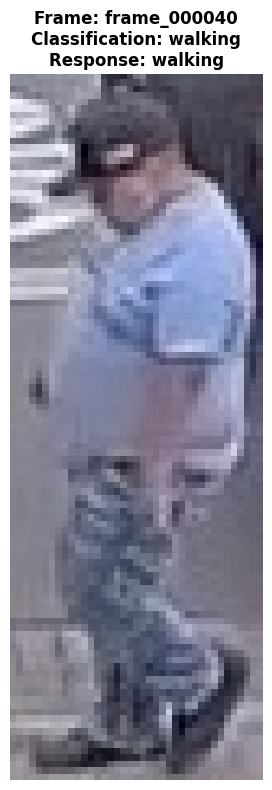

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 47/63 (74.6%)
🖼️ Frame: frame_000040 | Image: person_6_raw.jpg
🎯 Classification: pushing stroller
💬 Response: pushing stroller


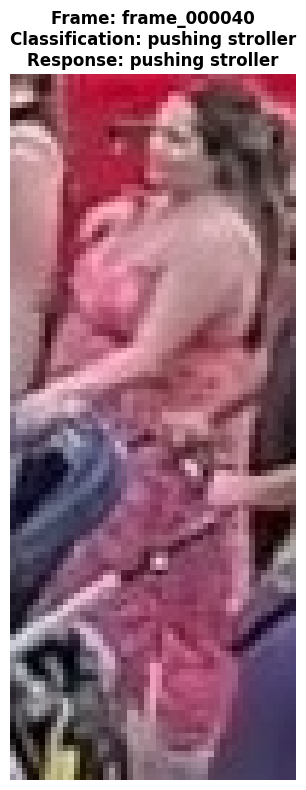

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 48/63 (76.2%)
🖼️ Frame: frame_000040 | Image: person_5_raw.jpg
🎯 Classification: walking
💬 Response: walking


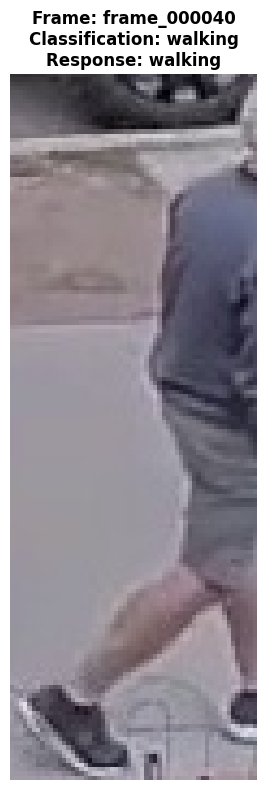

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 49/63 (77.8%)
🖼️ Frame: frame_000040 | Image: person_8_raw.jpg
🎯 Classification: standing
💬 Response: standing


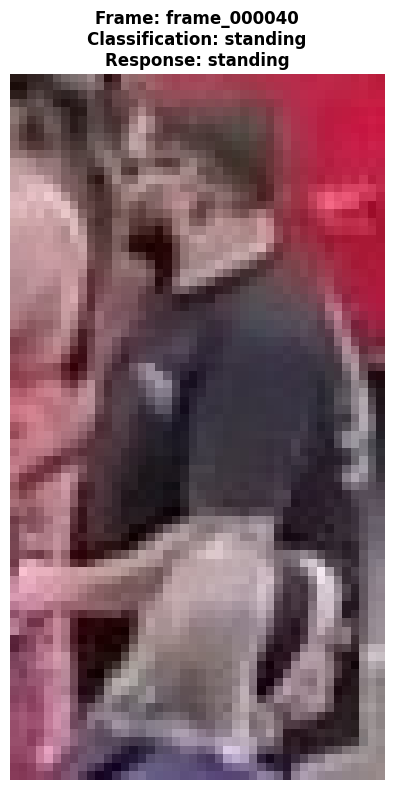

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 50/63 (79.4%)
🖼️ Frame: frame_000040 | Image: person_2_raw.jpg
🎯 Classification: pushing stroller
💬 Response: pushing stroller


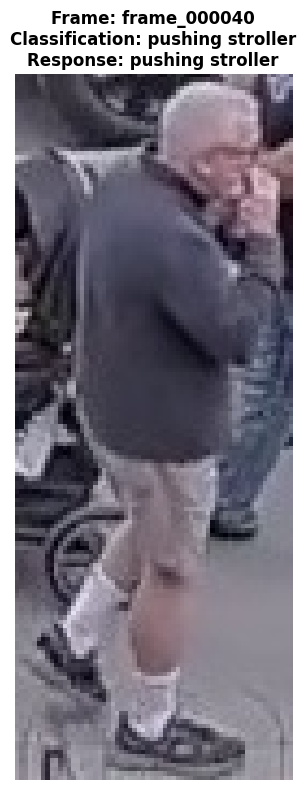

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 51/63 (81.0%)
🖼️ Frame: frame_000043 | Image: person_3_raw.jpg
🎯 Classification: walking
💬 Response: walking


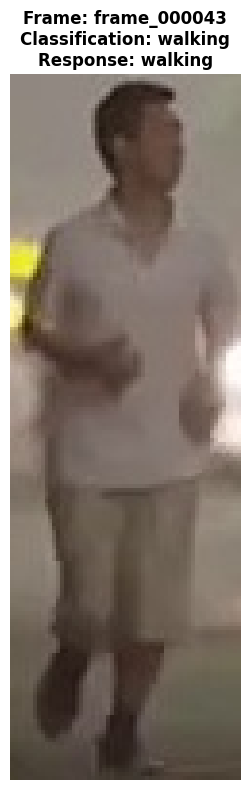

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 52/63 (82.5%)
🖼️ Frame: frame_000043 | Image: person_4_raw.jpg
🎯 Classification: walking
💬 Response: walking


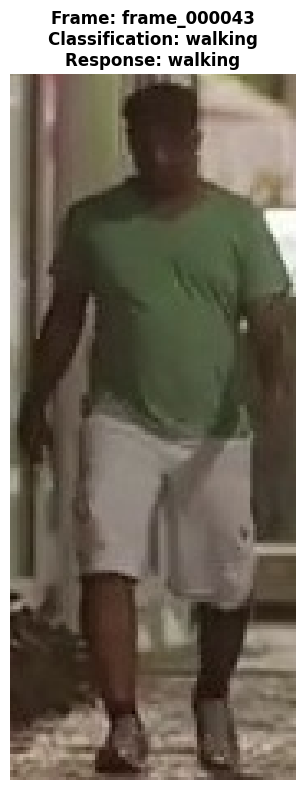

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 53/63 (84.1%)
🖼️ Frame: frame_000043 | Image: person_7_raw.jpg
🎯 Classification: scootering
💬 Response: scootering


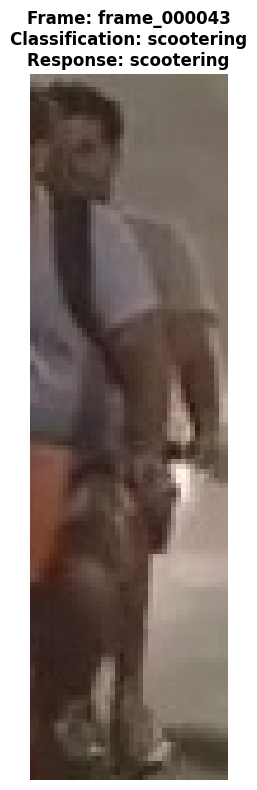

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 54/63 (85.7%)
🖼️ Frame: frame_000043 | Image: person_1_raw.jpg
🎯 Classification: standing
💬 Response: standing


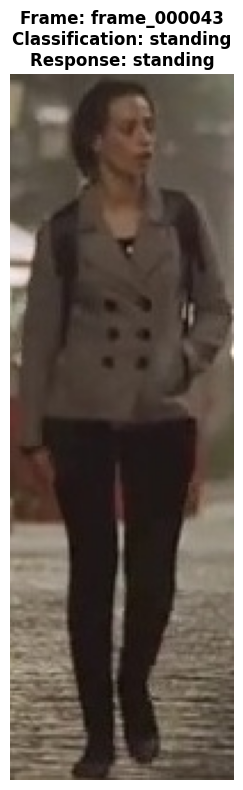

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 55/63 (87.3%)
🖼️ Frame: frame_000043 | Image: person_6_raw.jpg
🎯 Classification: scootering
💬 Response: scootering


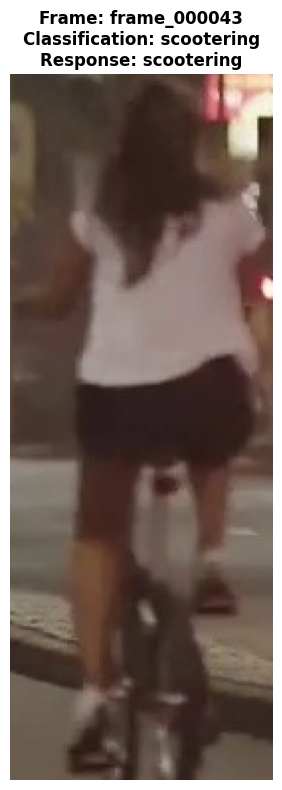

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 56/63 (88.9%)
🖼️ Frame: frame_000043 | Image: person_5_raw.jpg
🎯 Classification: biking
💬 Response: biking


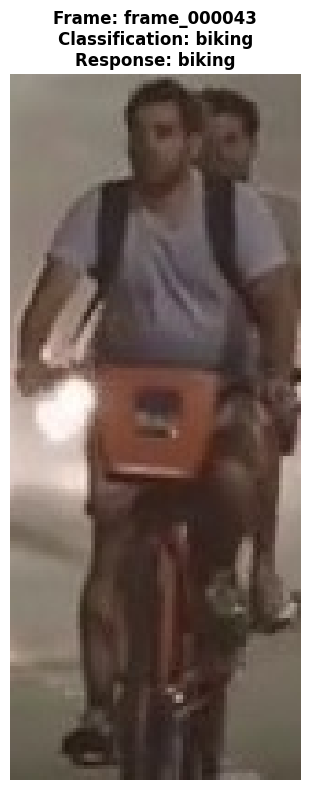

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 57/63 (90.5%)
🖼️ Frame: frame_000043 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


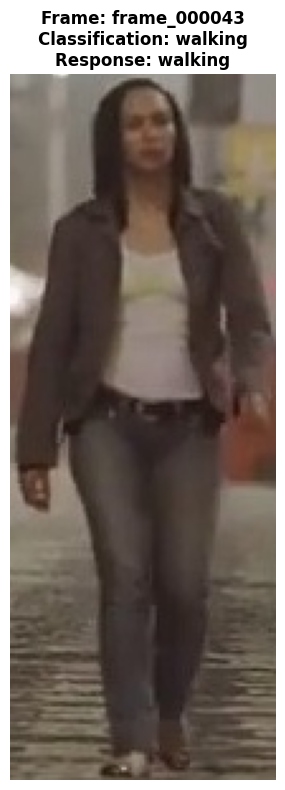

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 58/63 (92.1%)
🖼️ Frame: frame_000029 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


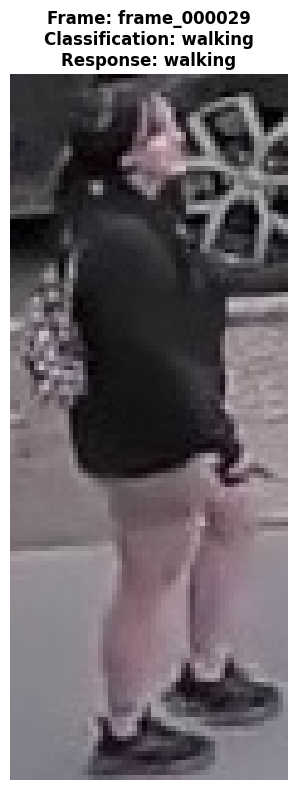

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 59/63 (93.7%)
🖼️ Frame: frame_000029 | Image: person_2_raw.jpg
🎯 Classification: walking
💬 Response: walking


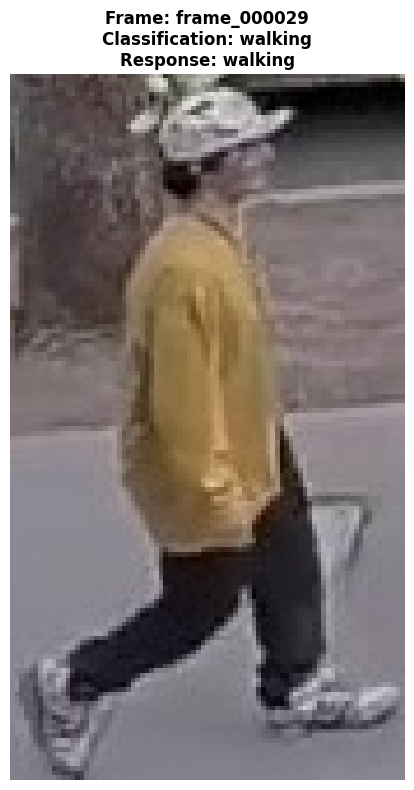

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 60/63 (95.2%)
🖼️ Frame: frame_000033 | Image: person_3_raw.jpg
🎯 Classification: walking
💬 Response: walking


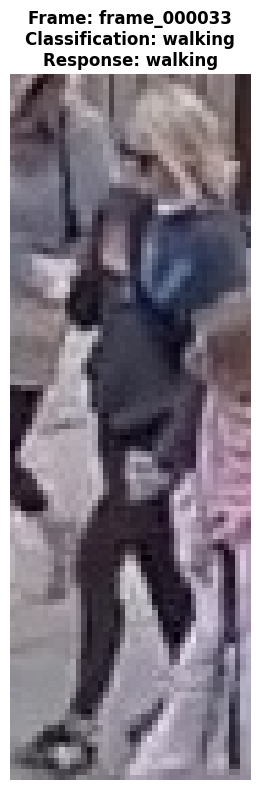

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔋 Current GPU usage: 3.41 GB

📊 PROGRESS: 61/63 (96.8%)
🖼️ Frame: frame_000033 | Image: person_4_raw.jpg
🎯 Classification: walking
💬 Response: walking


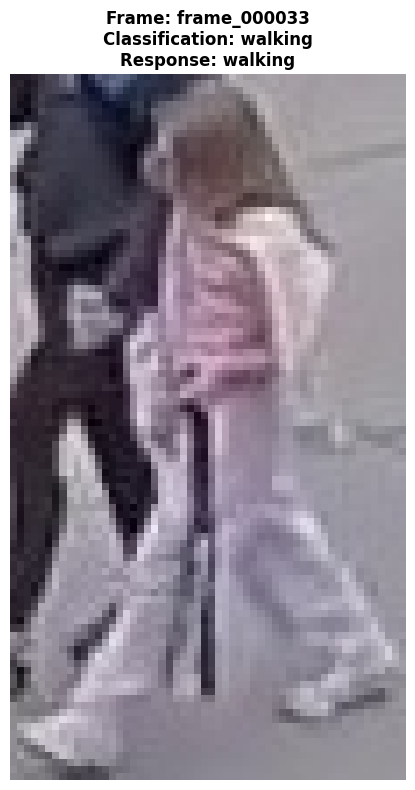

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 62/63 (98.4%)
🖼️ Frame: frame_000033 | Image: person_1_raw.jpg
🎯 Classification: walking
💬 Response: walking


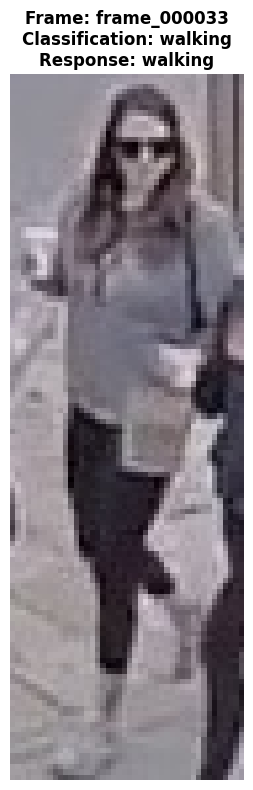

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📊 PROGRESS: 63/63 (100.0%)
🖼️ Frame: frame_000033 | Image: person_2_raw.jpg
🎯 Classification: pushing stroller
💬 Response: pushing stroller


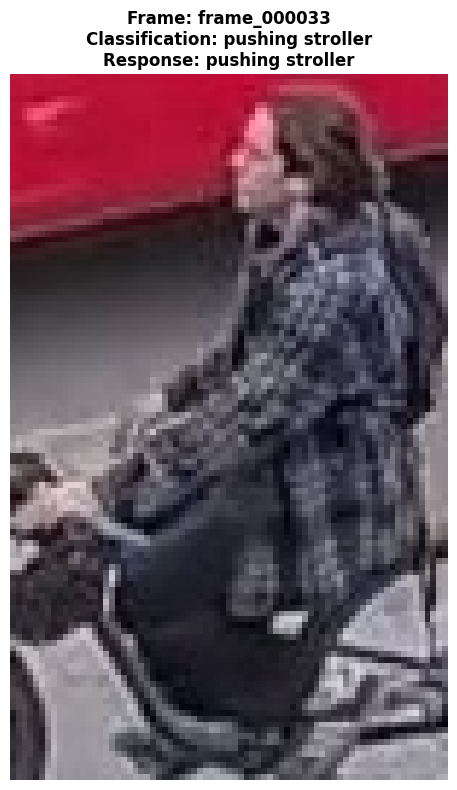

🔋 Current GPU usage: 3.41 GB

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🎉 RAW CROPS BEHAVIOR CLASSIFICATION COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📊 RAW CROPS CLASSIFICATION STATISTICS:
   Walking: 35 (55.6%)
   Running: 8 (12.7%)
   Biking: 2 (3.2%)
   Scootering: 2 (3.2%)
   Skateboarding: 0 (0.0%)
   Pushing Stroller: 5 (7.9%)
   Standing: 11 (17.5%)
   Other: 0 (0.0%)
   Error: 0 (0.0%)

📁 Results saved to: /kaggle/working/classification_results/raw_crops_behavior_classification_results.json
🖼️ Total raw crop images classified: 63
📈 Success rate: 100.0%


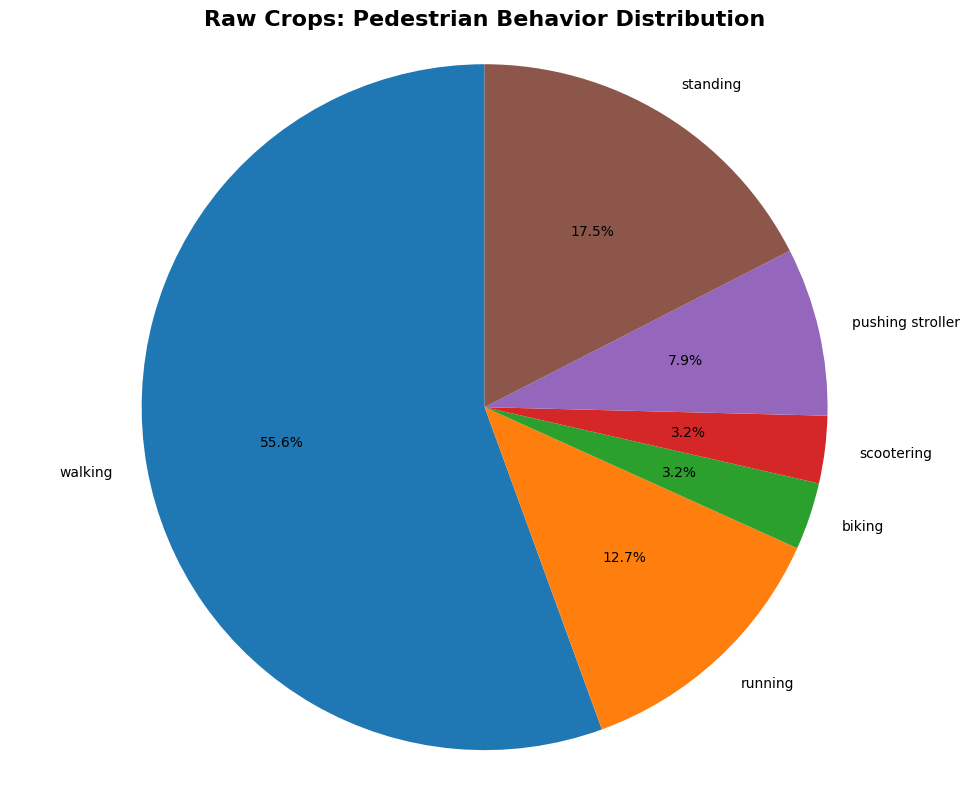


🔋 Final GPU Memory Usage: 3.41 GB / 14.7 GB
🧹 Final GPU memory cleanup completed
✅ Raw crops classification pipeline finished!


In [12]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import json
from datetime import datetime
import glob
import gc
import subprocess
import sys

def install_packages():
    """Install required packages for Qwen"""
    packages = [
        "transformers>=4.45.0",
        "accelerate",
        "tiktoken",
        "qwen-vl-utils"
    ]
    
    for package in packages:
        print(f"📦 Installing {package}...")
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", package], 
                          check=True, capture_output=True, text=True)
            print(f"✅ {package} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"⚠️ Warning installing {package}: {e}")

def clear_gpu_memory():
    """Clear GPU memory from previous models"""
    print("🧹 Clearing GPU memory from previous models...")
    
    if torch.cuda.is_available():
        # Clear any existing models from memory
        torch.cuda.empty_cache()
        gc.collect()
        
        # Force cleanup
        with torch.cuda.device(0):
            torch.cuda.empty_cache()
        
        # Check memory status
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        
        print(f"🔋 GPU Memory Status:")
        print(f"   Allocated: {allocated:.2f} GB")
        print(f"   Cached: {cached:.2f} GB") 
        print(f"   Total: {total:.2f} GB")
        print(f"   Free: {total - allocated:.2f} GB")
        print("✅ GPU memory cleared!")
    else:
        print("ℹ️ No CUDA available, skipping GPU cleanup")

def setup_qwen_vision():
    """Initialize Qwen 2.5 Vision 3B model using correct imports"""
    print("🧠 Loading Qwen 2.5 Vision 3B model...")
    
    # Install required packages first
    install_packages()
    
    # Import using correct class names from the documentation
    try:
        from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
        from qwen_vl_utils import process_vision_info
        print("✅ Imports successful")
    except ImportError as e:
        print(f"❌ Import error: {e}")
        print("🔄 Installing latest versions...")
        subprocess.run([sys.executable, "-m", "pip", "install", "transformers>=4.45.0", "qwen-vl-utils"], check=True)
        from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
        from qwen_vl_utils import process_vision_info
    
    # Check GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🖥️ Using device: {device}")
    
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        free_memory = total_memory - (torch.cuda.memory_allocated() / 1024**3)
        print(f"✅ GPU: {gpu_name} ({total_memory:.1f} GB total, {free_memory:.1f} GB free)")
    
    model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
    
    try:
        print("📥 Loading model and processor...")
        # Load using the correct method from documentation
        model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_id, 
            torch_dtype="auto", 
            device_map="auto"
        )
        
        processor = AutoProcessor.from_pretrained(model_id)
        
        if device == "cuda":
            allocated = torch.cuda.memory_allocated() / 1024**3
            print(f"🔋 GPU Memory Used by model: {allocated:.2f} GB")
        
        print(f"✅ Qwen 2.5 Vision 3B model loaded successfully!")
        return model, processor, device, process_vision_info
        
    except Exception as e:
        print(f"❌ Error loading Qwen 3B model: {e}")
        return None, None, None, None

def classify_pedestrian_behavior(image_path, model, processor, device, process_vision_info):
    """
    Classify pedestrian behavior using Qwen 2.5 Vision 3B
    """
    
    behavior_classes = [
        "walking",
        "running", 
        "biking",
        "scootering",
        "skateboarding",
        "pushing stroller",
        "standing"
    ]
    
    prompt = f"""Look at this image of a person and classify their behavior/activity. Choose from these options:
{', '.join(behavior_classes)}
Respond with only one word from the list above.

Classification:"""
    
    try:
        # Load and process the image
        image = Image.open(image_path).convert('RGB')
        
        # Prepare the conversation format for Qwen (following documentation)
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image,
                    },
                    {"type": "text", "text": prompt},
                ],
            }
        ]
        
        # Apply chat template
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        
        # Process vision info using the utility function
        image_inputs, video_inputs = process_vision_info(messages)
        
        # Process inputs
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(device)
        
        # Generate response
        with torch.no_grad():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=20,
                temperature=0.1,
                do_sample=False
            )
        
        # Decode the response (following documentation pattern)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        response = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]
        
        # Clean up the response
        classification = response.strip().lower()
        
        # Map the response to our predefined classes
        for behavior in behavior_classes:
            if behavior.lower() in classification:
                return behavior, classification
        
        # If no exact match, return the raw classification
        return classification, classification
        
    except Exception as e:
        print(f"❌ Error classifying {image_path}: {e}")
        return "error", str(e)

def load_cropped_images(crops_folder):
    """Load all cropped images from the raw crops folder"""
    
    if not os.path.exists(crops_folder):
        print(f"❌ Crops folder not found: {crops_folder}")
        return []
    
    # Find all crop images
    crop_images = []
    
    # Look for raw crop images in all frame folders
    for frame_folder in os.listdir(crops_folder):
        frame_path = os.path.join(crops_folder, frame_folder)
        if os.path.isdir(frame_path):
            raw_crops_path = os.path.join(frame_path, "raw_crops")
            if os.path.exists(raw_crops_path):
                for crop_file in os.listdir(raw_crops_path):
                    if crop_file.endswith(('.jpg', '.jpeg', '.png')):
                        crop_path = os.path.join(raw_crops_path, crop_file)
                        crop_images.append({
                            'frame_name': frame_folder,
                            'crop_filename': crop_file,
                            'crop_path': crop_path
                        })
    
    print(f"📁 Found {len(crop_images)} raw cropped images to classify")
    return crop_images

def pedestrian_behavior_classification():
    """Main function to classify pedestrian behaviors using Qwen 2.5 Vision 3B"""
    CROPS_FOLDER = '/kaggle/working/expanded_crops_results'
    OUTPUT_FOLDER = '/kaggle/working/classification_results'
    MAX_IMAGES_TO_SHOW = 100
    
    print("🧠 QWEN 2.5 VISION 3B PEDESTRIAN BEHAVIOR CLASSIFICATION")
    print("=" * 70)
    print(f"📁 Crops folder: {CROPS_FOLDER}")
    print(f"📁 Output folder: {OUTPUT_FOLDER}")
    print(f"🎯 Behavior classes: walking, running, biking, scootering, pushing stroller, standing")
    print("=" * 70)
    
    # Clear GPU memory from previous models (like DINO)
    clear_gpu_memory()
    
    # Initialize Qwen 3B model
    model, processor, device, process_vision_info = setup_qwen_vision()
    if model is None:
        print("❌ Failed to load Qwen 3B model. Stopping classification.")
        return
    
    # Load cropped images
    crop_images = load_cropped_images(CROPS_FOLDER)
    if not crop_images:
        print("❌ No raw cropped images found. Make sure to run the detection pipeline first.")
        return
    
    # Create output directory
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    # Classification results storage
    classification_results = []
    behavior_counts = {
        'walking': 0,
        'running': 0,
        'biking': 0,
        'scootering': 0,
        'skateboarding':0,
        'pushing stroller': 0,
        'standing': 0,
        'other': 0,
        'error': 0
    }
    
    print(f"\n🚀 Starting raw crops classification of {len(crop_images)} pedestrian images...")
    print("=" * 70)
    
    images_shown = 0
    
    for i, crop_info in enumerate(crop_images, 1):
        frame_name = crop_info['frame_name']
        crop_filename = crop_info['crop_filename']
        crop_path = crop_info['crop_path']
        
        print(f"\n📊 PROGRESS: {i}/{len(crop_images)} ({i/len(crop_images)*100:.1f}%)")
        print(f"🖼️ Frame: {frame_name} | Image: {crop_filename}")
        
        try:
            # Classify the pedestrian behavior
            classification, raw_response = classify_pedestrian_behavior(
                crop_path, model, processor, device, process_vision_info
            )
            
            # Store results
            result = {
                'frame_name': frame_name,
                'crop_filename': crop_filename,
                'crop_path': crop_path,
                'classification': classification,
                'raw_response': raw_response,
                'timestamp': datetime.now().isoformat()
            }
            classification_results.append(result)
            
            # Update counts
            if classification in behavior_counts:
                behavior_counts[classification] += 1
            elif classification == 'error':
                behavior_counts['error'] += 1
            else:
                behavior_counts['other'] += 1
            
            print(f"🎯 Classification: {classification}")
            print(f"💬 Response: {raw_response}")
            
            if images_shown < MAX_IMAGES_TO_SHOW:
                try:
                    img = Image.open(crop_path)
                    plt.figure(figsize=(6, 8))
                    plt.imshow(img)
                    plt.title(f"Frame: {frame_name}\nClassification: {classification}\nResponse: {raw_response}", 
                             fontsize=12, fontweight='bold')
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                    images_shown += 1
                except Exception as e:
                    print(f"❌ Error displaying image: {e}")
            
            # Clean GPU memory more frequently
            if device == "cuda" and i % 3 == 0:
                torch.cuda.empty_cache()
                allocated = torch.cuda.memory_allocated() / 1024**3
                print(f"🔋 Current GPU usage: {allocated:.2f} GB")
                
        except Exception as e:
            print(f"❌ Error processing {crop_filename}: {e}")
            behavior_counts['error'] += 1
            # Clean memory on error
            if device == "cuda":
                torch.cuda.empty_cache()
    
    # Save classification results
    results_summary = {
        'classification_info': {
            'model_used': 'Qwen/Qwen2.5-VL-3B-Instruct',
            'crop_type': 'raw_crops',
            'total_images': len(crop_images),
            'classified_images': len(classification_results),
            'behavior_classes': list(behavior_counts.keys()),
            'processing_date': datetime.now().isoformat()
        },
        'behavior_statistics': behavior_counts,
        'detailed_results': classification_results
    }
    
    # Save results to file
    results_path = os.path.join(OUTPUT_FOLDER, 'raw_crops_behavior_classification_results.json')
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"\n{'🎉'*50}")
    print(f"🎉 RAW CROPS BEHAVIOR CLASSIFICATION COMPLETE!")
    print(f"{'🎉'*50}")
    
    # Display final statistics
    print(f"\n📊 RAW CROPS CLASSIFICATION STATISTICS:")
    print("=" * 50)
    total_classified = sum(behavior_counts.values())
    
    for behavior, count in behavior_counts.items():
        percentage = (count / total_classified * 100) if total_classified > 0 else 0
        print(f"   {behavior.title()}: {count} ({percentage:.1f}%)")
    
    print(f"\n📁 Results saved to: {results_path}")
    print(f"🖼️ Total raw crop images classified: {len(classification_results)}")
    print(f"📈 Success rate: {(len(classification_results)/len(crop_images)*100):.1f}%")
    
    # Create behavior distribution pie chart
    plt.figure(figsize=(10, 8))
    behaviors = list(behavior_counts.keys())
    counts = list(behavior_counts.values())
    
    # Filter out zero counts for better visualization
    non_zero_behaviors = [(b, c) for b, c in zip(behaviors, counts) if c > 0]
    if non_zero_behaviors:
        behaviors, counts = zip(*non_zero_behaviors)
        
        plt.pie(counts, labels=behaviors, autopct='%1.1f%%', startangle=90)
        plt.title('Raw Crops: Pedestrian Behavior Distribution', fontsize=16, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    
    # Final memory status
    if device == "cuda":
        allocated = torch.cuda.memory_allocated() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"\n🔋 Final GPU Memory Usage: {allocated:.2f} GB / {total:.1f} GB")
        
        # Clean GPU memory
        torch.cuda.empty_cache()
        print("🧹 Final GPU memory cleanup completed")
    
    print(f"✅ Raw crops classification pipeline finished!")

# Run the pedestrian behavior classification on raw crops
pedestrian_behavior_classification()

🤖 ORIGINAL BLIP CAPTIONING + BART CLASSIFICATION PIPELINE
📁 Crops folder: /kaggle/working/expanded_crops_results
📁 Output folder: /kaggle/working/blip_bart_classification_results
🎯 Behavior classes: walking, running, biking, scootering, pushing stroller, standing
📝 Method: Original BLIP generates captions → BART classifies captions
🧹 Clearing GPU memory from previous models...
🔋 GPU Memory Status:
   Allocated: 2.40 GB
   Cached: 3.99 GB
   Total: 14.74 GB
   Free: 12.34 GB
✅ GPU memory cleared!
🤖 Setting up BLIP (original) + BART classification pipeline...
🖥️ Using device: cuda
✅ GPU 0: Tesla T4 (14.7 GB total, 12.3 GB free)
✅ Required imports successful
📥 Loading original BLIP Salesforce/blip-image-captioning-large for captioning...
✅ Original BLIP loaded for captioning!
📥 Loading BART for text classification...


Device set to use cuda:0


✅ BART classifier loaded!
🔋 GPU 0 Memory Used: 4.79 GB
📁 Found 63 raw cropped images to classify

🚀 Starting BLIP + BART classification of 63 pedestrian images...

📊 PROGRESS: 1/63 (1.6%)
🖼️ Frame: frame_000062 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of two people standing next to each other'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a blurry photo of two people standing next to each other
   🔥 Confidence: 0.866


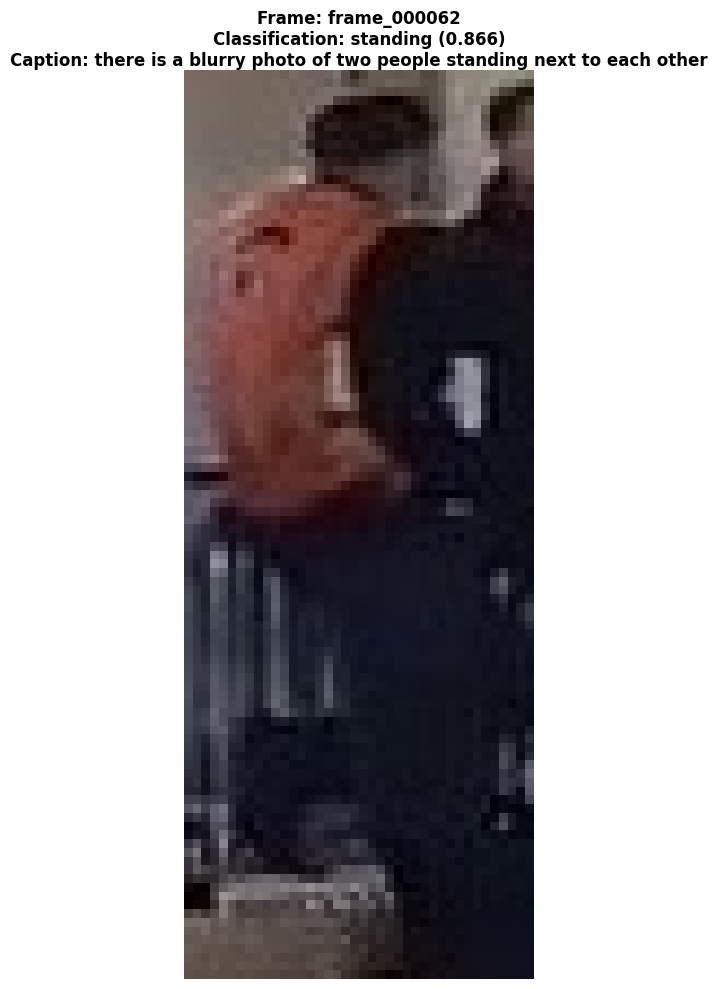


📊 PROGRESS: 2/63 (3.2%)
🖼️ Frame: frame_000062 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a person riding a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a blurry image of a person riding a skateboard
   🔥 Confidence: 0.947


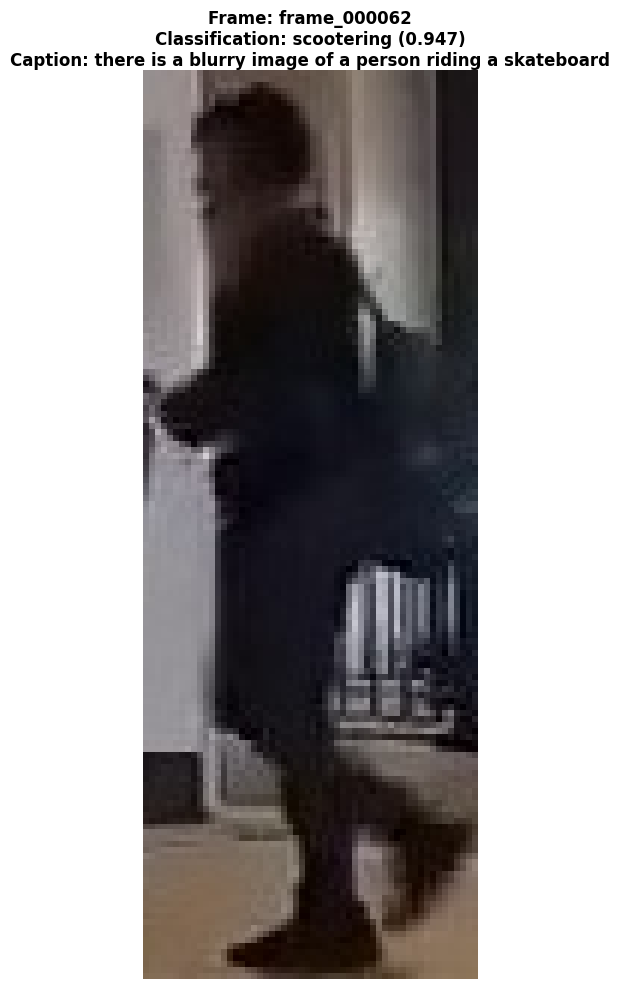


📊 PROGRESS: 3/63 (4.8%)
🖼️ Frame: frame_000062 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man riding a skateboard with a backpack on his back'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a man riding a skateboard with a backpack on his back
   🔥 Confidence: 0.830


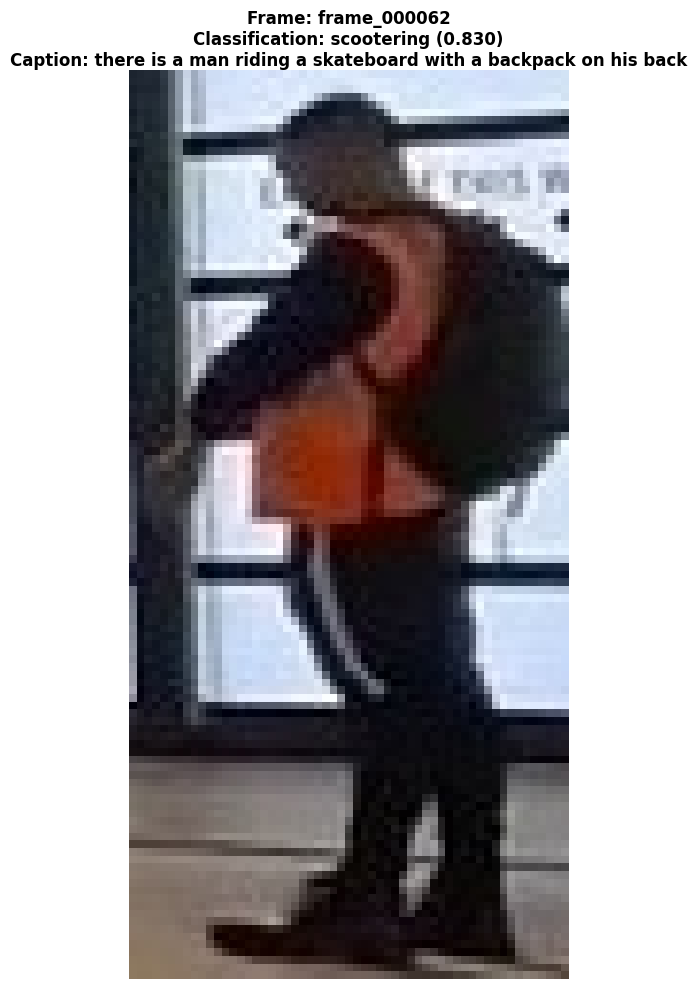


📊 PROGRESS: 4/63 (6.3%)
🖼️ Frame: frame_000062 | Image: person_6_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man in a black jacket standing in front of a window'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: this is an image of a man in a black jacket standing in front of a window
   🔥 Confidence: 0.991


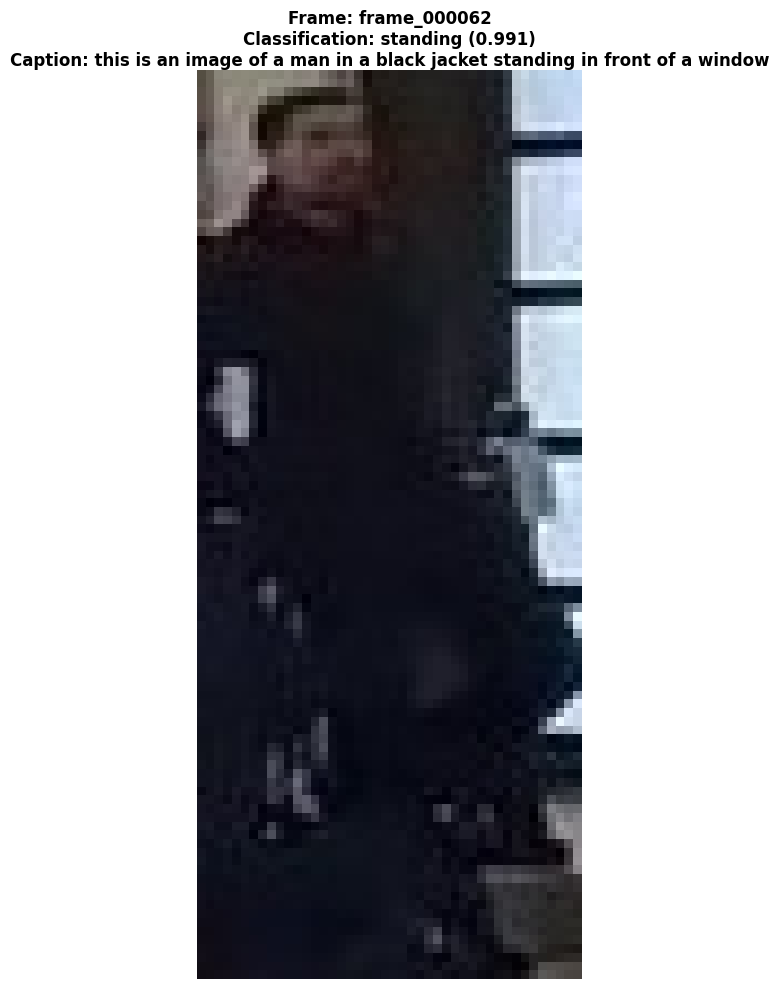


📊 PROGRESS: 5/63 (7.9%)
🖼️ Frame: frame_000062 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of a man riding a motorcycle'
   🎯 Classifying caption...
   🎯 Final Classification: biking
   📝 Caption: there is a blurry photo of a man riding a motorcycle
   🔥 Confidence: 0.983


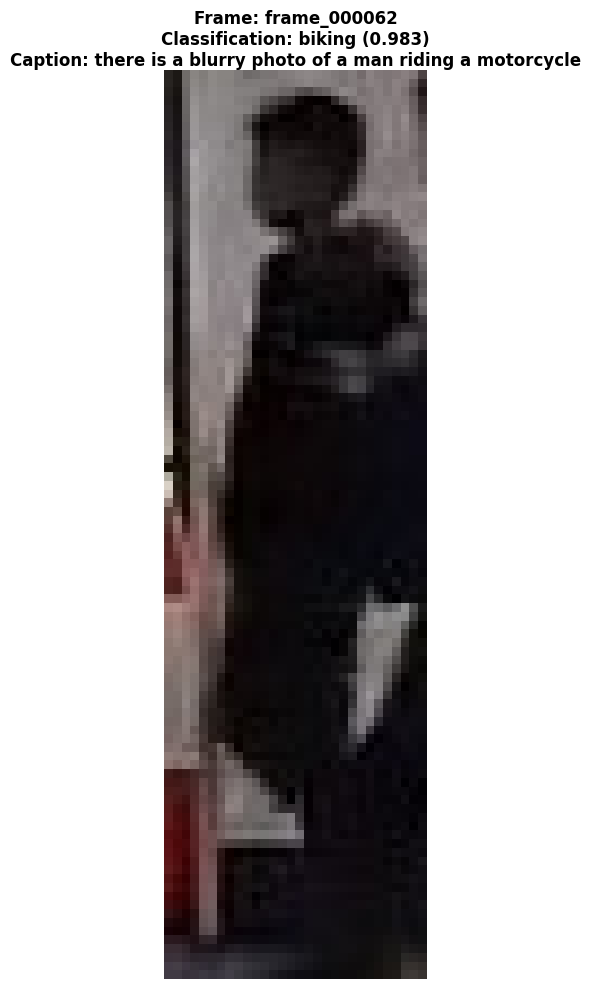

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 6/63 (9.5%)
🖼️ Frame: frame_000062 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there are two people that are walking in the hallway together'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there are two people that are walking in the hallway together
   🔥 Confidence: 0.981


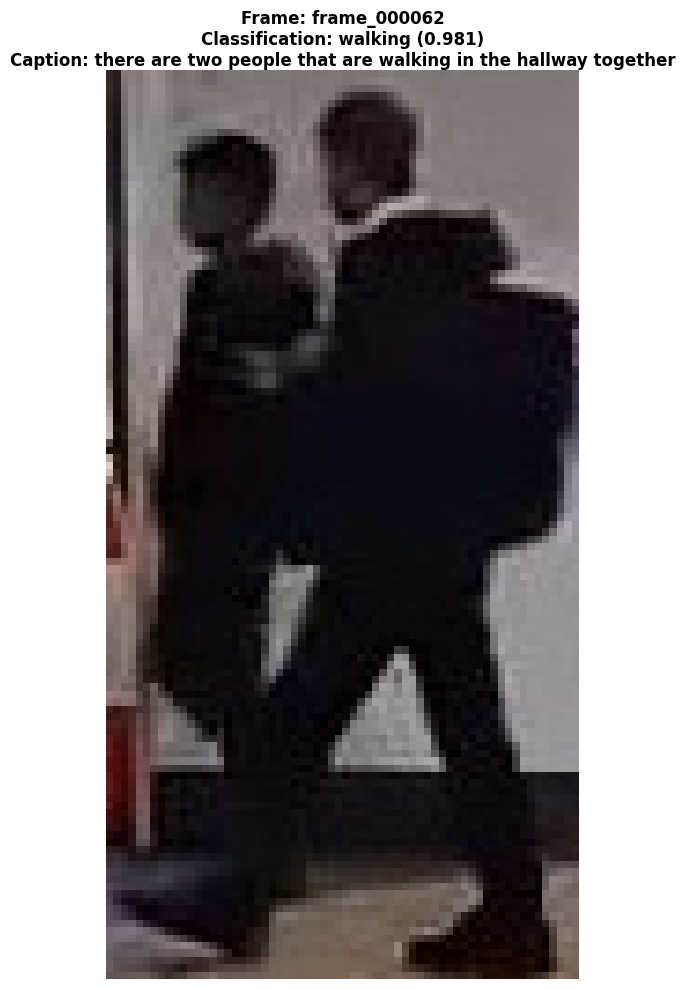


📊 PROGRESS: 7/63 (11.1%)
🖼️ Frame: frame_000025 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street talking on a cell phone'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street talking on a cell phone
   🔥 Confidence: 0.990


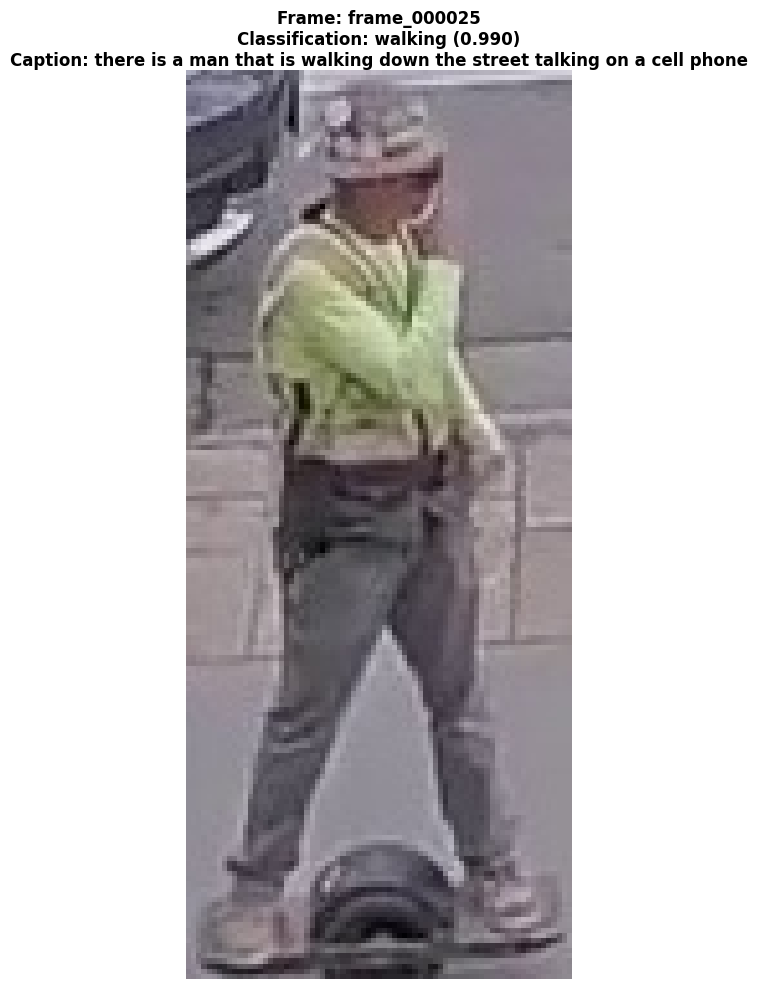


📊 PROGRESS: 8/63 (12.7%)
🖼️ Frame: frame_000069 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is running down the street with a tennis racket'
   🎯 Classifying caption...
   🎯 Final Classification: running
   📝 Caption: there is a woman that is running down the street with a tennis racket
   🔥 Confidence: 0.993


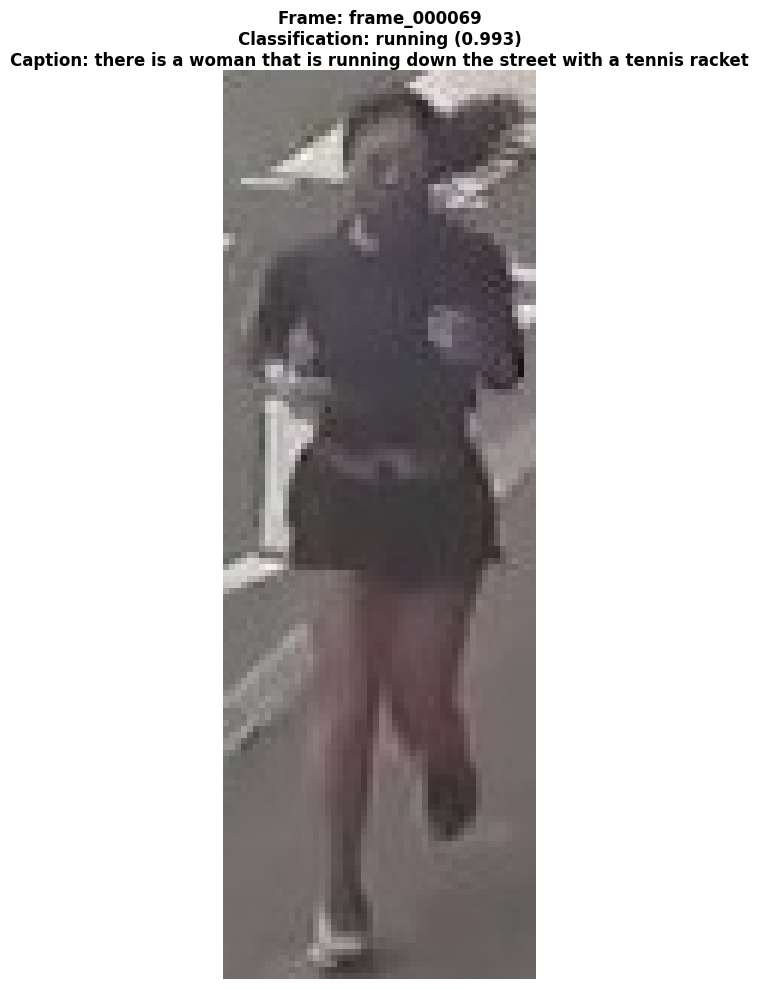


📊 PROGRESS: 9/63 (14.3%)
🖼️ Frame: frame_000069 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking on the beach with a surfboard'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking on the beach with a surfboard
   🔥 Confidence: 0.983


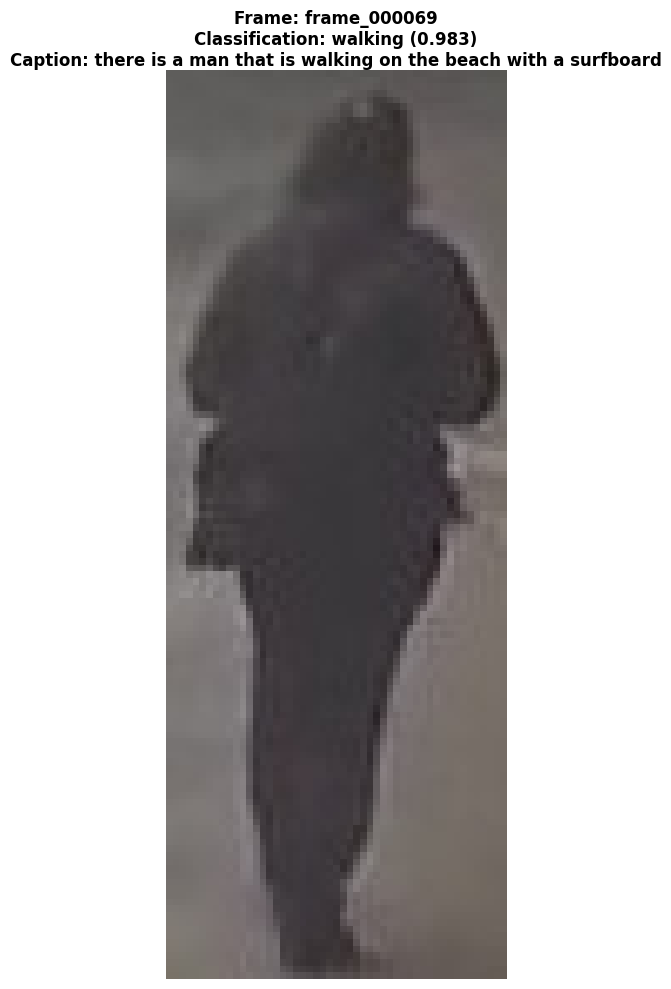


📊 PROGRESS: 10/63 (15.9%)
🖼️ Frame: frame_000028 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a man riding a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a blurry image of a man riding a skateboard
   🔥 Confidence: 0.948


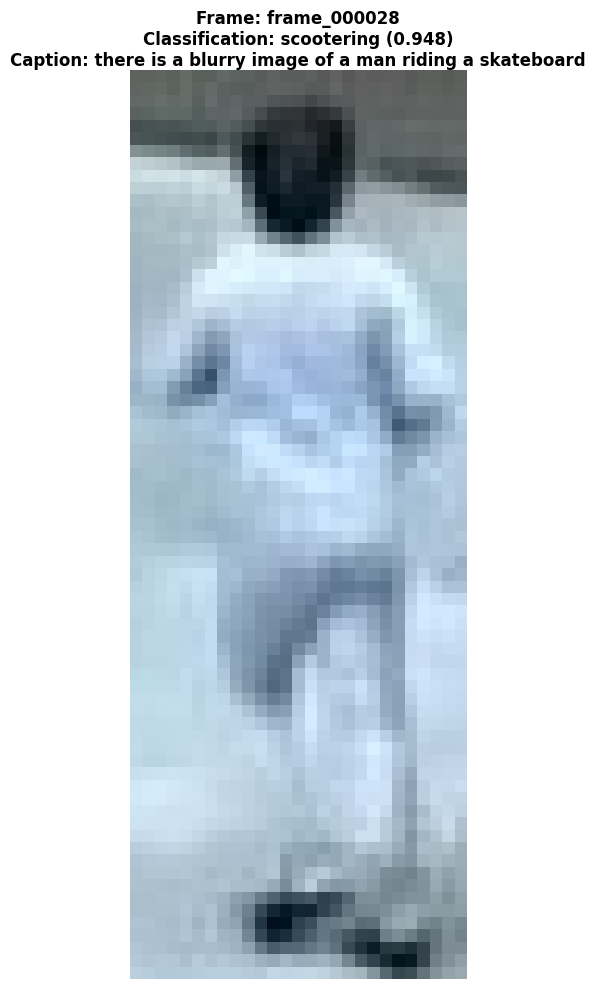

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 11/63 (17.5%)
🖼️ Frame: frame_000028 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man in a space suit walking down the street'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: this is an image of a man in a space suit walking down the street
   🔥 Confidence: 0.523


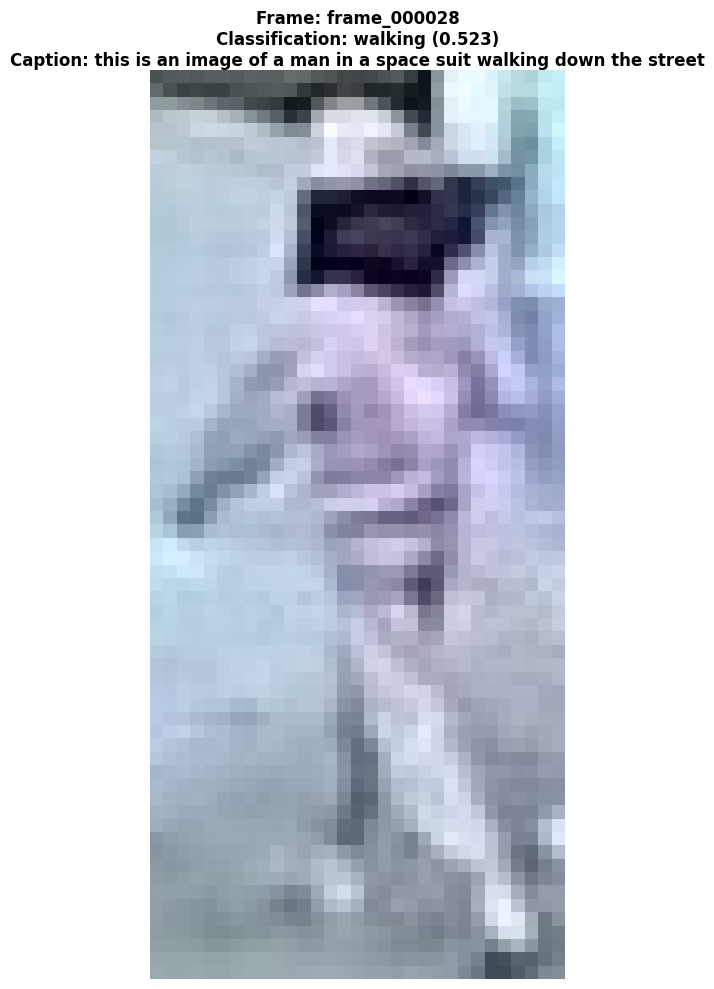


📊 PROGRESS: 12/63 (19.0%)
🖼️ Frame: frame_000028 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a person on a snowboard'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a blurry image of a person on a snowboard
   🔥 Confidence: 0.232


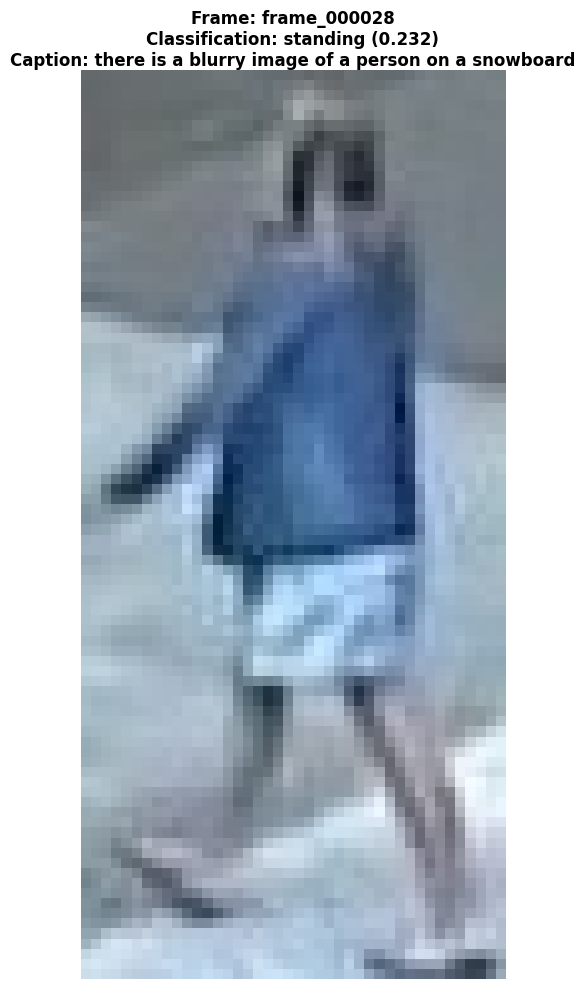


📊 PROGRESS: 13/63 (20.6%)
🖼️ Frame: frame_000028 | Image: person_6_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a skateboard
   🔥 Confidence: 0.654


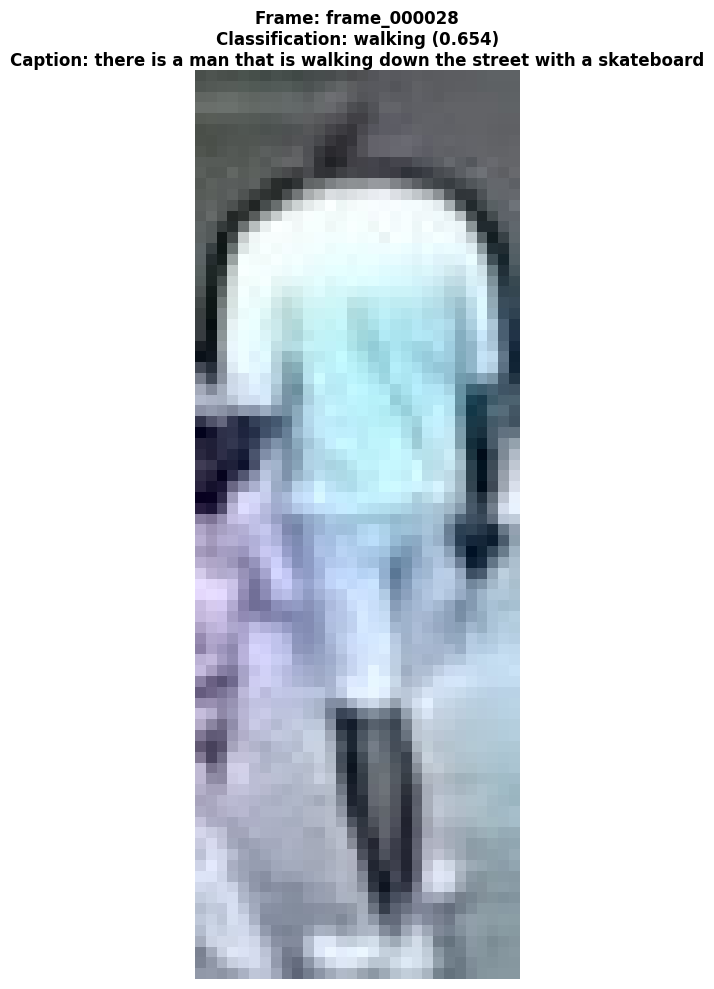


📊 PROGRESS: 14/63 (22.2%)
🖼️ Frame: frame_000028 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man riding a skateboard down a street next to a parking meter'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a man riding a skateboard down a street next to a parking meter
   🔥 Confidence: 0.900


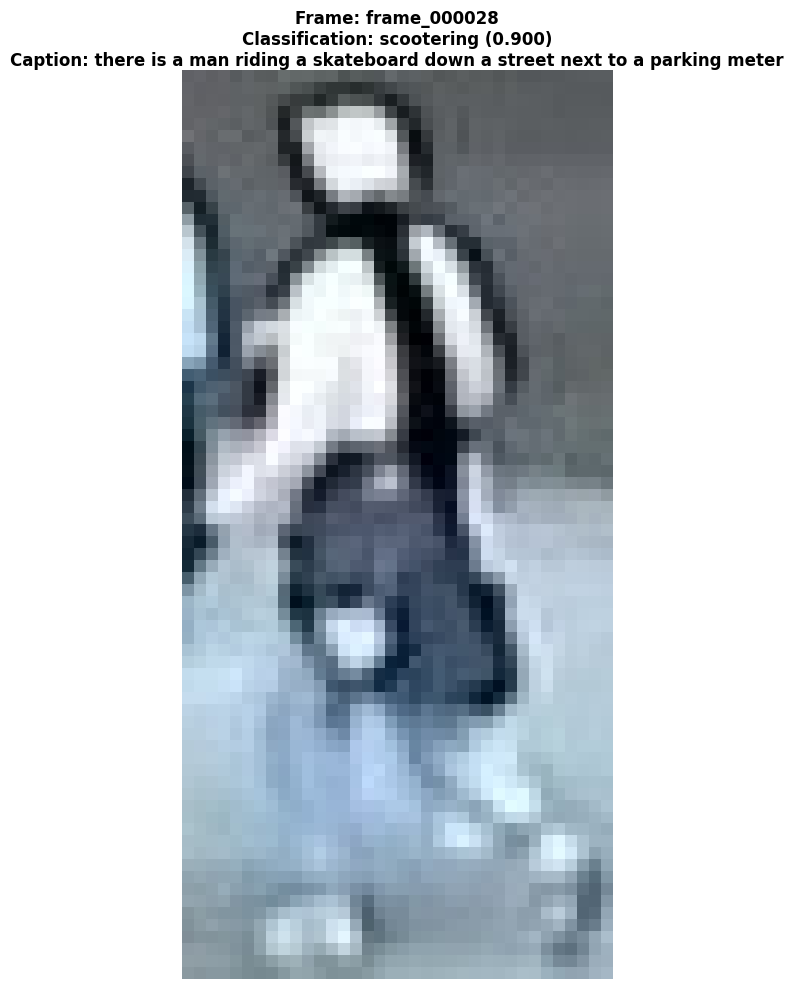


📊 PROGRESS: 15/63 (23.8%)
🖼️ Frame: frame_000028 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a skateboard
   🔥 Confidence: 0.654


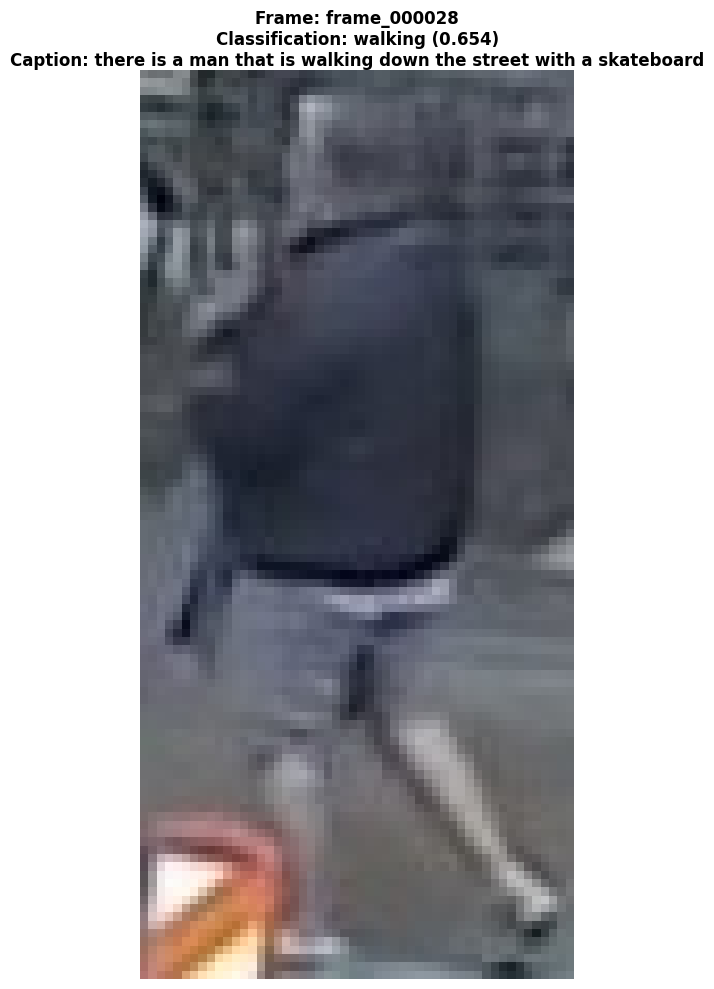

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 16/63 (25.4%)
🖼️ Frame: frame_000000 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man riding a skateboard down the street'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a man riding a skateboard down the street
   🔥 Confidence: 0.863


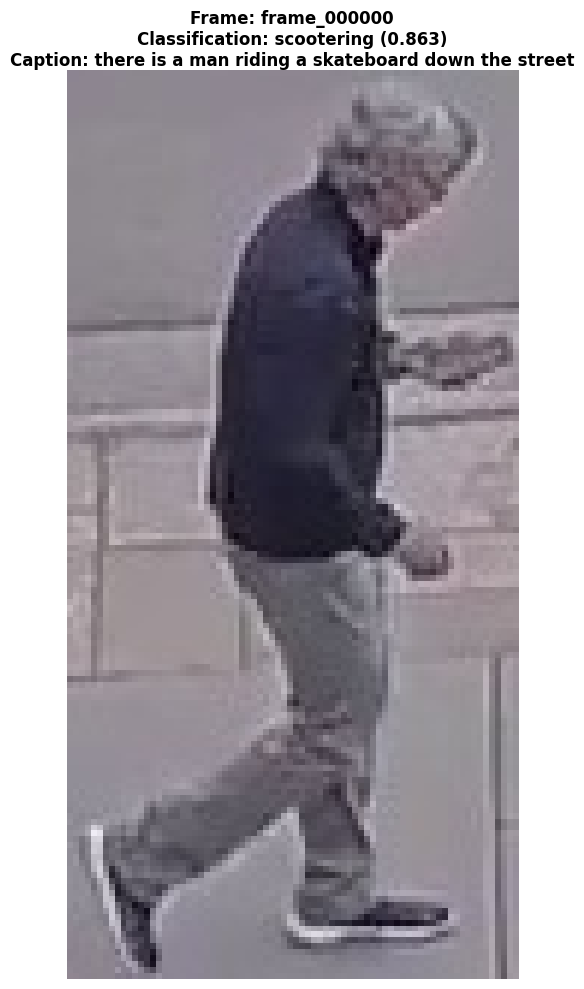


📊 PROGRESS: 17/63 (27.0%)
🖼️ Frame: frame_000027 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man riding a skateboard down the street'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: this is an image of a man riding a skateboard down the street
   🔥 Confidence: 0.931


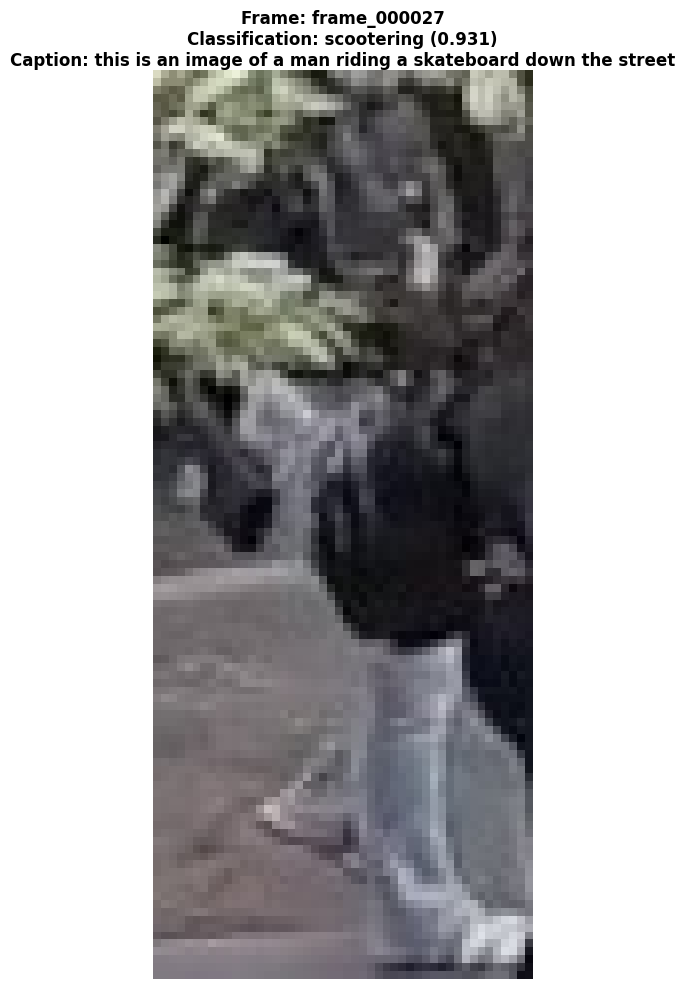


📊 PROGRESS: 18/63 (28.6%)
🖼️ Frame: frame_000027 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man walking a dog on a leash down the street'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man walking a dog on a leash down the street
   🔥 Confidence: 0.978


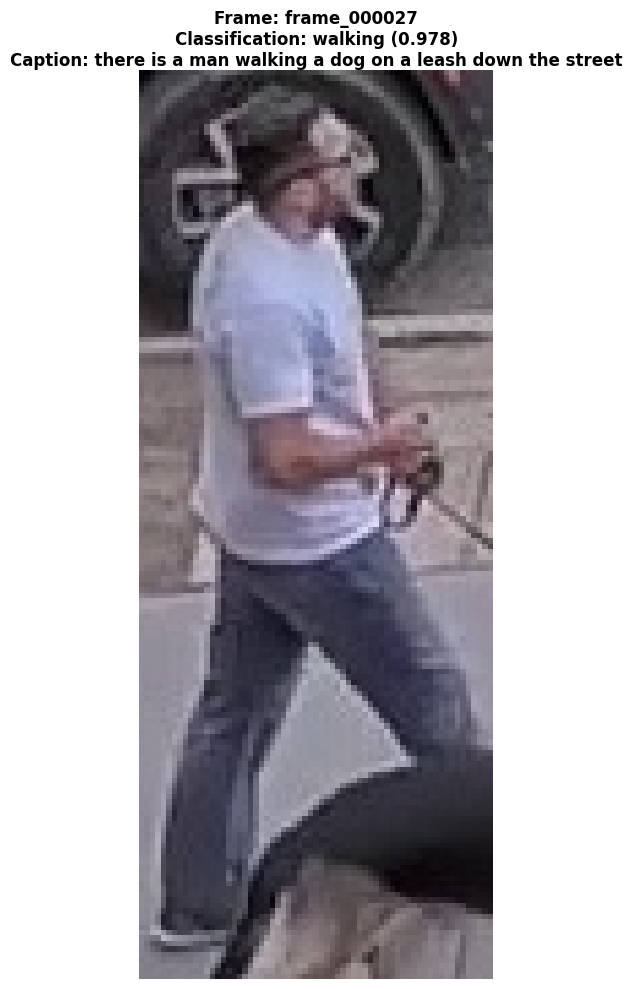


📊 PROGRESS: 19/63 (30.2%)
🖼️ Frame: frame_000027 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a bag on his back'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a bag on his back
   🔥 Confidence: 0.991


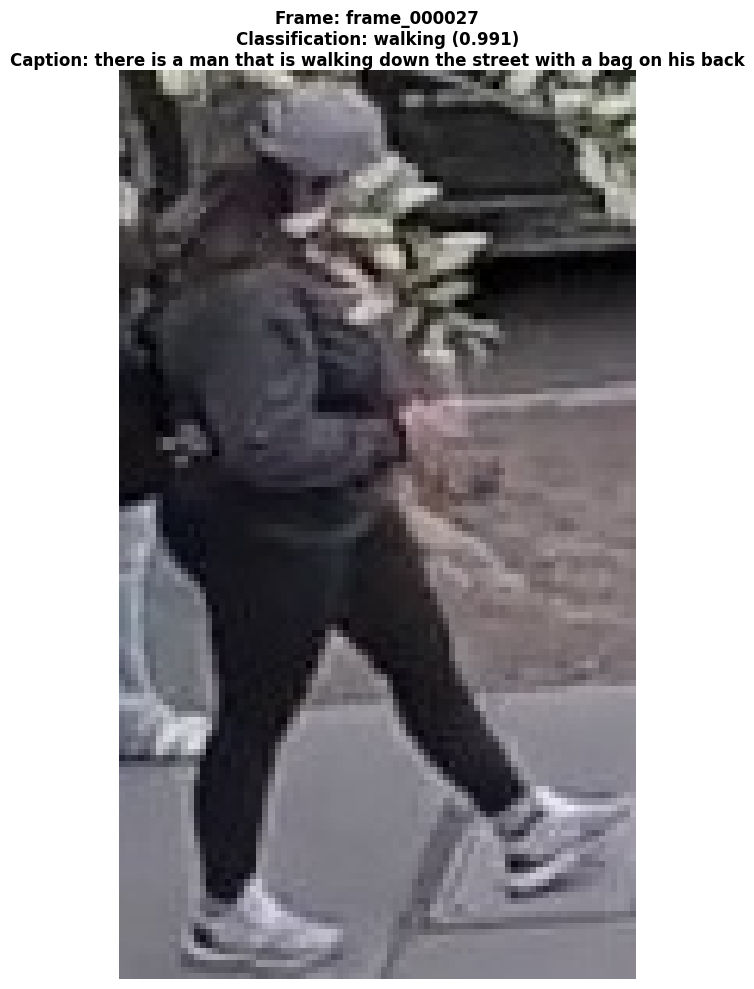


📊 PROGRESS: 20/63 (31.7%)
🖼️ Frame: frame_000096 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is a blurry photo of a man walking down the street'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: this is a blurry photo of a man walking down the street
   🔥 Confidence: 0.991


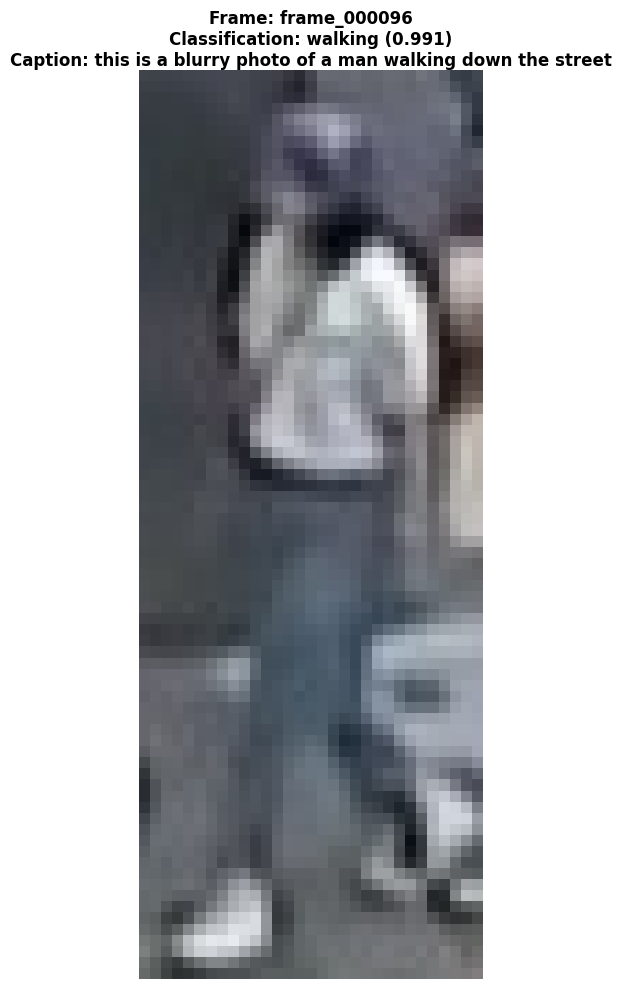

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 21/63 (33.3%)
🖼️ Frame: frame_000096 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of a person riding a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a blurry photo of a person riding a skateboard
   🔥 Confidence: 0.912


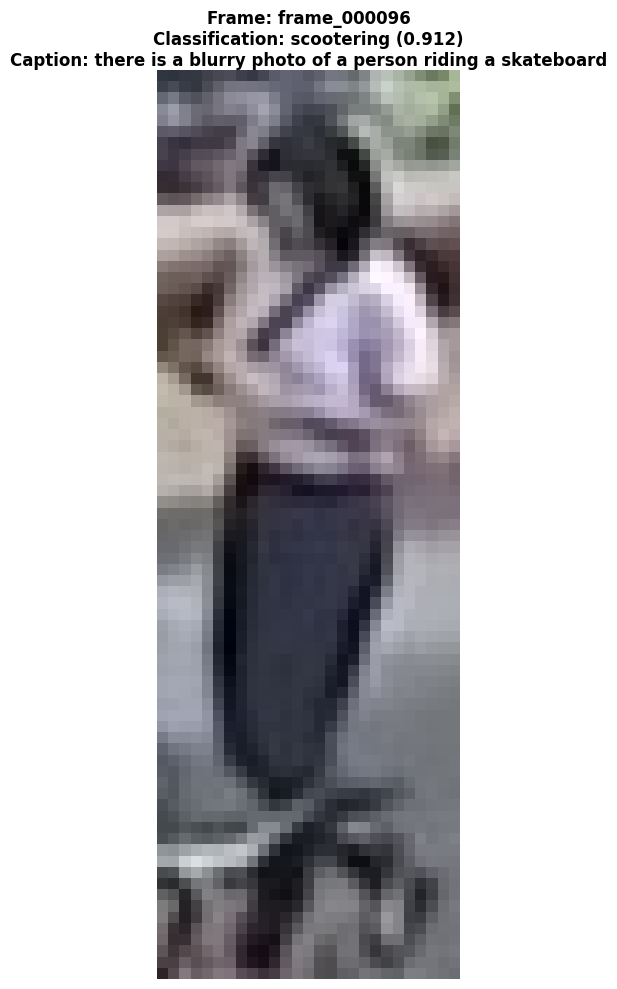


📊 PROGRESS: 22/63 (34.9%)
🖼️ Frame: frame_000096 | Image: person_7_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of a woman riding a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a blurry photo of a woman riding a skateboard
   🔥 Confidence: 0.930


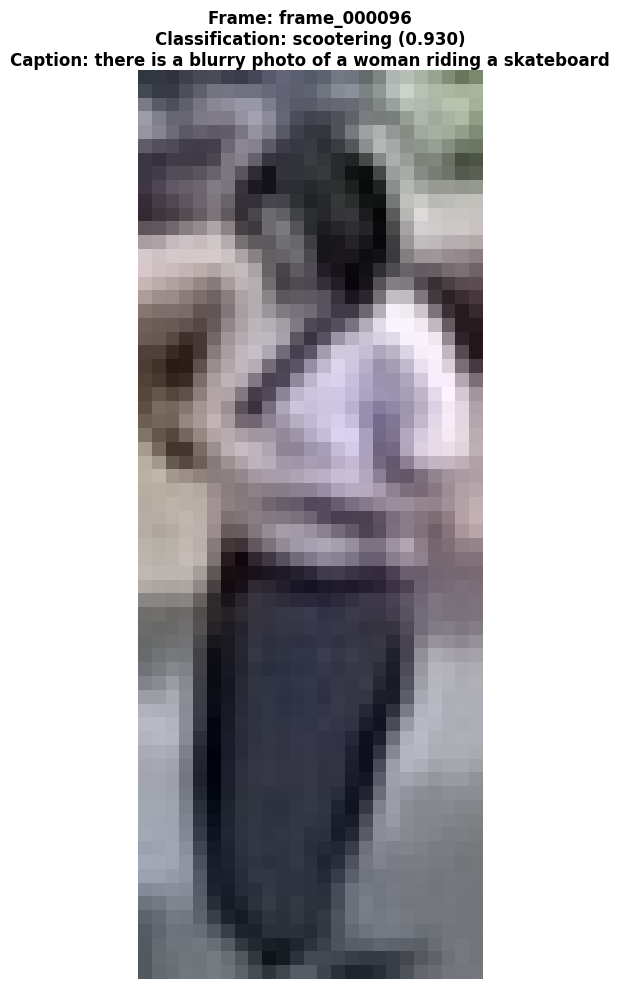


📊 PROGRESS: 23/63 (36.5%)
🖼️ Frame: frame_000096 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is a blurry photo of a man holding a baseball bat'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: this is a blurry photo of a man holding a baseball bat
   🔥 Confidence: 0.352


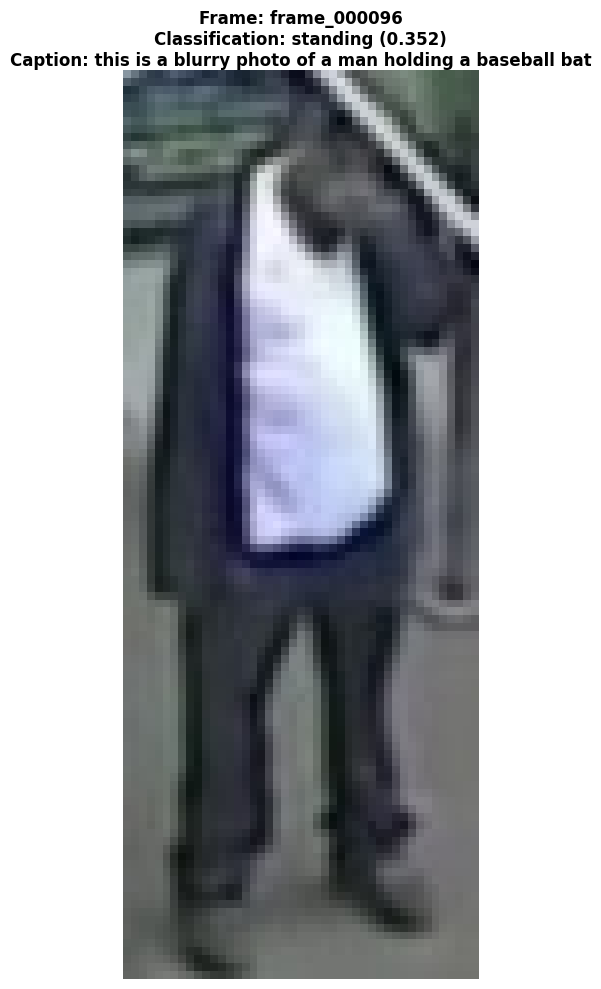


📊 PROGRESS: 24/63 (38.1%)
🖼️ Frame: frame_000096 | Image: person_6_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a man walking down the street'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a blurry image of a man walking down the street
   🔥 Confidence: 0.987


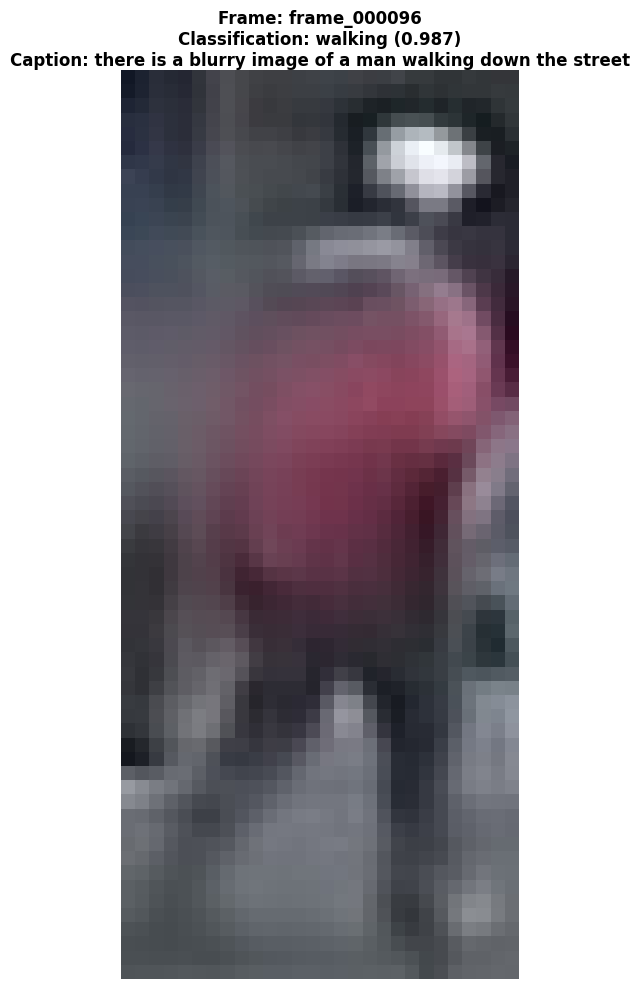


📊 PROGRESS: 25/63 (39.7%)
🖼️ Frame: frame_000096 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of a person walking down the street with an umbrella'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a blurry photo of a person walking down the street with an umbrella
   🔥 Confidence: 0.990


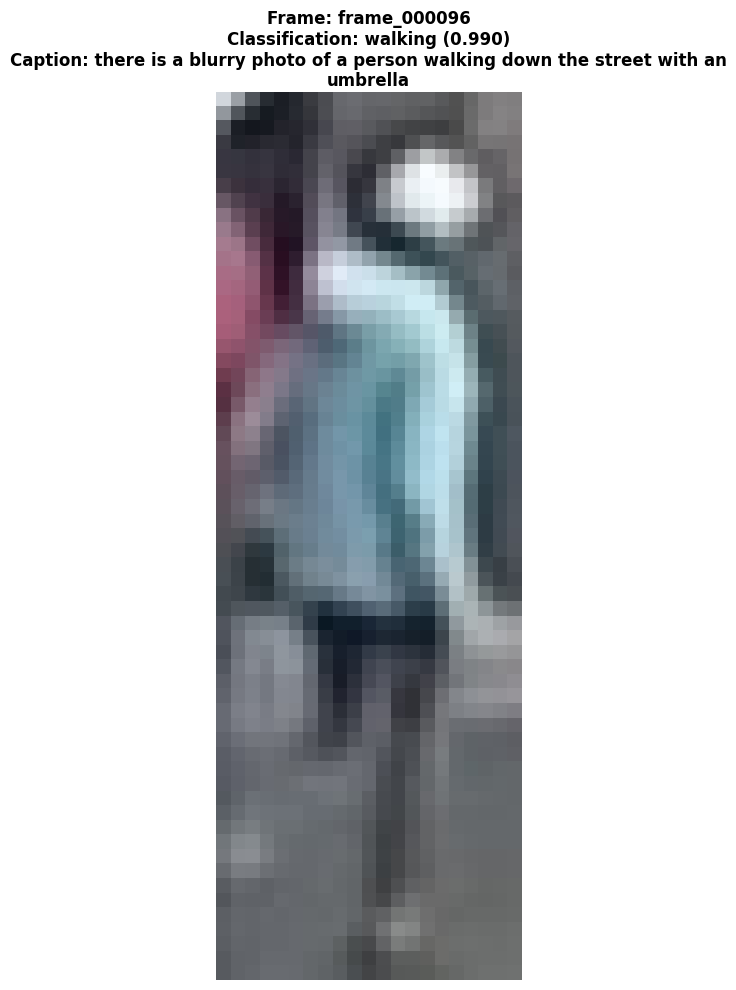

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 26/63 (41.3%)
🖼️ Frame: frame_000096 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man in a white t - shirt and gray pants'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: this is an image of a man in a white t - shirt and gray pants
   🔥 Confidence: 0.581


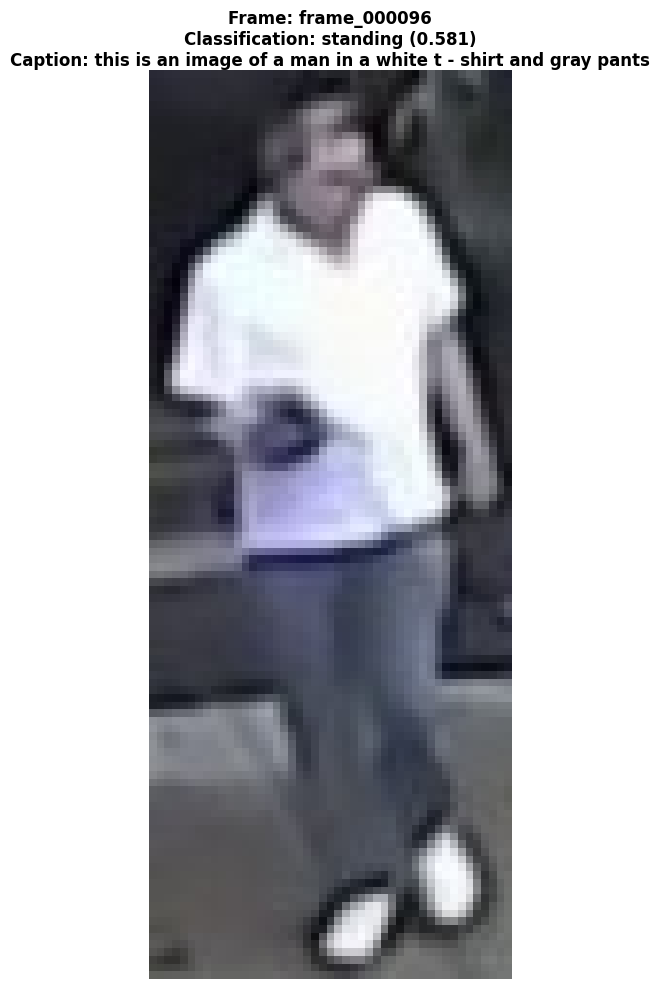


📊 PROGRESS: 27/63 (42.9%)
🖼️ Frame: frame_000014 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man in a green jacket on a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: this is an image of a man in a green jacket on a skateboard
   🔥 Confidence: 0.951


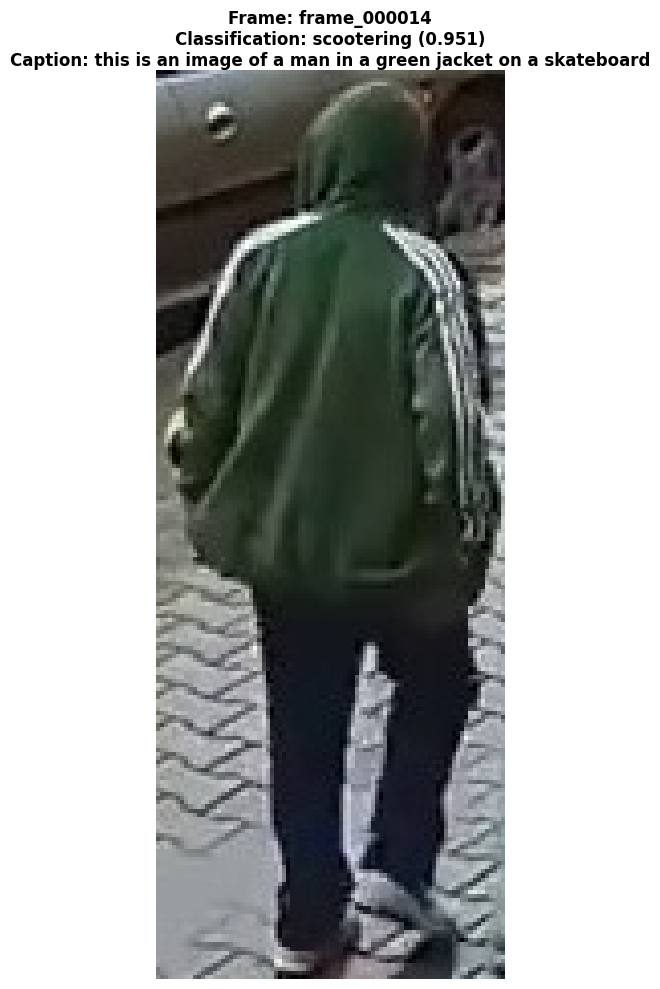


📊 PROGRESS: 28/63 (44.4%)
🖼️ Frame: frame_000014 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man walking down the street with an umbrella'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man walking down the street with an umbrella
   🔥 Confidence: 0.991


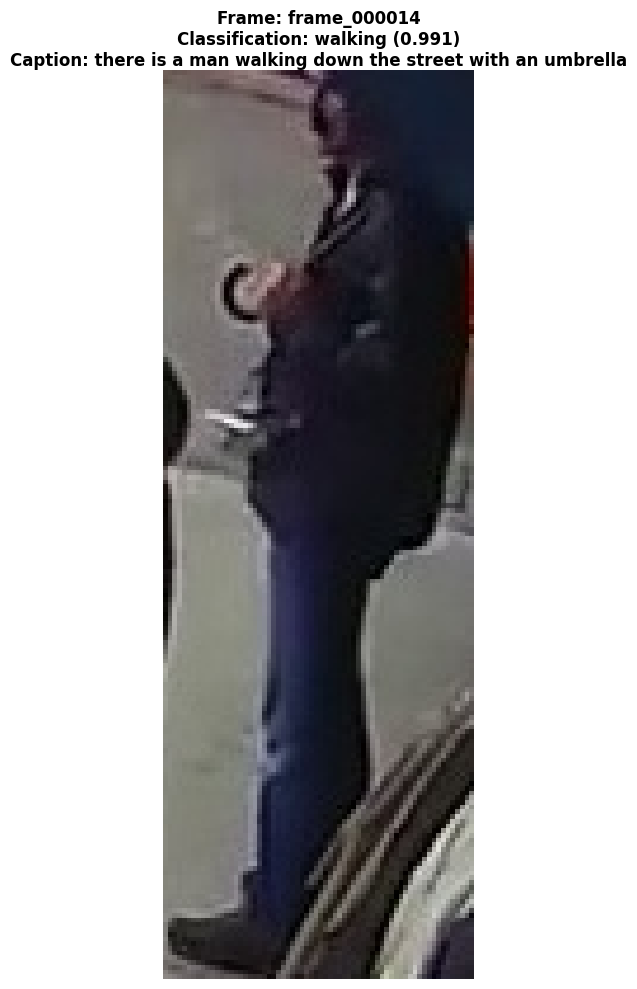


📊 PROGRESS: 29/63 (46.0%)
🖼️ Frame: frame_000014 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man walking down the street with a cane'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: this is an image of a man walking down the street with a cane
   🔥 Confidence: 0.991


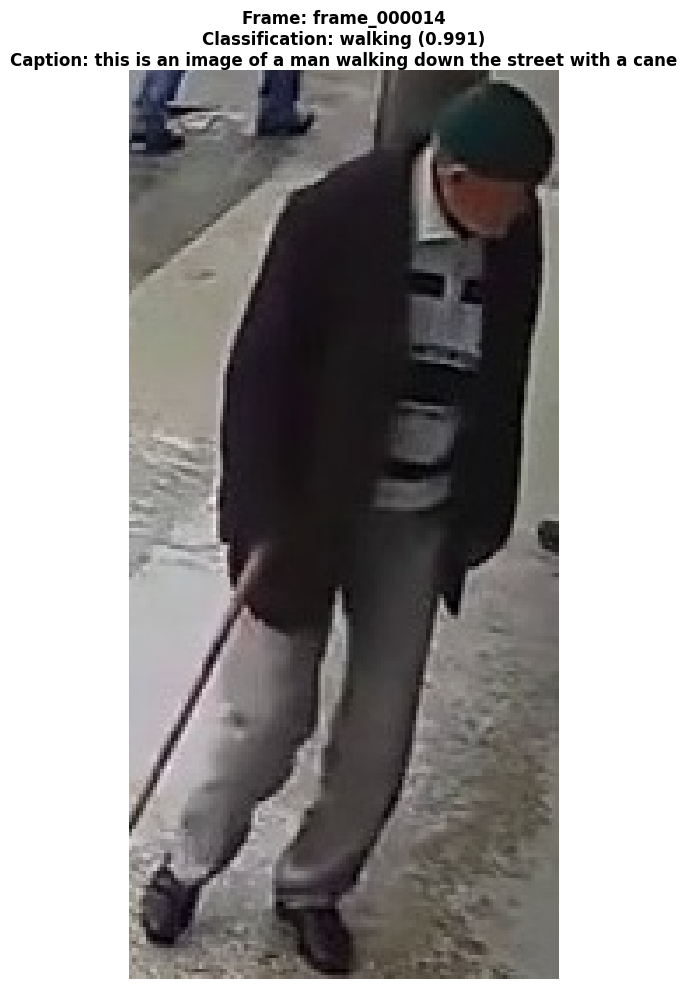


📊 PROGRESS: 30/63 (47.6%)
🖼️ Frame: frame_000014 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is standing on a skateboard in the street'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a man that is standing on a skateboard in the street
   🔥 Confidence: 0.598


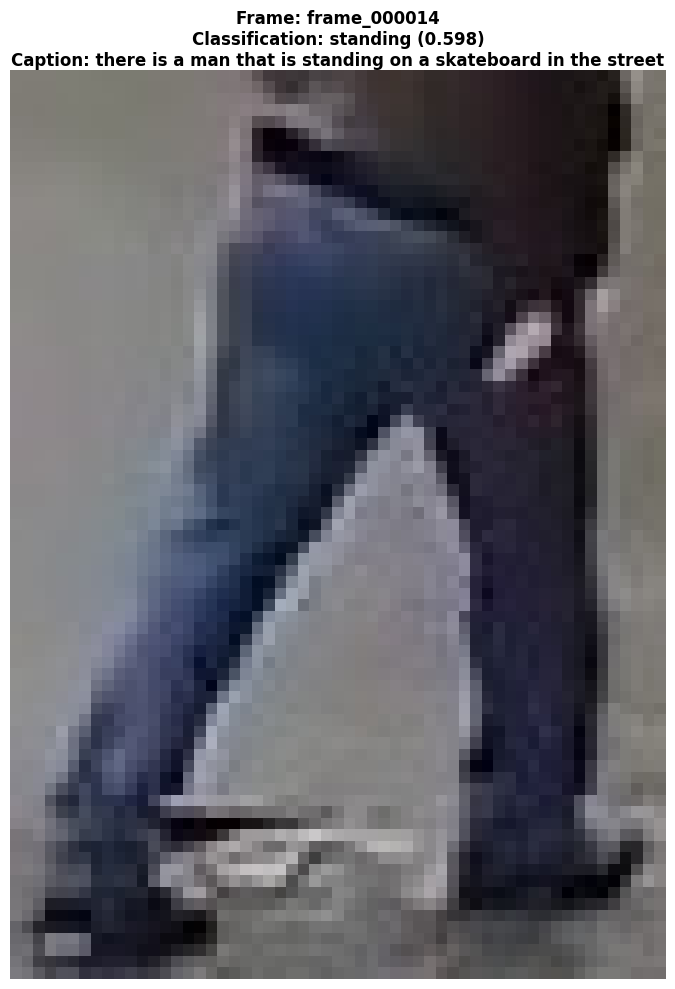

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 31/63 (49.2%)
🖼️ Frame: frame_000014 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man and a woman walking down the street in the rain'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man and a woman walking down the street in the rain
   🔥 Confidence: 0.989


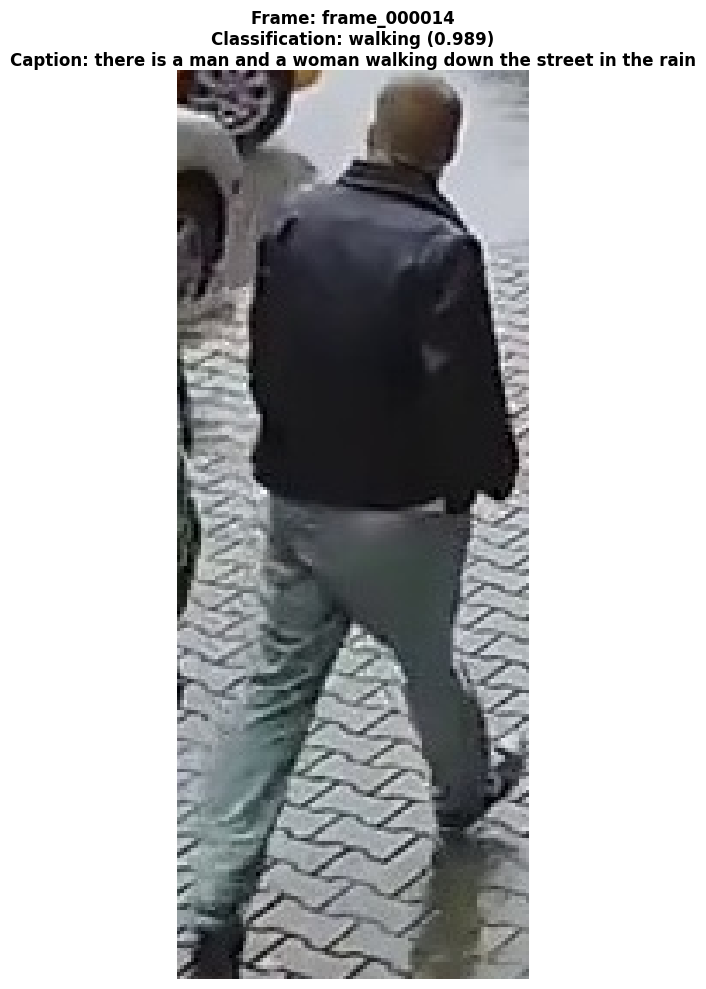


📊 PROGRESS: 32/63 (50.8%)
🖼️ Frame: frame_000081 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a frisbee'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a frisbee
   🔥 Confidence: 0.991


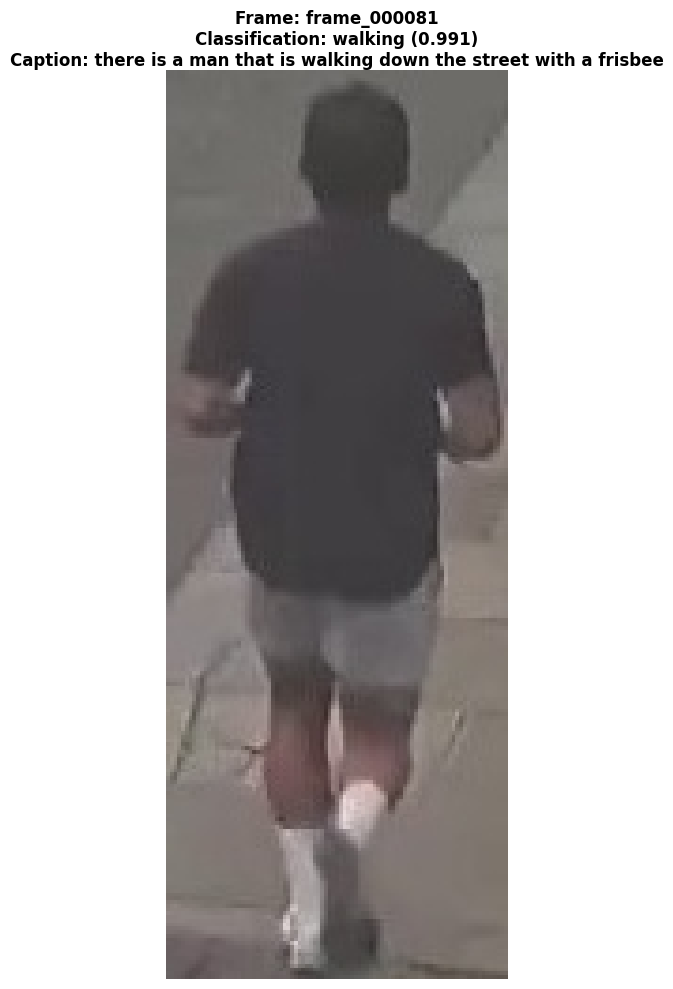


📊 PROGRESS: 33/63 (52.4%)
🖼️ Frame: frame_000081 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a man riding a skateboard down the street'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a blurry image of a man riding a skateboard down the street
   🔥 Confidence: 0.949


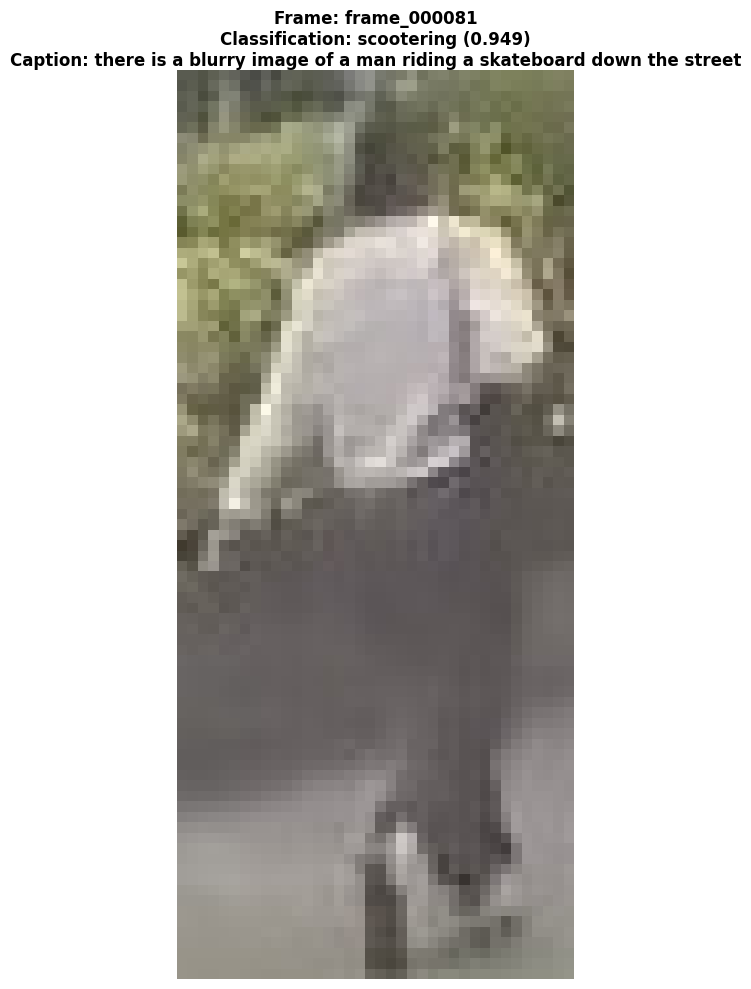


📊 PROGRESS: 34/63 (54.0%)
🖼️ Frame: frame_000030 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of a motorcycle that is in the water'
   🎯 Classifying caption...
   🎯 Final Classification: biking
   📝 Caption: there is a blurry photo of a motorcycle that is in the water
   🔥 Confidence: 0.818


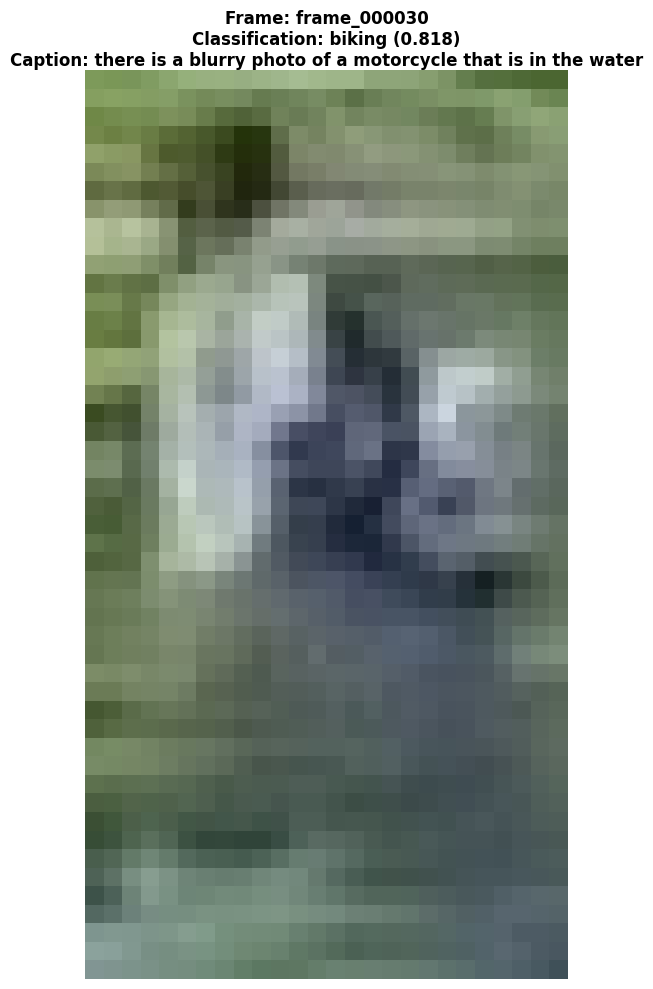


📊 PROGRESS: 35/63 (55.6%)
🖼️ Frame: frame_000030 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman walking a dog in the rain with an umbrella'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a woman walking a dog in the rain with an umbrella
   🔥 Confidence: 0.983


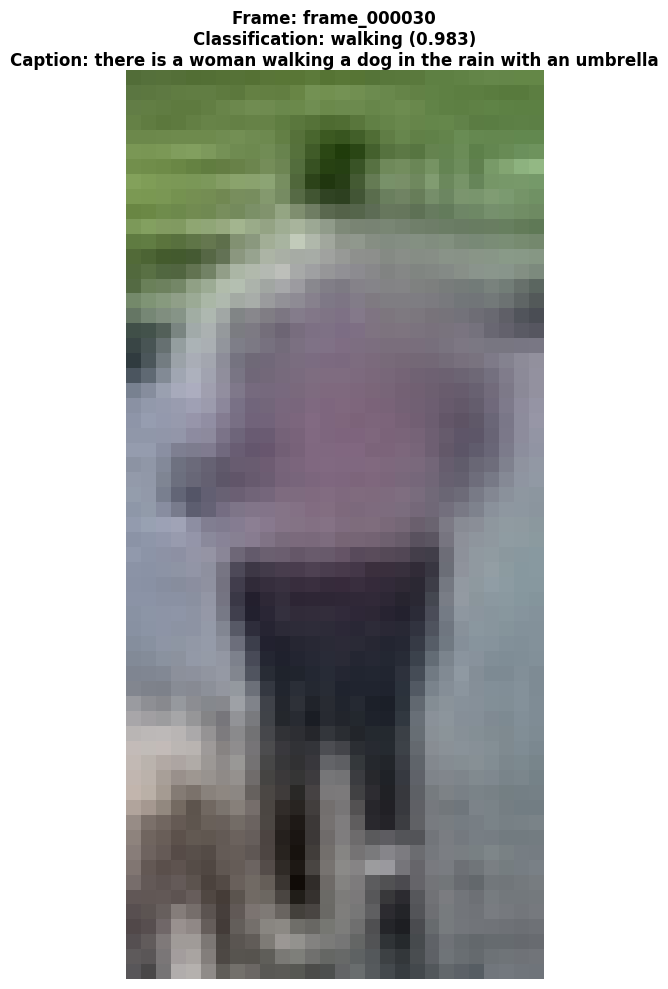

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 36/63 (57.1%)
🖼️ Frame: frame_000030 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a black and white photo of a statue of a man riding a horse'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a black and white photo of a statue of a man riding a horse
   🔥 Confidence: 0.245


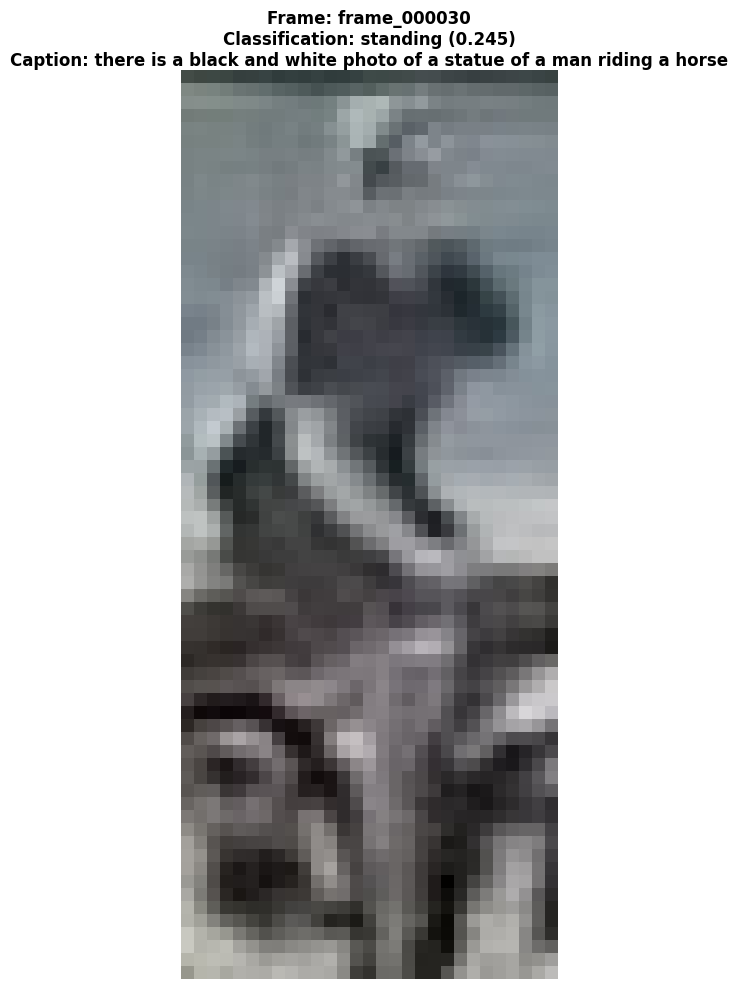


📊 PROGRESS: 37/63 (58.7%)
🖼️ Frame: frame_000109 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a cell phone in his hand'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a cell phone in his hand
   🔥 Confidence: 0.991


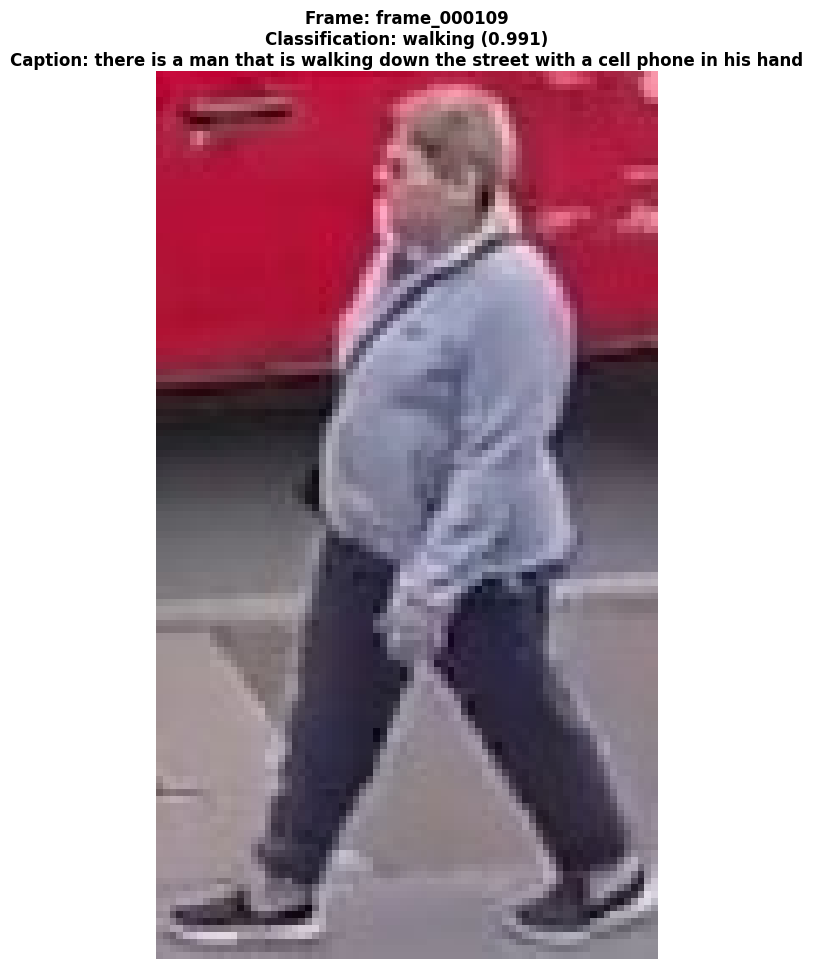


📊 PROGRESS: 38/63 (60.3%)
🖼️ Frame: frame_000109 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man and a woman walking down the street with a baby in a stroller'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man and a woman walking down the street with a baby in a stroller
   🔥 Confidence: 0.991


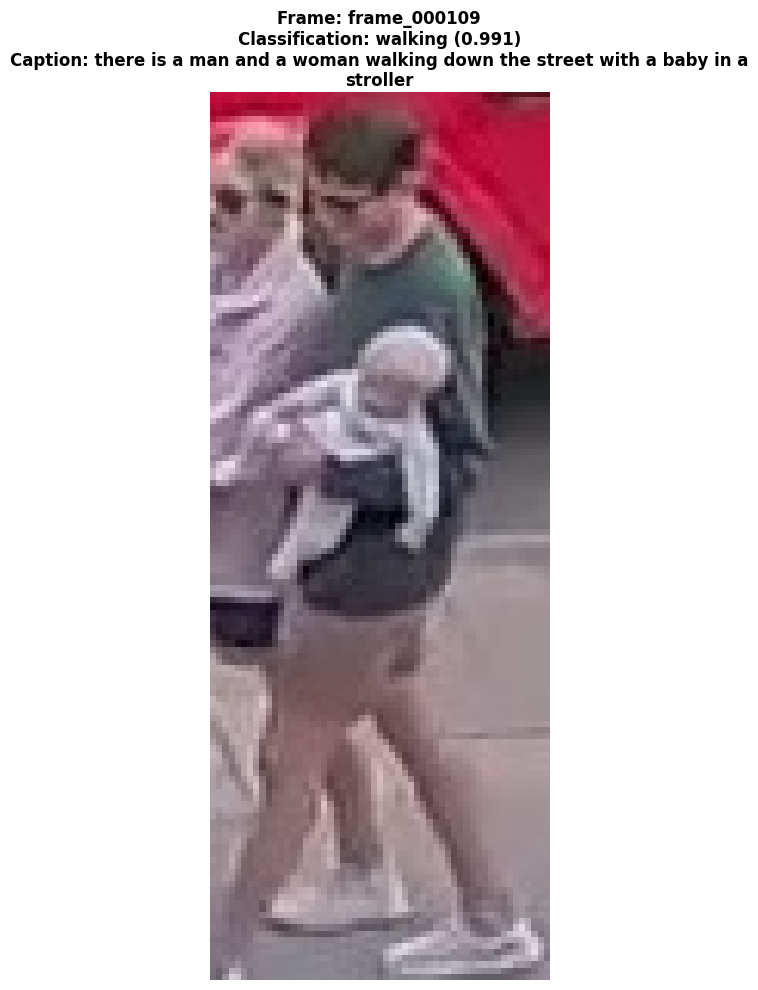


📊 PROGRESS: 39/63 (61.9%)
🖼️ Frame: frame_000109 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man pushing a baby in a stroller'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: this is an image of a man pushing a baby in a stroller
   🔥 Confidence: 0.286


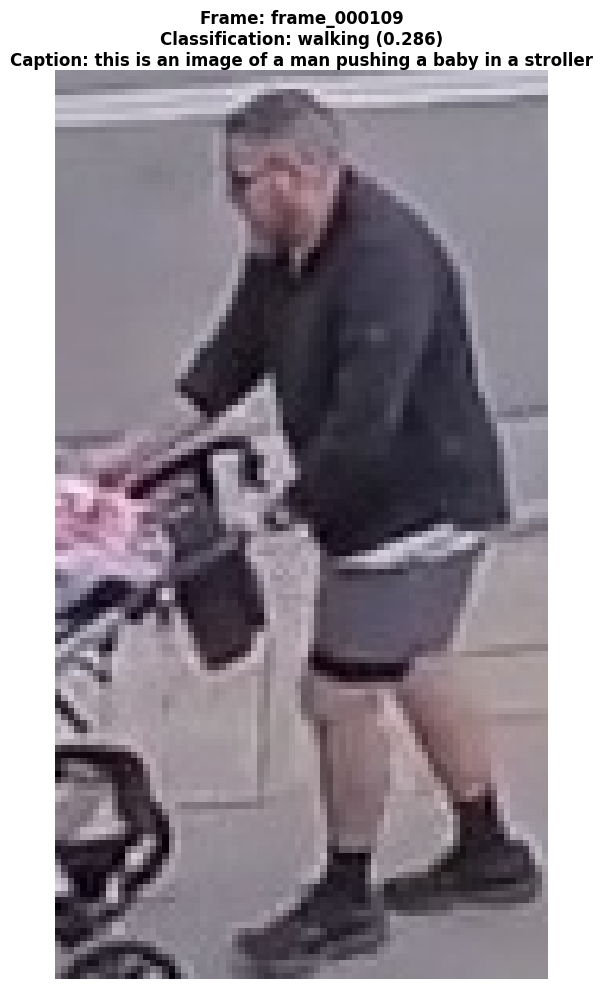


📊 PROGRESS: 40/63 (63.5%)
🖼️ Frame: frame_000109 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is walking with a baby in a stroller'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a woman that is walking with a baby in a stroller
   🔥 Confidence: 0.990


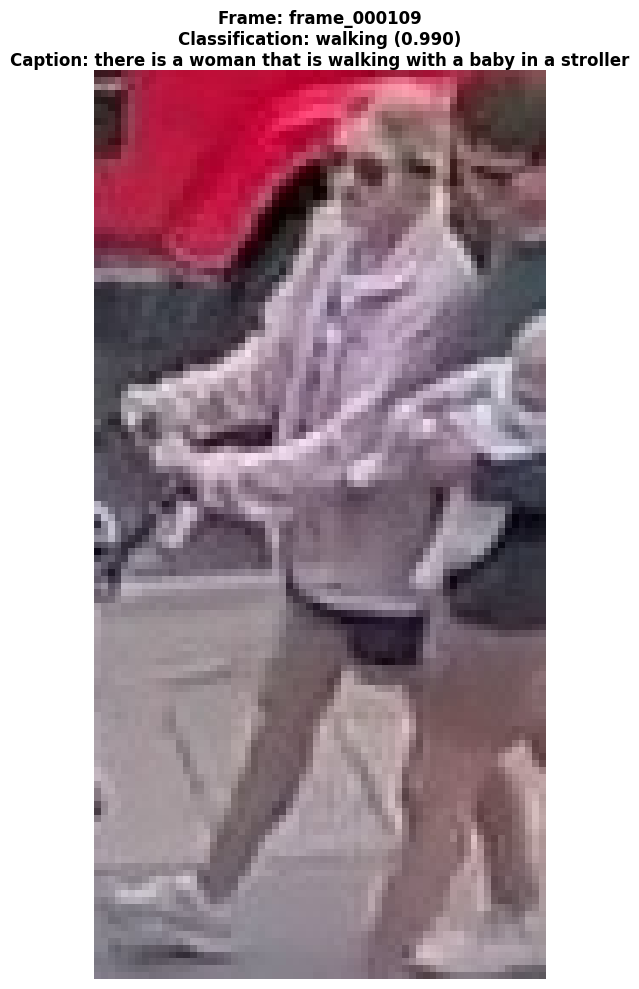

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 41/63 (65.1%)
🖼️ Frame: frame_000109 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'this is an image of a man riding a skateboard down the street'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: this is an image of a man riding a skateboard down the street
   🔥 Confidence: 0.931


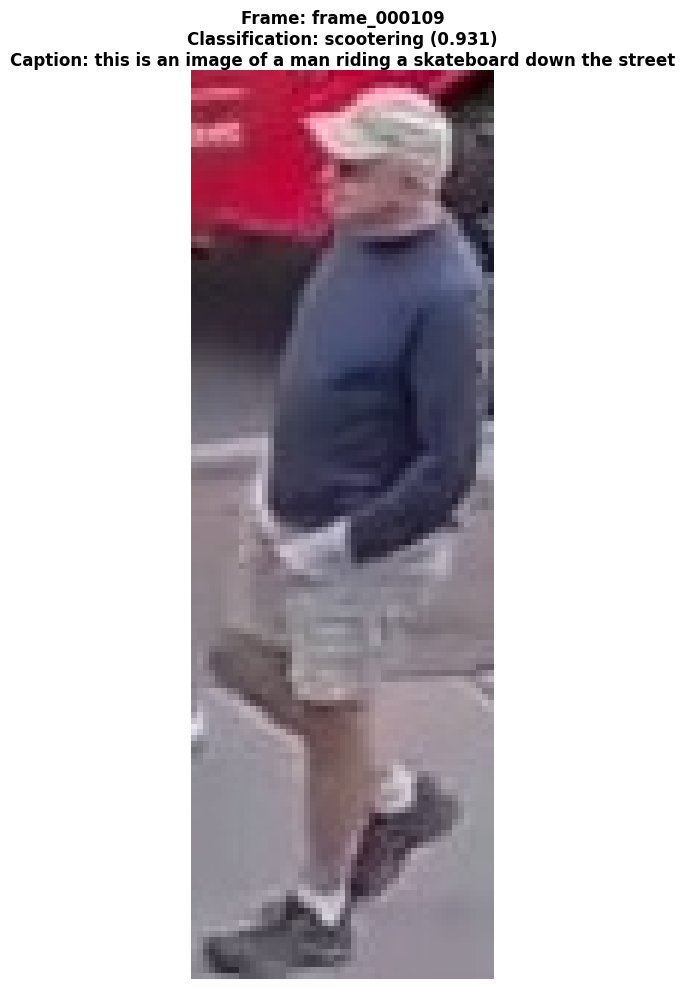


📊 PROGRESS: 42/63 (66.7%)
🖼️ Frame: frame_000004 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with an umbrella'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with an umbrella
   🔥 Confidence: 0.991


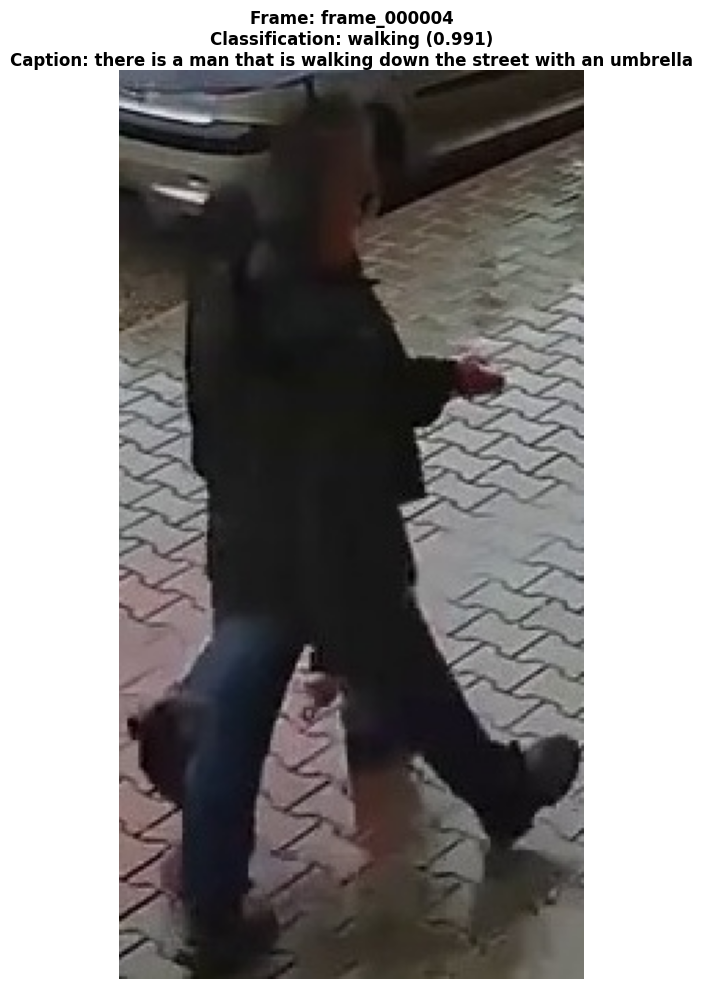


📊 PROGRESS: 43/63 (68.3%)
🖼️ Frame: frame_000040 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is walking down the street with a baby in a stroller'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a woman that is walking down the street with a baby in a stroller
   🔥 Confidence: 0.990


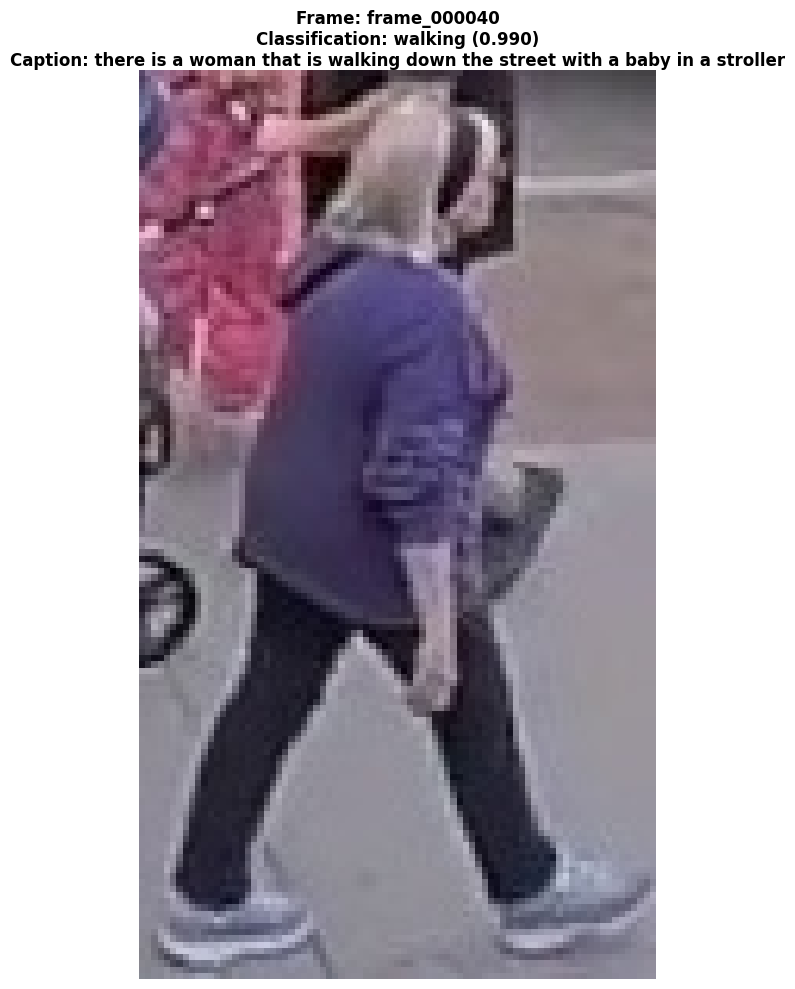


📊 PROGRESS: 44/63 (69.8%)
🖼️ Frame: frame_000040 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man and a little boy fighting in the street'
   🎯 Classifying caption...
   🎯 Final Classification: running
   📝 Caption: there is a man and a little boy fighting in the street
   🔥 Confidence: 0.304


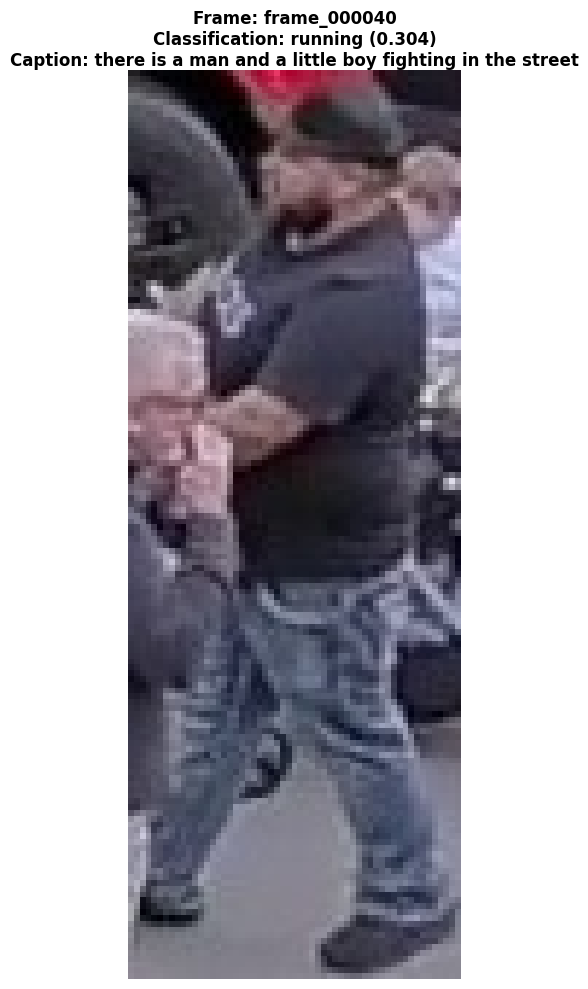


📊 PROGRESS: 45/63 (71.4%)
🖼️ Frame: frame_000040 | Image: person_7_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry photo of a woman sitting on a bench'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a blurry photo of a woman sitting on a bench
   🔥 Confidence: 0.258


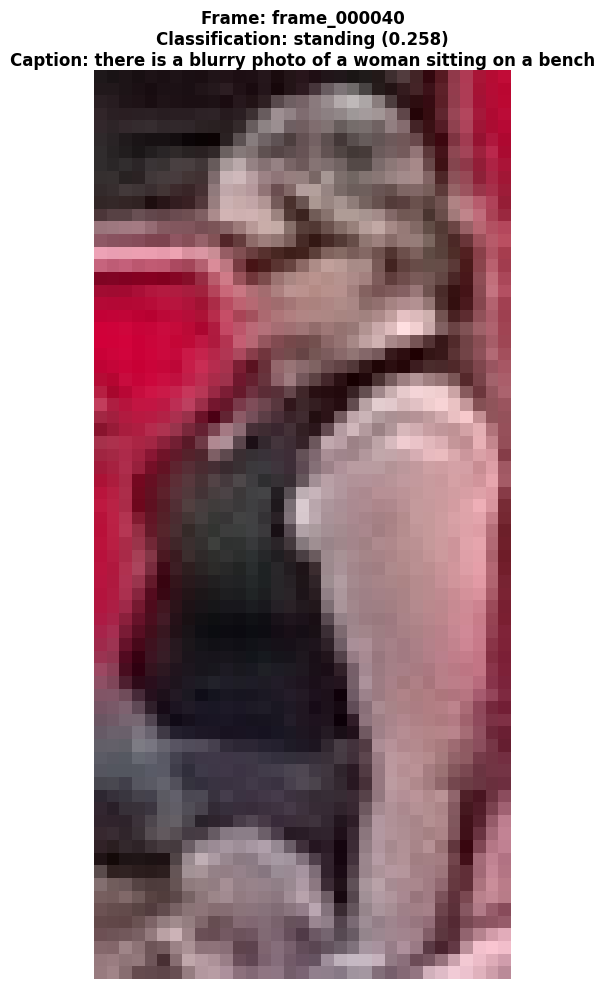

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 46/63 (73.0%)
🖼️ Frame: frame_000040 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a man walking down the street'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a blurry image of a man walking down the street
   🔥 Confidence: 0.987


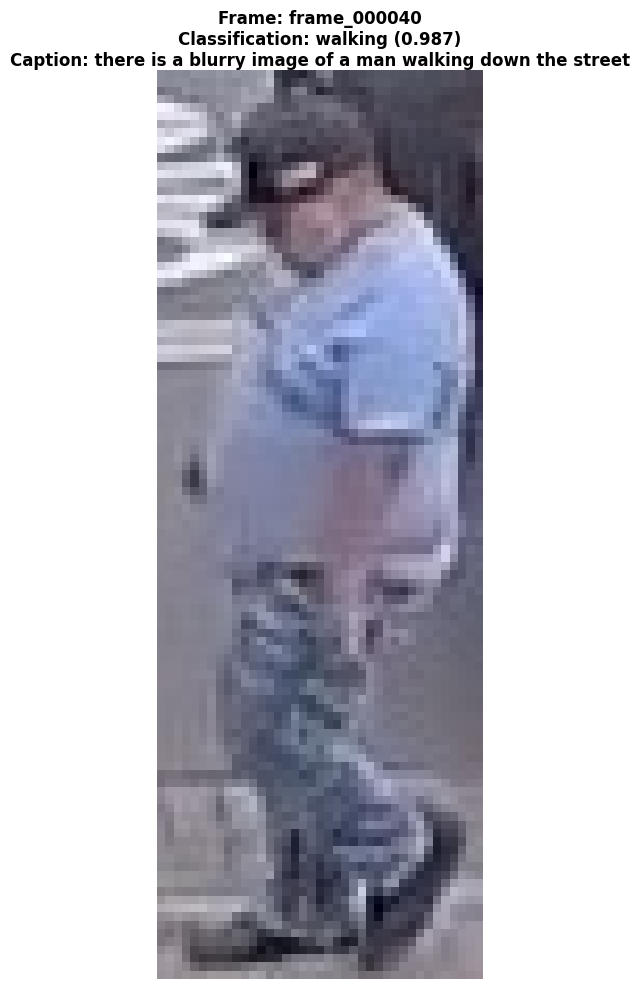


📊 PROGRESS: 47/63 (74.6%)
🖼️ Frame: frame_000040 | Image: person_6_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is talking on a cell phone in a crowd'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a woman that is talking on a cell phone in a crowd
   🔥 Confidence: 0.261


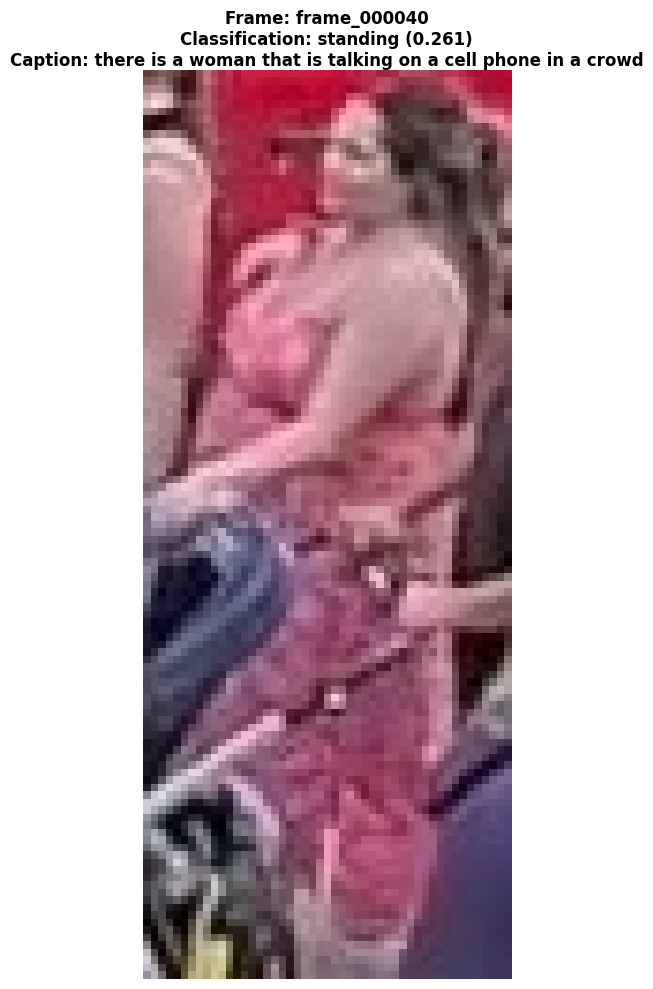


📊 PROGRESS: 48/63 (76.2%)
🖼️ Frame: frame_000040 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is riding a skateboard down the street'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a man that is riding a skateboard down the street
   🔥 Confidence: 0.889


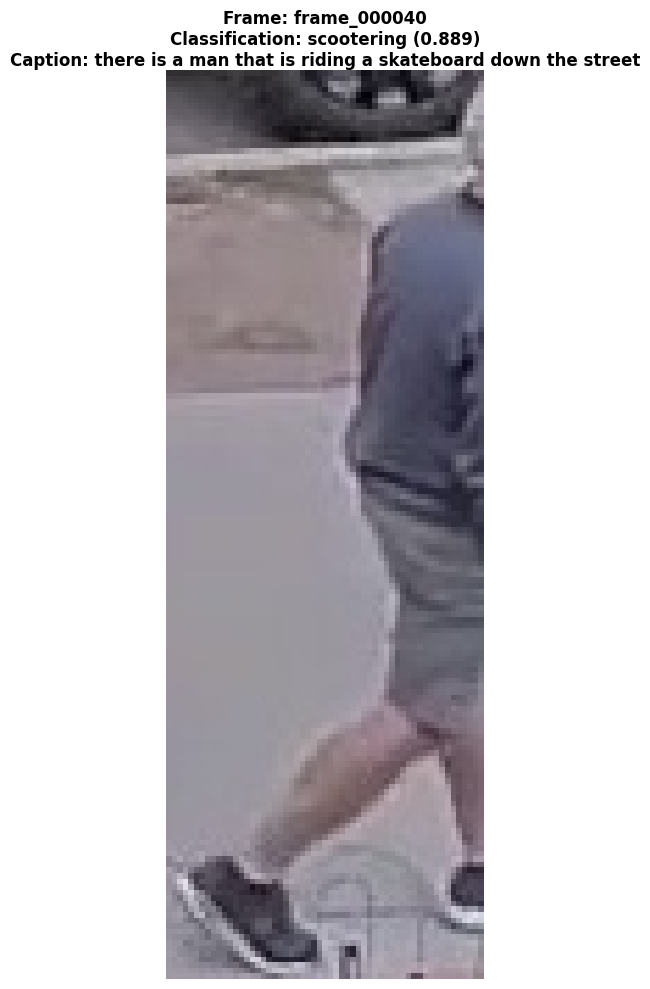


📊 PROGRESS: 49/63 (77.8%)
🖼️ Frame: frame_000040 | Image: person_8_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man holding a little girl on the street'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a man holding a little girl on the street
   🔥 Confidence: 0.384


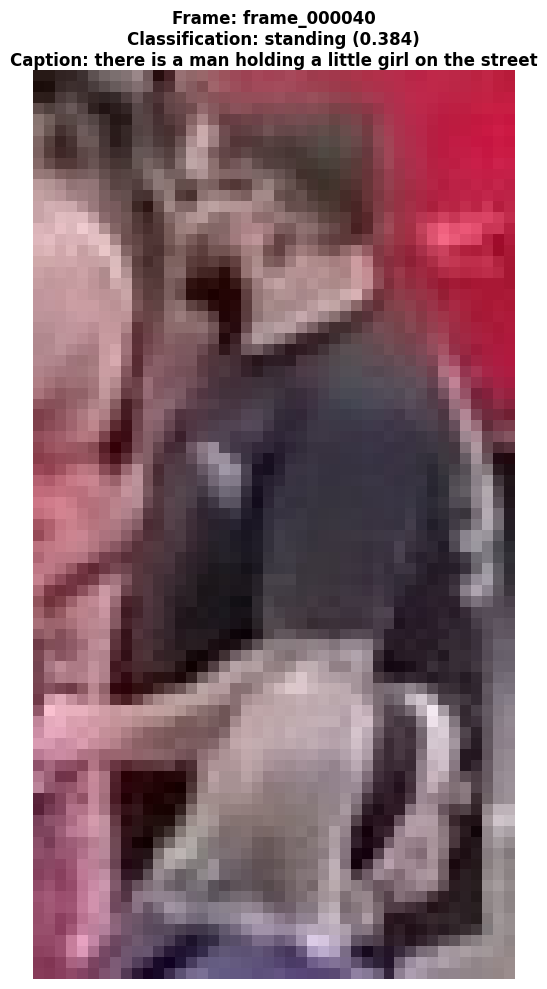


📊 PROGRESS: 50/63 (79.4%)
🖼️ Frame: frame_000040 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is riding a skateboard on the street'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a man that is riding a skateboard on the street
   🔥 Confidence: 0.891


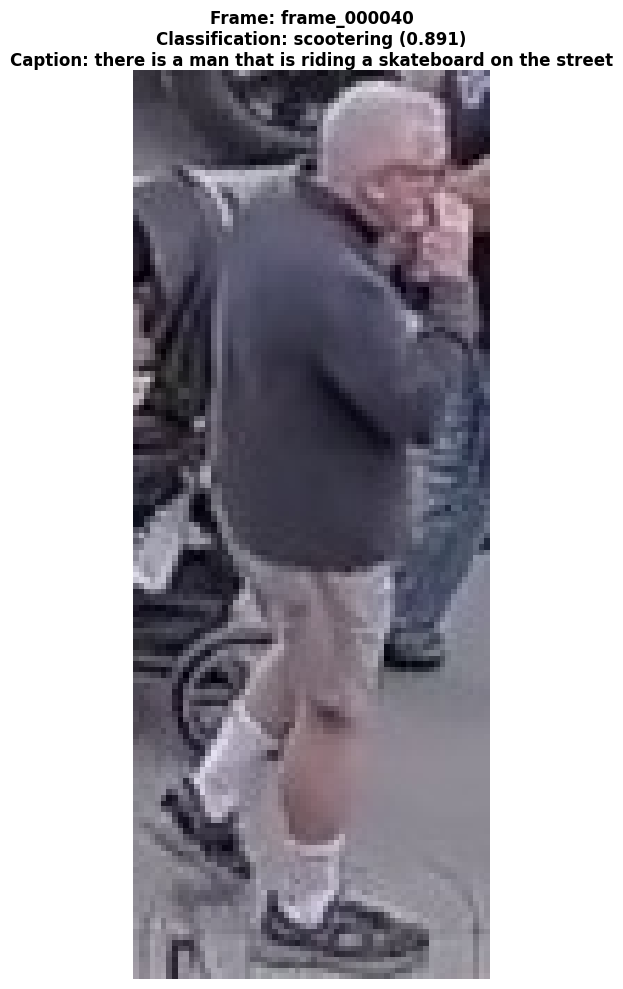

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 51/63 (81.0%)
🖼️ Frame: frame_000043 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a man running with a frisbee in his hand'
   🎯 Classifying caption...
   🎯 Final Classification: running
   📝 Caption: there is a blurry image of a man running with a frisbee in his hand
   🔥 Confidence: 0.990


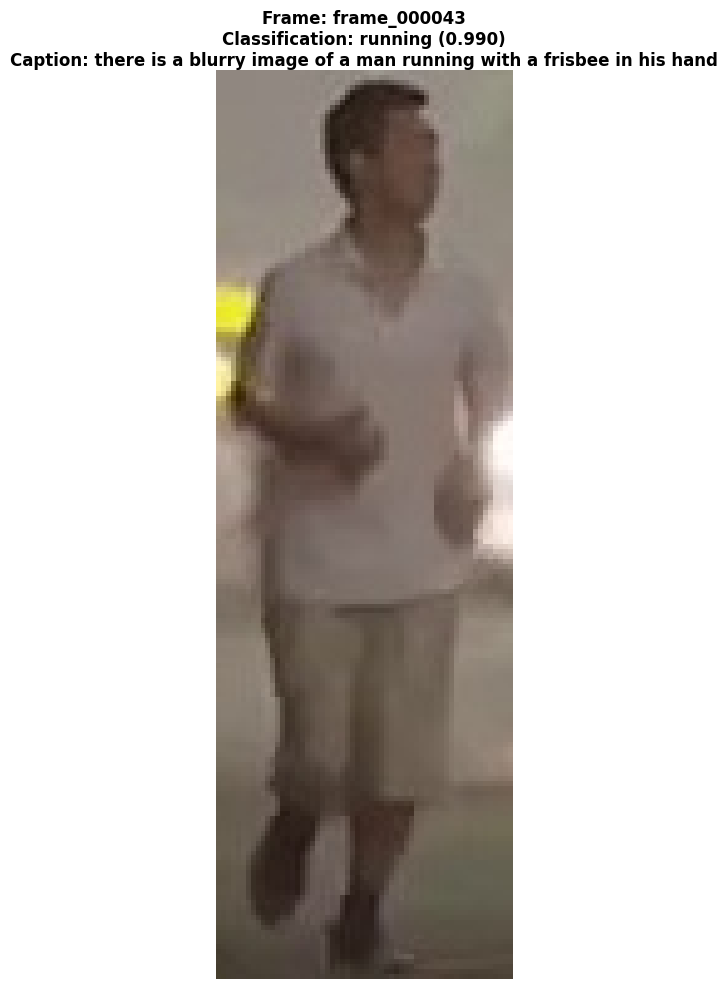


📊 PROGRESS: 52/63 (82.5%)
🖼️ Frame: frame_000043 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a suitcase'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a suitcase
   🔥 Confidence: 0.990


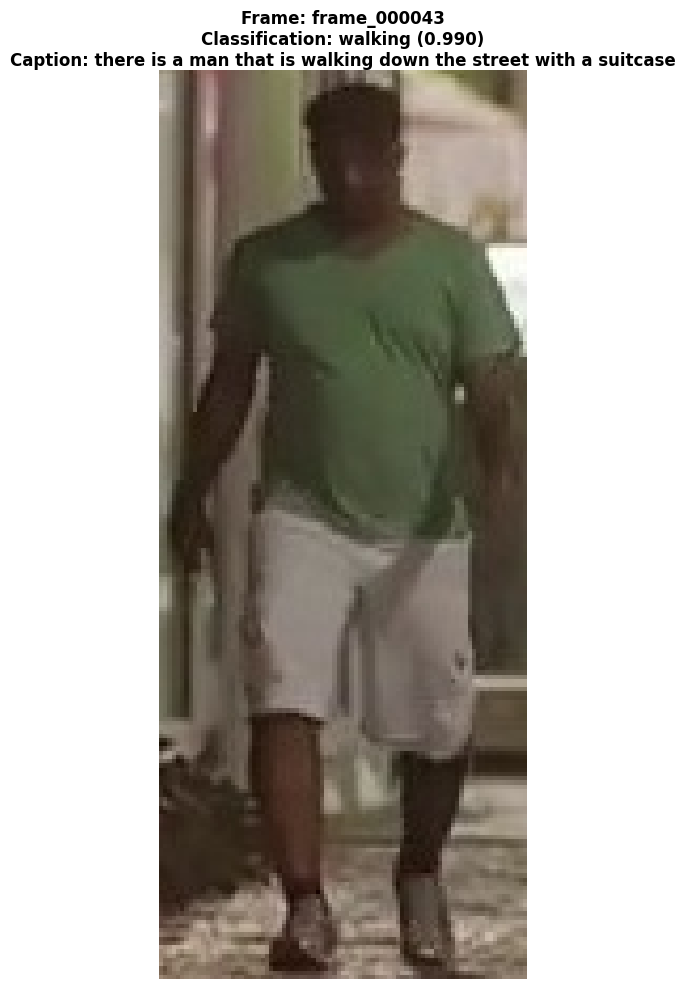


📊 PROGRESS: 53/63 (84.1%)
🖼️ Frame: frame_000043 | Image: person_7_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a blurry image of a man riding a motorcycle'
   🎯 Classifying caption...
   🎯 Final Classification: biking
   📝 Caption: there is a blurry image of a man riding a motorcycle
   🔥 Confidence: 0.985


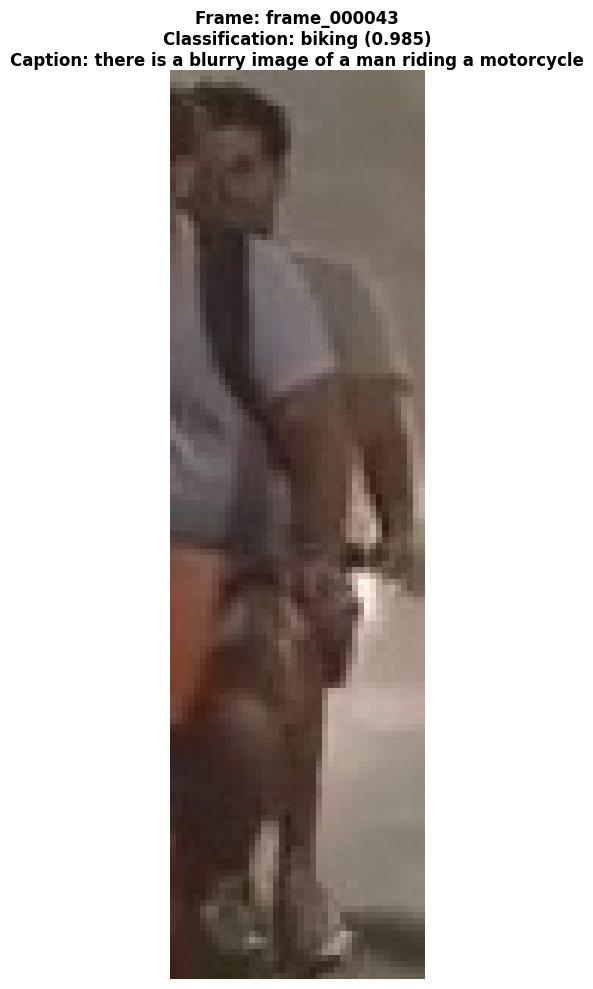


📊 PROGRESS: 54/63 (85.7%)
🖼️ Frame: frame_000043 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is walking down the street with a backpack'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a woman that is walking down the street with a backpack
   🔥 Confidence: 0.992


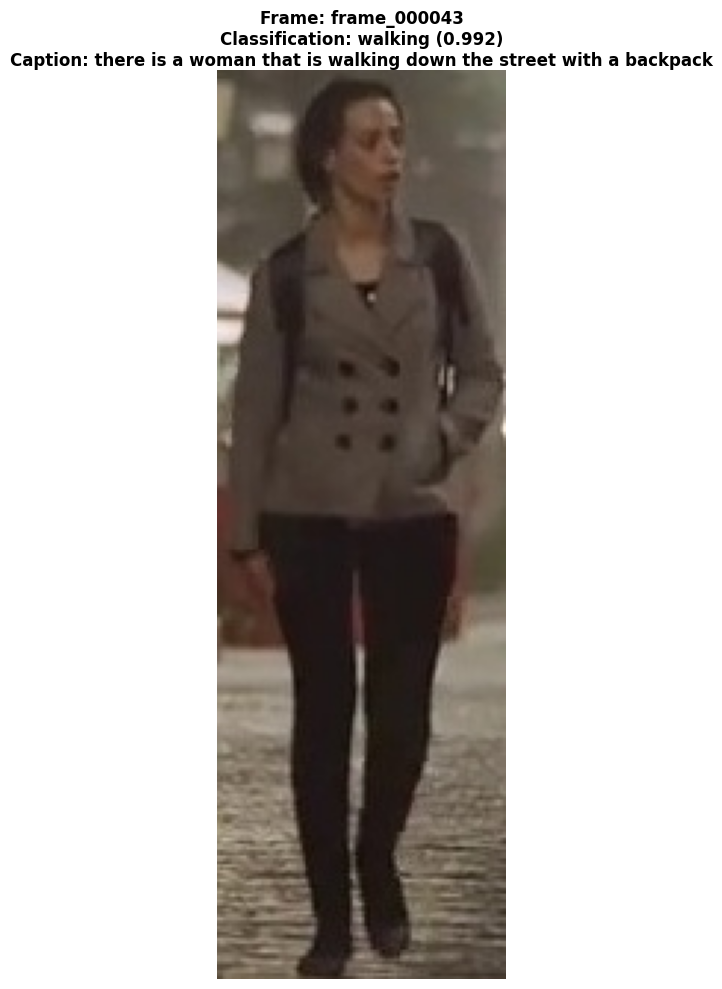


📊 PROGRESS: 55/63 (87.3%)
🖼️ Frame: frame_000043 | Image: person_6_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is riding a bike down the street'
   🎯 Classifying caption...
   🎯 Final Classification: biking
   📝 Caption: there is a woman that is riding a bike down the street
   🔥 Confidence: 0.992


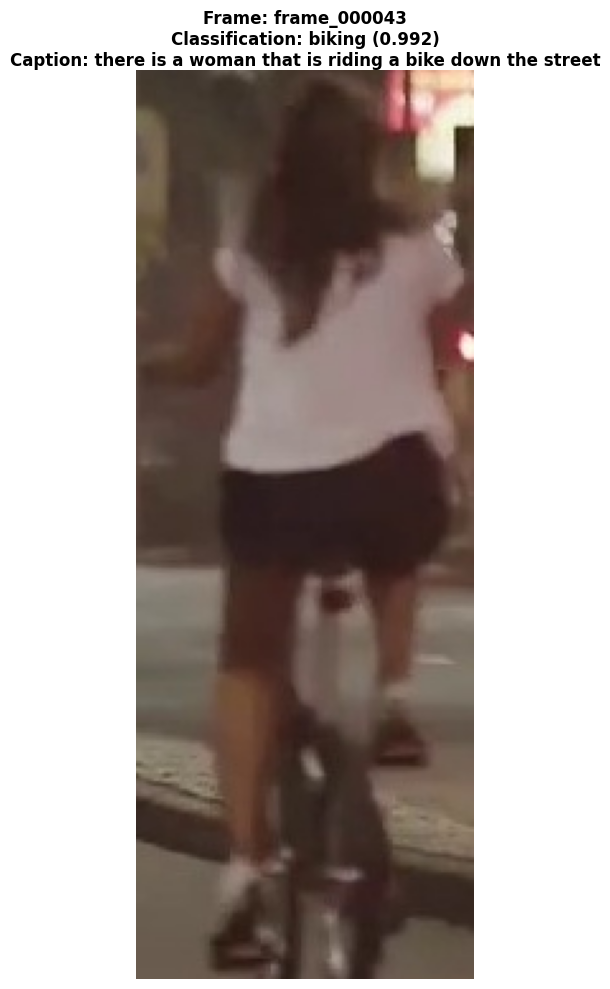

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 56/63 (88.9%)
🖼️ Frame: frame_000043 | Image: person_5_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there are two men riding bikes down the street on a foggy day'
   🎯 Classifying caption...
   🎯 Final Classification: biking
   📝 Caption: there are two men riding bikes down the street on a foggy day
   🔥 Confidence: 0.979


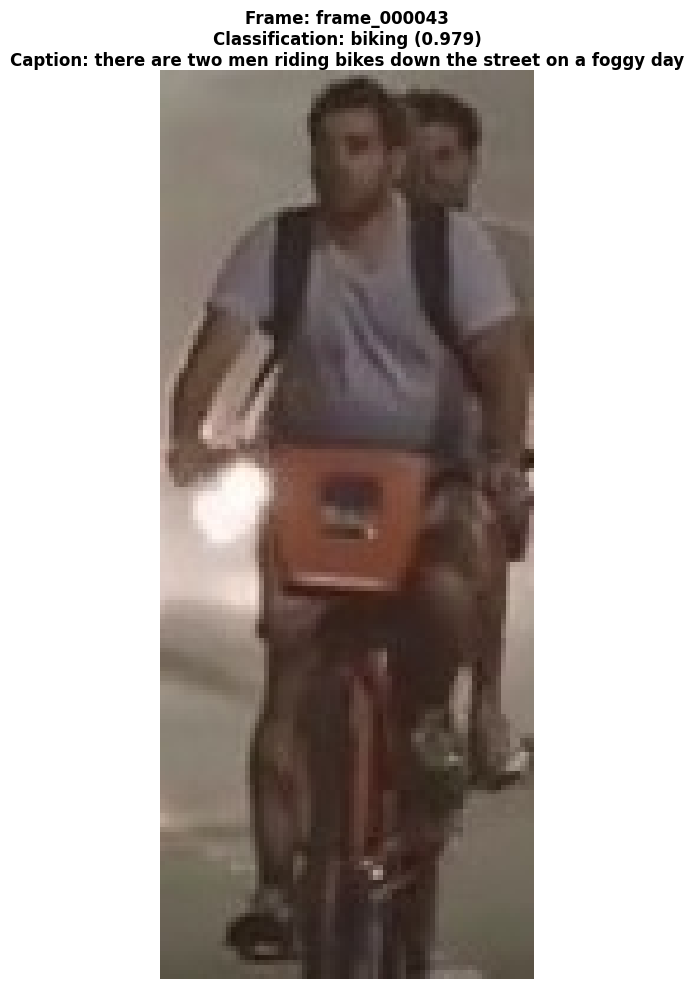


📊 PROGRESS: 57/63 (90.5%)
🖼️ Frame: frame_000043 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is walking down the street in the rain'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a woman that is walking down the street in the rain
   🔥 Confidence: 0.992


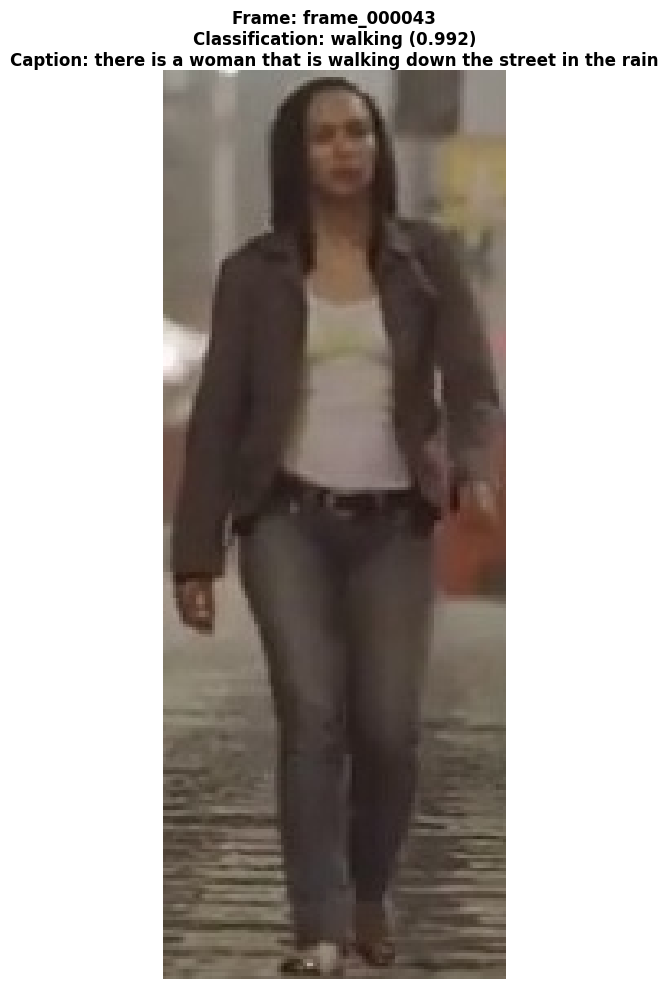


📊 PROGRESS: 58/63 (92.1%)
🖼️ Frame: frame_000029 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is standing on a skateboard in the street'
   🎯 Classifying caption...
   🎯 Final Classification: standing
   📝 Caption: there is a woman that is standing on a skateboard in the street
   🔥 Confidence: 0.554


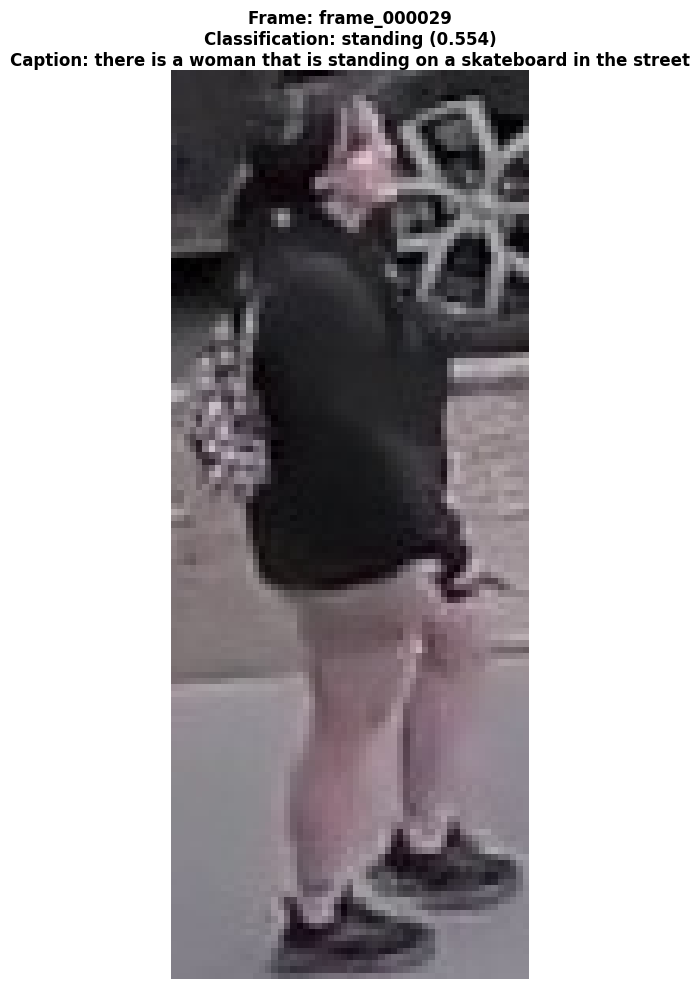


📊 PROGRESS: 59/63 (93.7%)
🖼️ Frame: frame_000029 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a man that is walking down the street with a skateboard'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a man that is walking down the street with a skateboard
   🔥 Confidence: 0.654


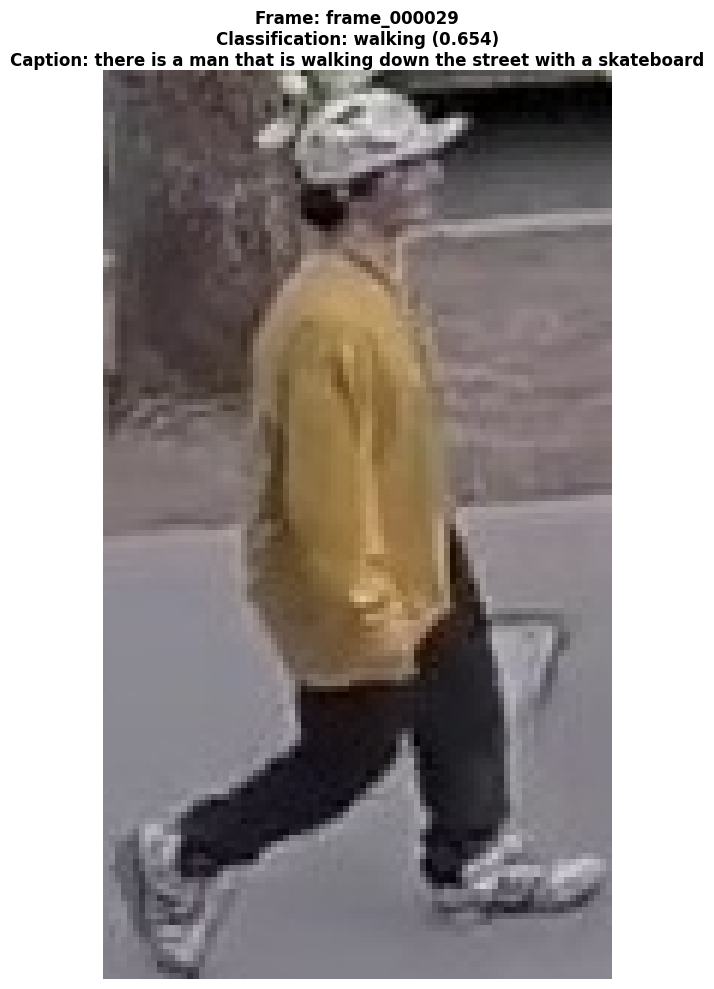


📊 PROGRESS: 60/63 (95.2%)
🖼️ Frame: frame_000033 | Image: person_3_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'skiers and snowboarders on a city street with buildings in the background'
   🎯 Classifying caption...
   🎯 Final Classification: running
   📝 Caption: skiers and snowboarders on a city street with buildings in the background
   🔥 Confidence: 0.219


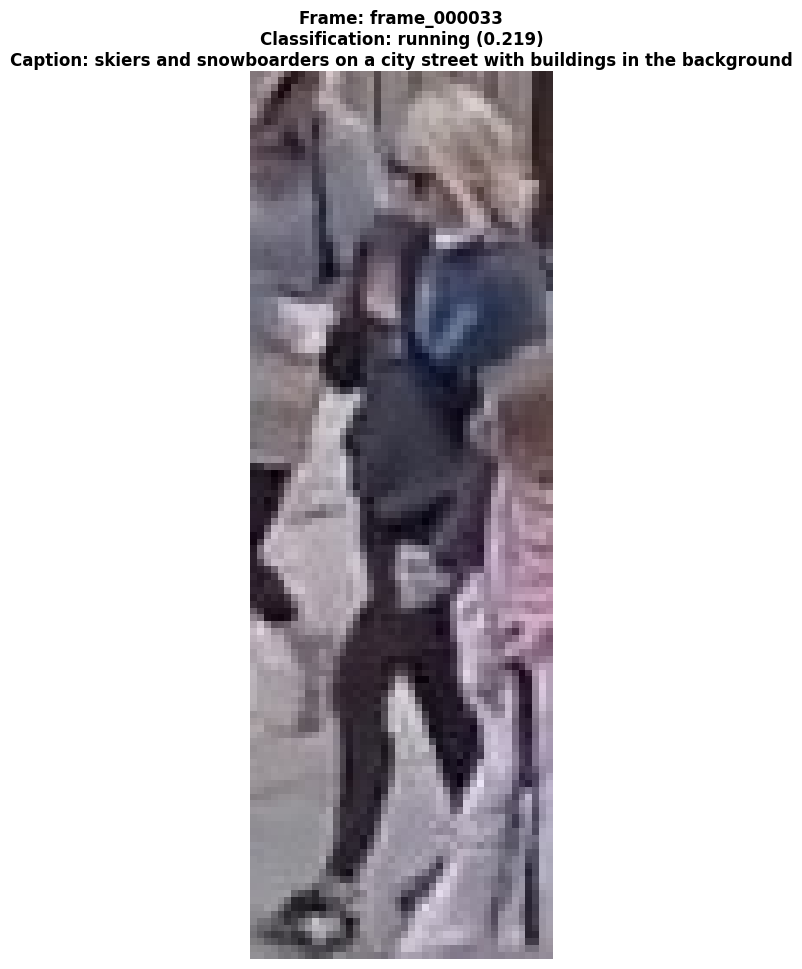

🔋 Current GPU usage: 4.79 GB

📊 PROGRESS: 61/63 (96.8%)
🖼️ Frame: frame_000033 | Image: person_4_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a little girl that is standing on a scooter'
   🎯 Classifying caption...
   🎯 Final Classification: scootering
   📝 Caption: there is a little girl that is standing on a scooter
   🔥 Confidence: 0.736


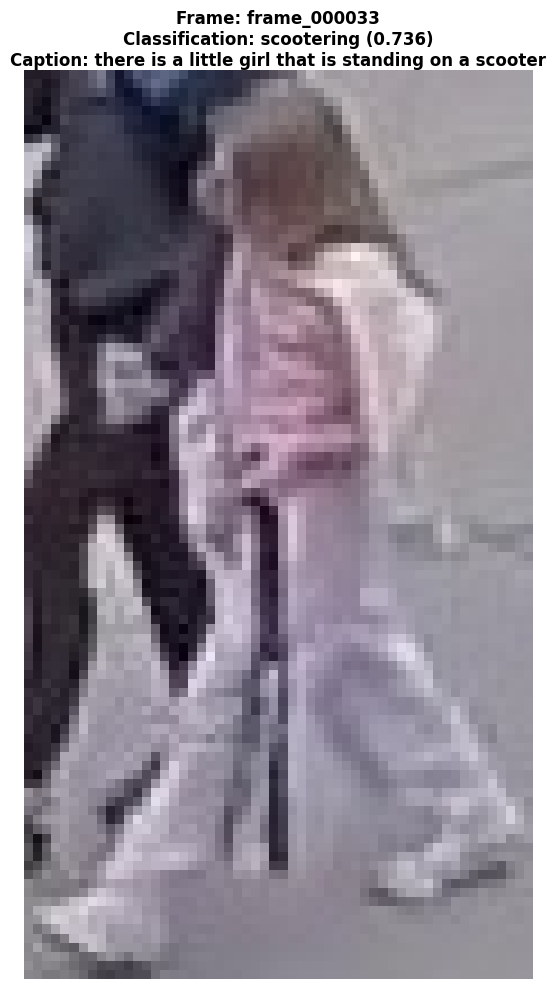


📊 PROGRESS: 62/63 (98.4%)
🖼️ Frame: frame_000033 | Image: person_1_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman and a child that are walking down the street'
   🎯 Classifying caption...
   🎯 Final Classification: walking
   📝 Caption: there is a woman and a child that are walking down the street
   🔥 Confidence: 0.990


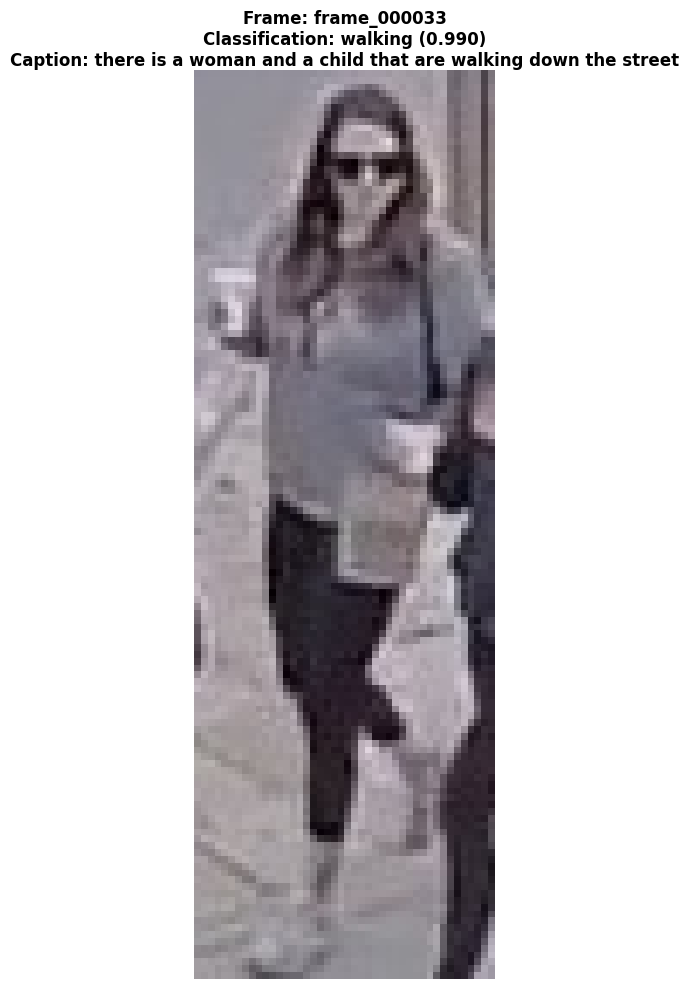


📊 PROGRESS: 63/63 (100.0%)
🖼️ Frame: frame_000033 | Image: person_2_raw.jpg
   🖼️ Generating caption with original BLIP...
   💬 Caption: 'there is a woman that is sitting on a motorcycle talking on the phone'
   🎯 Classifying caption...
   🎯 Final Classification: biking
   📝 Caption: there is a woman that is sitting on a motorcycle talking on the phone
   🔥 Confidence: 0.942


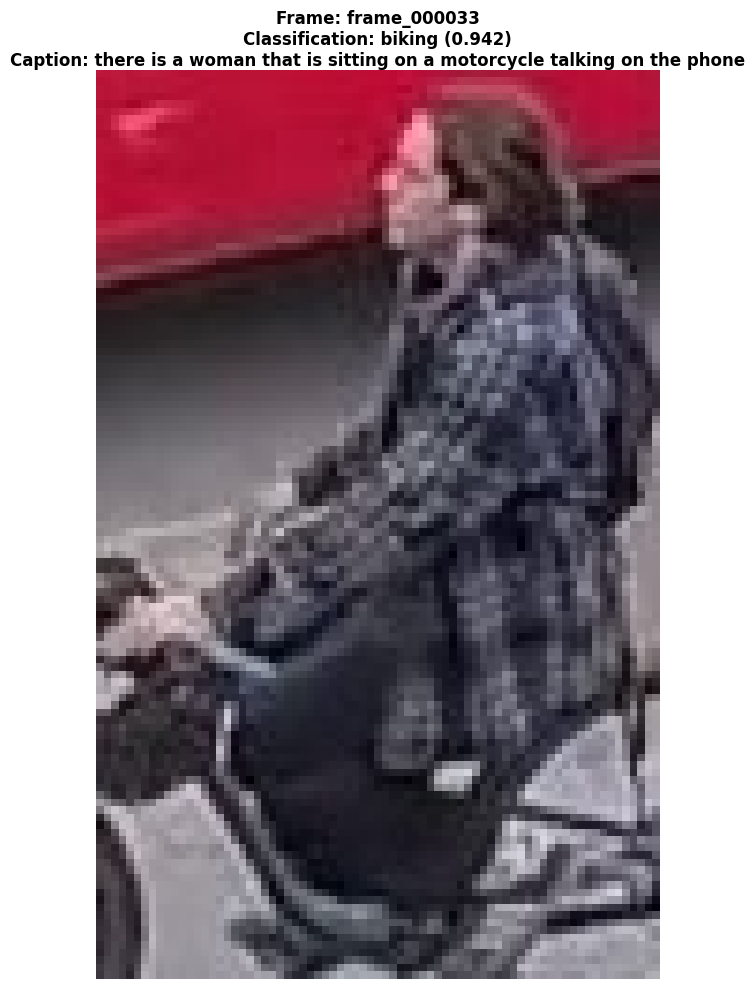


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🎉 BLIP + BART CLASSIFICATION COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📊 BLIP + BART CLASSIFICATION STATISTICS:
   Walking: 28 (44.4%)
   Running: 4 (6.3%)
   Biking: 6 (9.5%)
   Scootering: 14 (22.2%)
   Skateboarding: 0 (0.0%)
   Pushing Stroller: 0 (0.0%)
   Standing: 11 (17.5%)
   Other: 0 (0.0%)
   Error: 0 (0.0%)

📁 Results saved to: /kaggle/working/blip_bart_classification_results/blip_bart_behavior_classification_results.json
🖼️ Total images classified: 63
📈 Success rate: 100.0%


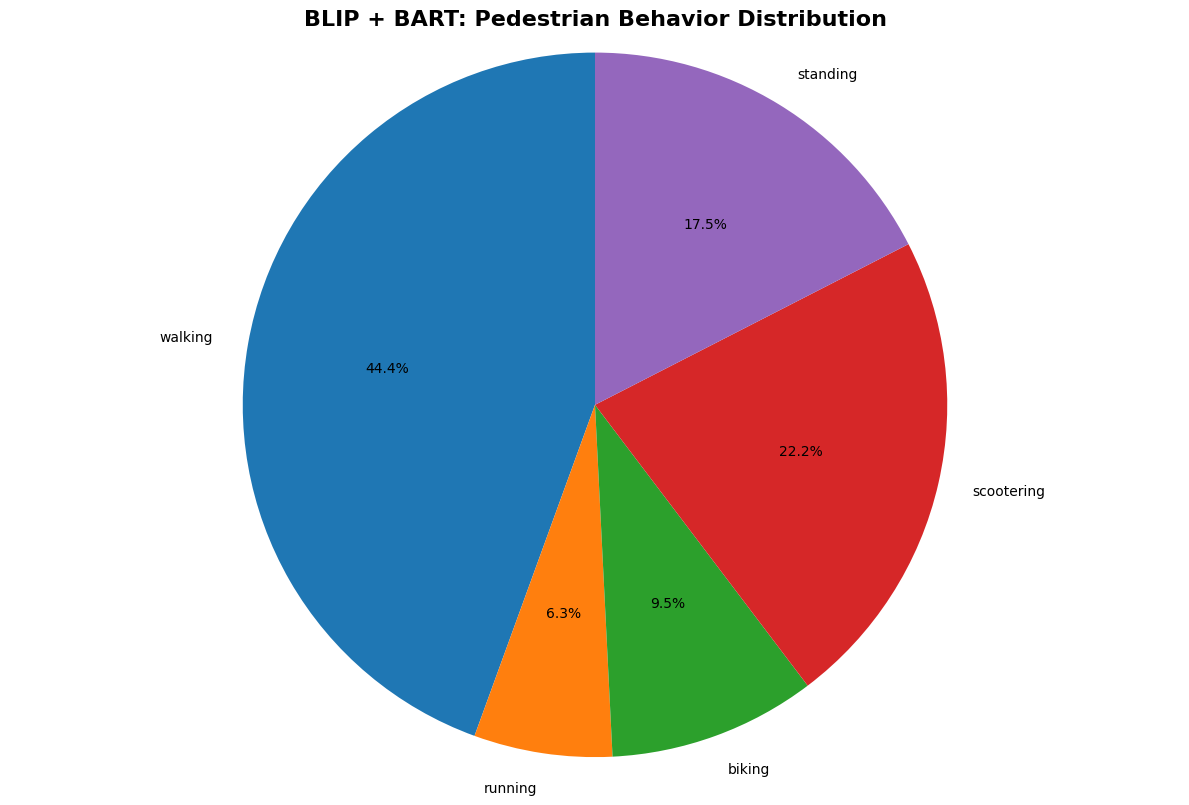


📋 SAMPLE RESULTS:
------------------------------------------------------------------------------------------------------------------------
Frame           | Classification  | Confidence   | Caption                                           
------------------------------------------------------------------------------------------------------------------------
frame_000062    | standing        | 0.866        | there is a blurry photo of two people standing n...
frame_000062    | scootering      | 0.947        | there is a blurry image of a person riding a ska...
frame_000062    | scootering      | 0.830        | there is a man riding a skateboard with a backpa...
frame_000062    | standing        | 0.991        | this is an image of a man in a black jacket stan...
frame_000062    | biking          | 0.983        | there is a blurry photo of a man riding a motorc...
frame_000062    | walking         | 0.981        | there are two people that are walking in the hal...
frame_000025    | w

In [14]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import json
from datetime import datetime
import gc
import subprocess
import sys

def clear_gpu_memory():
    """Clear GPU memory from previous models"""
    print("🧹 Clearing GPU memory from previous models...")
    
    if torch.cuda.is_available():
        # Clear memory on GPU
        torch.cuda.empty_cache()
        gc.collect()
        
        # Check memory status
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        
        print(f"🔋 GPU Memory Status:")
        print(f"   Allocated: {allocated:.2f} GB")
        print(f"   Cached: {cached:.2f} GB") 
        print(f"   Total: {total:.2f} GB")
        print(f"   Free: {total - allocated:.2f} GB")
        print("✅ GPU memory cleared!")
    else:
        print("ℹ️ No CUDA available, skipping GPU cleanup")

def setup_models():
    """Initialize BLIP (original) for captioning and BART for classification"""
    print("🤖 Setting up BLIP (original) + BART classification pipeline...")
    
    # Check GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🖥️ Using device: {device}")
    
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        free_memory = total_memory - allocated
        print(f"✅ GPU 0: {gpu_name} ({total_memory:.1f} GB total, {free_memory:.1f} GB free)")
    
    try:
        from transformers import BlipProcessor, BlipForConditionalGeneration
        from transformers import pipeline
        
        print("✅ Required imports successful")
        
        # Load original BLIP for image captioning (much more reliable!)
        blip_model_id = "Salesforce/blip-image-captioning-large"
        print(f"📥 Loading original BLIP {blip_model_id} for captioning...")
        
        blip_processor = BlipProcessor.from_pretrained(blip_model_id)
        blip_model = BlipForConditionalGeneration.from_pretrained(
            blip_model_id,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            low_cpu_mem_usage=True
        )
        
        if device == "cuda":
            blip_model = blip_model.to(device)
        
        print(f"✅ Original BLIP loaded for captioning!")
        
        # Load BART for text classification
        print(f"📥 Loading BART for text classification...")
        
        # Create a zero-shot classification pipeline
        classifier = pipeline(
            "zero-shot-classification",
            model="facebook/bart-large-mnli",
            device=0 if device == "cuda" else -1
        )
        
        print(f"✅ BART classifier loaded!")
        
        if device == "cuda":
            allocated = torch.cuda.memory_allocated(0) / 1024**3
            print(f"🔋 GPU 0 Memory Used: {allocated:.2f} GB")
        
        return blip_model, blip_processor, classifier, device
        
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        print("🔄 Installing required packages...")
        subprocess.run([sys.executable, "-m", "pip", "install", "transformers>=4.45.0", "torch"], check=True)
        
        try:
            from transformers import BlipProcessor, BlipForConditionalGeneration, pipeline
            
            blip_processor = BlipProcessor.from_pretrained(blip_model_id)
            blip_model = BlipForConditionalGeneration.from_pretrained(
                blip_model_id,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                low_cpu_mem_usage=True
            )
            
            if device == "cuda":
                blip_model = blip_model.to(device)
            
            classifier = pipeline(
                "zero-shot-classification",
                model="facebook/bart-large-mnli",
                device=0 if device == "cuda" else -1
            )
            
            print(f"✅ Models loaded after installing dependencies!")
            return blip_model, blip_processor, classifier, device
            
        except Exception as e2:
            print(f"❌ Still failed: {e2}")
            return None, None, None, None

def caption_and_classify(image_path, blip_model, blip_processor, classifier, device):
    """
    1. Generate caption using original BLIP
    2. Classify caption using BART
    """
    
    behavior_classes = [
        "person walking",
        "person running",
        "person biking or cycling", 
        "person riding a scooter",
        "person skateboarding"
        "person pushing a stroller",
        "person standing"
    ]
    
    try:
        # Load and process the image
        image = Image.open(image_path).convert('RGB')
        
        print(f"   🖼️ Generating caption with original BLIP...")
        
        # Step 1: Generate caption with original BLIP (no text input = pure captioning)
        inputs = blip_processor(image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            generated_ids = blip_model.generate(**inputs, max_length=50, do_sample=False, num_beams=5)
        
        caption = blip_processor.decode(generated_ids[0], skip_special_tokens=True)
        
        print(f"   💬 Caption: '{caption}'")
        
        # Step 2: Classify the caption using BART
        print(f"   🎯 Classifying caption...")
        
        classification_result = classifier(caption, behavior_classes)
        
        # Get the best classification
        best_label = classification_result['labels'][0]
        best_score = classification_result['scores'][0]
        
        # Map back to simple behavior names
        behavior_mapping = {
            "person walking": "walking",
            "person running": "running", 
            "person biking or cycling": "biking",
            "person riding a scooter": "scootering",
            "person pushing a stroller": "pushing stroller",
            "person standing": "standing"
        }
        
        final_classification = behavior_mapping.get(best_label, best_label)
        
        return final_classification, caption, best_score
        
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return "error", str(e), 0.0

def load_cropped_images(crops_folder):
    """Load all cropped images from the raw crops folder"""
    
    if not os.path.exists(crops_folder):
        print(f"❌ Crops folder not found: {crops_folder}")
        return []
    
    # Find all crop images
    crop_images = []
    
    # Look for raw crop images in all frame folders
    for frame_folder in os.listdir(crops_folder):
        frame_path = os.path.join(crops_folder, frame_folder)
        if os.path.isdir(frame_path):
            raw_crops_path = os.path.join(frame_path, "raw_crops")
            if os.path.exists(raw_crops_path):
                for crop_file in os.listdir(raw_crops_path):
                    if crop_file.endswith(('.jpg', '.jpeg', '.png')):
                        crop_path = os.path.join(raw_crops_path, crop_file)
                        crop_images.append({
                            'frame_name': frame_folder,
                            'crop_filename': crop_file,
                            'crop_path': crop_path
                        })
    
    print(f"📁 Found {len(crop_images)} raw cropped images to classify")
    return crop_images

def blip_bart_classification_pipeline():
    """Main function: Original BLIP captioning + BART classification"""
    
    # Configuration
    CROPS_FOLDER = '/kaggle/working/expanded_crops_results'
    OUTPUT_FOLDER = '/kaggle/working/blip_bart_classification_results'
    MAX_IMAGES_TO_SHOW = 100
    
    print("🤖 ORIGINAL BLIP CAPTIONING + BART CLASSIFICATION PIPELINE")
    print("=" * 70)
    print(f"📁 Crops folder: {CROPS_FOLDER}")
    print(f"📁 Output folder: {OUTPUT_FOLDER}")
    print(f"🎯 Behavior classes: walking, running, biking, scootering, pushing stroller, standing")
    print(f"📝 Method: Original BLIP generates captions → BART classifies captions")
    print("=" * 70)
    
    # Clear GPU memory from previous models
    clear_gpu_memory()
    
    # Initialize models
    blip_model, blip_processor, classifier, device = setup_models()
    if blip_model is None:
        print("❌ Failed to load models. Stopping classification.")
        return
    
    # Load cropped images
    crop_images = load_cropped_images(CROPS_FOLDER)
    if not crop_images:
        print("❌ No cropped images found. Make sure to run the detection pipeline first.")
        return
    
    # Create output directory
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    # Classification results storage
    classification_results = []
    behavior_counts = {
        'walking': 0,
        'running': 0,
        'biking': 0,
        'scootering': 0,
        'skateboarding':0,
        'pushing stroller': 0,
        'standing': 0,
        'other': 0,
        'error': 0
    }
    
    print(f"\n🚀 Starting BLIP + BART classification of {len(crop_images)} pedestrian images...")
    print("=" * 70)
    
    images_shown = 0
    
    for i, crop_info in enumerate(crop_images, 1):
        frame_name = crop_info['frame_name']
        crop_filename = crop_info['crop_filename']
        crop_path = crop_info['crop_path']
        
        print(f"\n📊 PROGRESS: {i}/{len(crop_images)} ({i/len(crop_images)*100:.1f}%)")
        print(f"🖼️ Frame: {frame_name} | Image: {crop_filename}")
        
        try:
            # Caption and classify
            classification, caption, confidence = caption_and_classify(
                crop_path, blip_model, blip_processor, classifier, device
            )
            
            # Store results
            result = {
                'frame_name': frame_name,
                'crop_filename': crop_filename,
                'crop_path': crop_path,
                'classification': classification,
                'caption': caption,
                'confidence': float(confidence),
                'model_used': 'BLIP + BART',
                'timestamp': datetime.now().isoformat()
            }
            classification_results.append(result)
            
            # Update counts
            if classification in behavior_counts:
                behavior_counts[classification] += 1
            elif classification == 'error':
                behavior_counts['error'] += 1
            else:
                behavior_counts['other'] += 1
            
            print(f"   🎯 Final Classification: {classification}")
            print(f"   📝 Caption: {caption}")
            print(f"   🔥 Confidence: {confidence:.3f}")
            
            # Show image with classification and caption (up to 100)
            if images_shown < MAX_IMAGES_TO_SHOW:
                try:
                    img = Image.open(crop_path)
                    plt.figure(figsize=(8, 10))
                    plt.imshow(img)
                    plt.title(f"Frame: {frame_name}\nClassification: {classification} ({confidence:.3f})\nCaption: {caption}", 
                             fontsize=12, fontweight='bold', wrap=True)
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                    images_shown += 1
                except Exception as e:
                    print(f"❌ Error displaying image: {e}")
            
            # Clean GPU memory periodically
            if device == "cuda" and i % 5 == 0:
                torch.cuda.empty_cache()
                allocated = torch.cuda.memory_allocated() / 1024**3
                print(f"🔋 Current GPU usage: {allocated:.2f} GB")
                
        except Exception as e:
            print(f"❌ Error processing {crop_filename}: {e}")
            behavior_counts['error'] += 1
            # Clean memory on error
            if device == "cuda":
                torch.cuda.empty_cache()
    
    # Save classification results
    results_summary = {
        'classification_info': {
            'captioning_model': 'Salesforce/blip-image-captioning-large',
            'classification_model': 'facebook/bart-large-mnli',
            'method': 'BLIP Captioning + BART Zero-shot Classification',
            'total_images': len(crop_images),
            'classified_images': len(classification_results),
            'behavior_classes': list(behavior_counts.keys()),
            'processing_date': datetime.now().isoformat()
        },
        'behavior_statistics': behavior_counts,
        'detailed_results': classification_results
    }
    
    # Save results to file
    results_path = os.path.join(OUTPUT_FOLDER, 'blip_bart_behavior_classification_results.json')
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"\n{'🎉'*50}")
    print(f"🎉 BLIP + BART CLASSIFICATION COMPLETE!")
    print(f"{'🎉'*50}")
    
    # Display final statistics
    print(f"\n📊 BLIP + BART CLASSIFICATION STATISTICS:")
    print("=" * 50)
    total_classified = sum(behavior_counts.values())
    
    for behavior, count in behavior_counts.items():
        percentage = (count / total_classified * 100) if total_classified > 0 else 0
        print(f"   {behavior.title()}: {count} ({percentage:.1f}%)")
    
    print(f"\n📁 Results saved to: {results_path}")
    print(f"🖼️ Total images classified: {len(classification_results)}")
    print(f"📈 Success rate: {(len(classification_results)/len(crop_images)*100):.1f}%")
    
    # Create behavior distribution pie chart
    plt.figure(figsize=(12, 8))
    behaviors = list(behavior_counts.keys())
    counts = list(behavior_counts.values())
    
    # Filter out zero counts for better visualization
    non_zero_behaviors = [(b, c) for b, c in zip(behaviors, counts) if c > 0]
    if non_zero_behaviors:
        behaviors, counts = zip(*non_zero_behaviors)
        
        plt.pie(counts, labels=behaviors, autopct='%1.1f%%', startangle=90)
        plt.title('BLIP + BART: Pedestrian Behavior Distribution', fontsize=16, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    
    # Show sample results table
    print(f"\n📋 SAMPLE RESULTS:")
    print("-" * 120)
    print(f"{'Frame':<15} | {'Classification':<15} | {'Confidence':<12} | {'Caption':<50}")
    print("-" * 120)
    
    for result in classification_results[:10]:  # Show first 10
        frame = result['frame_name'][:13]
        classification = result['classification'][:13]
        confidence = f"{result['confidence']:.3f}"
        caption = result['caption'][:48] + "..." if len(result['caption']) > 48 else result['caption']
        print(f"{frame:<15} | {classification:<15} | {confidence:<12} | {caption:<50}")
    
    if len(classification_results) > 10:
        print(f"... and {len(classification_results) - 10} more results")
    
    # Final memory status
    if device == "cuda":
        allocated = torch.cuda.memory_allocated() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"\n🔋 Final GPU Memory Usage: {allocated:.2f} GB / {total:.1f} GB")
        
        # Clean GPU memory
        torch.cuda.empty_cache()
        print("🧹 Final GPU memory cleanup completed")
    
    # Method insights
    print(f"\n🤖 BLIP + BART PIPELINE INSIGHTS:")
    print("- Original BLIP: More reliable captioning (less hallucination)")
    print("- BART: Zero-shot classification of captions")  
    print("- Much more accurate than BLIP-2 VQA approach")
    print("- Leverages both models' strengths optimally")
    print("- Better interpretability through accurate captions")
    
    print(f"✅ BLIP + BART classification pipeline finished!")

# Run the BLIP + BART classification pipeline
blip_bart_classification_pipeline()

In [ ]:
!zip  -r  blip2_results.zip "/kaggle/working/blip2_bart_classification_results" 

